In [1]:
from matplotlib import pyplot as plt
from os import listdir
import pandas as pd

import tensorflow as tf
import numpy as np

from model import MonoexponentialModelP

%matplotlib inline

In [2]:
DATASET_PATH = 'dataset'
PLOTS_PATH = 'plots'
MODELS_PATH = 'models'

In [3]:
def get_file_names(datasets_folder=DATASET_PATH):
    return [datasets_folder + '/' + _ for _ in listdir(datasets_folder)]

In [4]:
def read_datasets(file_names):
    return [pd.read_csv(f_name,
                        header=0,
                        parse_dates=[0],
                        infer_datetime_format=True) 
            for f_name in file_names]

In [5]:
fnames = get_file_names()
df_list = read_datasets(fnames)

In [6]:
# for df in df_list:
#     plt.figure(figsize=(7,5))
#     plt.semilogx(df.frequency_hz, df.dlts_pf, '.g', label="Actual values", alpha=1)
#     plt.xlabel('Frequency, Гц')
#     plt.ylabel('DLTS, пФ')
#     plt.legend()
    
#     title = f'{df.specimen_name[0]} Т={df.temperature_k.mean():.1f} К, $U_1$={df.u1[0]} В, $U_R$={df.ur[0]} В'
#     plt.title(title)
    
#     plt.grid()
#     # plt.savefig('plots/monoexponential/p_experimental_data.svg')
#     plt.show()

In [7]:
def fit_model(dlts, frequency, f_pulse, learning_rate=0.1, batch_size=None, epochs=1, return_history=True):
    
    
    freq_values = frequency.copy()
    dlts_values = dlts.copy()
    
    max_abs_index = np.absolute(dlts_values).argmax()
    extrem_val = dlts_values[max_abs_index]
    
    new_max_dlts = np.log10(freq_values.max())

    normalize = lambda x: x / extrem_val * new_max_dlts
    denormalize = lambda x: x * extrem_val / new_max_dlts
    
    dlts_values = normalize(dlts_values)

    initial_time_constant = float(-np.log10(freq_values[max_abs_index]))
    initial_amplitude = float(dlts_values[max_abs_index])
    
    f_pulse_value = float(f_pulse) * 10 ** (-6)
    
    
    initial_model = MonoexponentialModelP(filling_pulse=f_pulse_value,
                                          time_constant_power=initial_time_constant,
                                          amplitude=initial_amplitude)
    
    final_model = MonoexponentialModelP(filling_pulse=f_pulse_value,
                                        time_constant_power=initial_time_constant,
                                        amplitude=initial_amplitude
                                       )
    
    
    final_model.compile(run_eagerly=False,
                        loss=tf.keras.losses.MSE,
                        optimizer=tf.optimizers.SGD(learning_rate=learning_rate)
                       )
    
    history = final_model.fit(freq_values, 
                              dlts_values, 
                              epochs=epochs, 
                              batch_size=batch_size, 
                              verbose=False
                             )
    
    
    dlts_values = denormalize(dlts_values)
    initial_model.amplitude = denormalize(initial_model.amplitude)
    final_model.amplitude = denormalize(final_model.amplitude)
    
    out = [freq_values, dlts_values, initial_model, final_model]
    if return_history:
        out.append(history)
    
    return out

In [8]:
def print_results(frequency, actual_dlts, initial_model, final_model, history = None,):
    def print_params(model, actual_dlts, frequency):
        time_constant_power = model.time_constant_power.numpy()
        f_pulse = model.filling_pulse.numpy()
        p = model.p_coef.numpy()
        amp = model.amplitude.numpy()
        mse = tf.keras.metrics.mean_squared_error(actual_dlts, model(frequency))

        print(f'Filling pulse = {f_pulse:.4e}')
        print(f'Time constant power = {time_constant_power:.4f} log10(s)')
        print(f'Time constant = {10**time_constant_power:.4e} s')
        print(f'Amplitude = {amp:.4e} pF')
        print(f'P = {p:.4f}')
        print(f'MSE = {mse:.4e}')
        print(f'RMSE = {tf.sqrt(mse):.4e}')
    
    
    print('Initial values:')
    print_params(initial_model, actual_dlts, frequency)
    print('\nFinal values')
    print_params(final_model, actual_dlts, frequency)
        
    
    if not (history is None):
        fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 5))
    else:
        fig, ax0 = plt.subplots(1, 1, figsize=(7,5))
        
    ax0.semilogx(frequency, actual_dlts, '.g', label="Actual values", alpha=0.3)
    ax0.semilogx(frequency, initial_model(frequency), '-.b', label="Initial model", alpha=0.5)
    ax0.semilogx(frequency, final_model(frequency), 'r', label="Final model")
    
    ax0.set_xlabel('Frequency, Hz')
    ax0.set_ylabel('DLTS, pF')
    ax0.legend()
    ax0.grid()

    if not (history is None):
        loss = np.array(history.history['loss'])
        norm_loss = loss/loss.max()
        
        ax1.plot(norm_loss)
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Normalized Mean Squared Error')
        plt.ylim([0, max(plt.ylim())])
        ax1.grid()
    
    if not ((final_model is None) or (history is None)):
        return fig, (ax0, ax1)
    else:
        return fig, ax0

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -3.0979 log10(s)
Time constant = 7.9810e-04 s
Amplitude = -3.8660e-04 pF
P = 1.0000
MSE = 4.3387e-09
RMSE = 6.5869e-05

Final values
Filling pulse = 2.0000e-05
Time constant power = -3.2234 log10(s)
Time constant = 5.9784e-04 s
Amplitude = -3.9175e-04 pF
P = 0.5811
MSE = 1.6371e-09
RMSE = 4.0461e-05


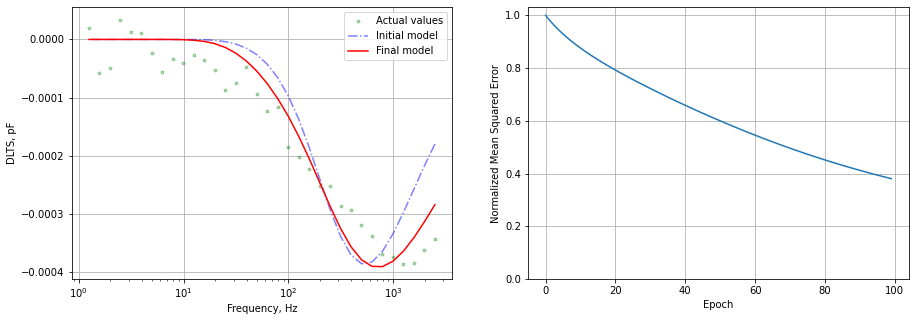

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.4979 log10(s)
Time constant = 3.1773e-03 s
Amplitude = -9.8780e-04 pF
P = 1.0000
MSE = 6.7038e-08
RMSE = 2.5892e-04

Final values
Filling pulse = 2.0000e-05
Time constant power = -2.8537 log10(s)
Time constant = 1.4005e-03 s
Amplitude = -1.0284e-03 pF
P = 0.4564
MSE = 1.9306e-09
RMSE = 4.3938e-05


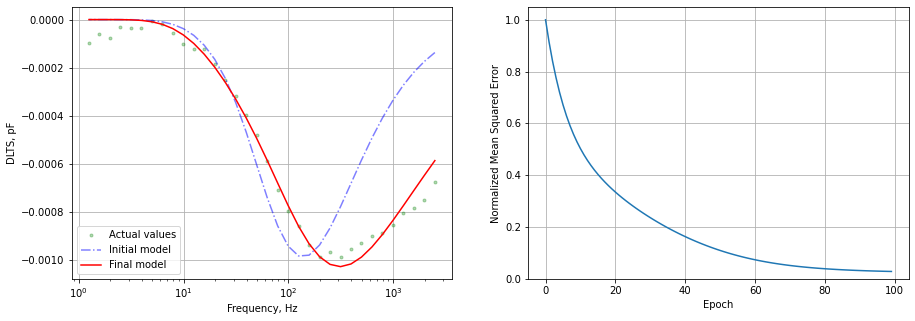

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -3.2979 log10(s)
Time constant = 5.0357e-04 s
Amplitude = -3.2880e-04 pF
P = 1.0000
MSE = 7.7423e-09
RMSE = 8.7990e-05

Final values
Filling pulse = 2.0000e-05
Time constant power = -3.1011 log10(s)
Time constant = 7.9228e-04 s
Amplitude = -3.2325e-04 pF
P = 0.4884
MSE = 3.9778e-09
RMSE = 6.3070e-05


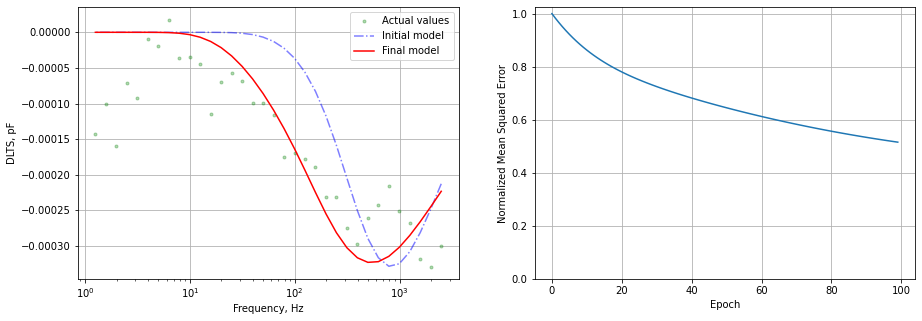

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.0979 log10(s)
Time constant = 7.9810e-03 s
Amplitude = -1.4994e-02 pF
P = 1.0000
MSE = 1.1419e-05
RMSE = 3.3791e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -2.4318 log10(s)
Time constant = 3.6996e-03 s
Amplitude = -1.5180e-02 pF
P = 0.8428
MSE = 2.9102e-08
RMSE = 1.7059e-04


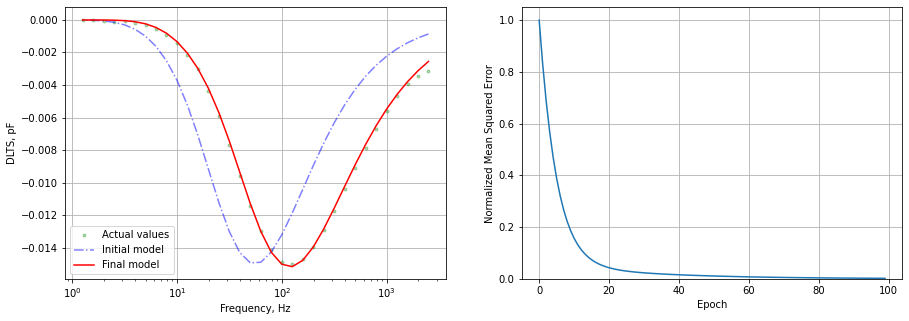

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.0979 log10(s)
Time constant = 7.9810e-03 s
Amplitude = -1.4898e-02 pF
P = 1.0000
MSE = 1.1111e-05
RMSE = 3.3333e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -2.4293 log10(s)
Time constant = 3.7214e-03 s
Amplitude = -1.5081e-02 pF
P = 0.8392
MSE = 3.0714e-08
RMSE = 1.7525e-04


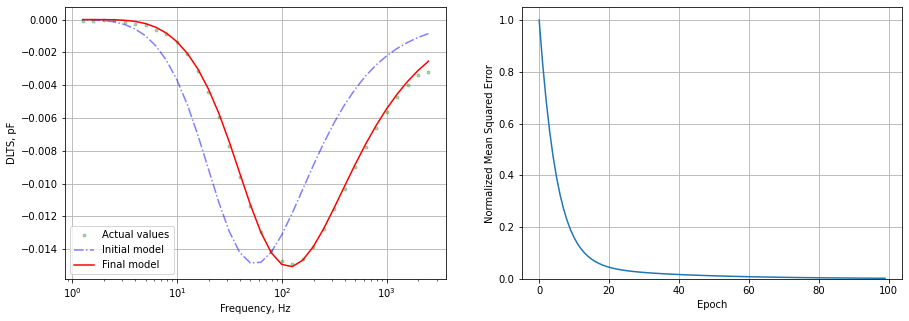

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.0979 log10(s)
Time constant = 7.9810e-03 s
Amplitude = -1.4790e-02 pF
P = 1.0000
MSE = 1.0762e-05
RMSE = 3.2805e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -2.4259 log10(s)
Time constant = 3.7508e-03 s
Amplitude = -1.4972e-02 pF
P = 0.8424
MSE = 2.9820e-08
RMSE = 1.7269e-04


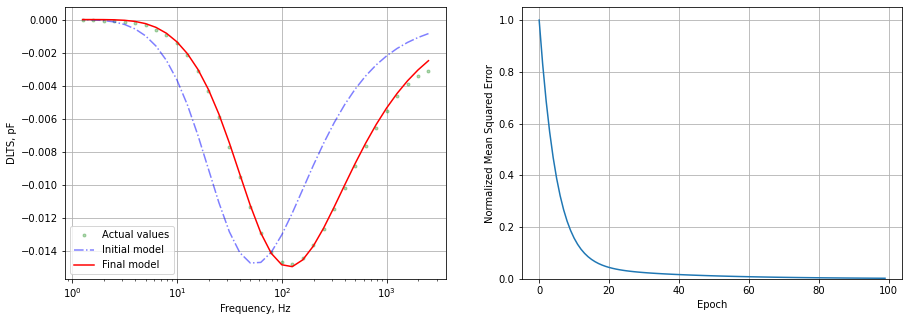

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.3979 log10(s)
Time constant = 4.0000e-03 s
Amplitude = -5.3500e-03 pF
P = 1.0000
MSE = 1.9685e-06
RMSE = 1.4030e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -2.7860 log10(s)
Time constant = 1.6367e-03 s
Amplitude = -5.5086e-03 pF
P = 0.5855
MSE = 2.2439e-08
RMSE = 1.4979e-04


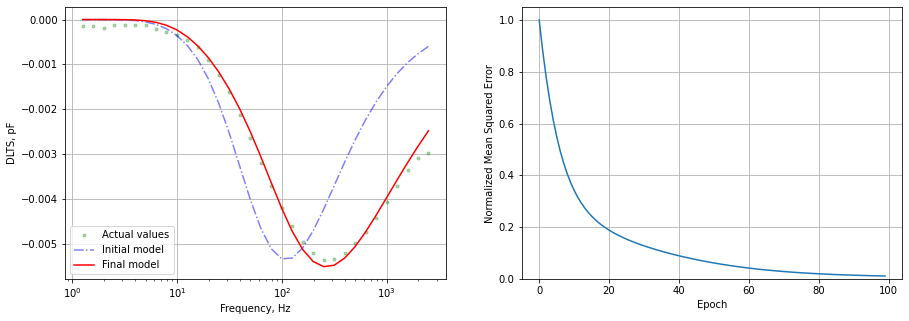

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.1979 log10(s)
Time constant = 6.3396e-03 s
Amplitude = -1.0736e-02 pF
P = 1.0000
MSE = 7.1770e-06
RMSE = 2.6790e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -2.5671 log10(s)
Time constant = 2.7095e-03 s
Amplitude = -1.0960e-02 pF
P = 0.7274
MSE = 3.5925e-08
RMSE = 1.8954e-04


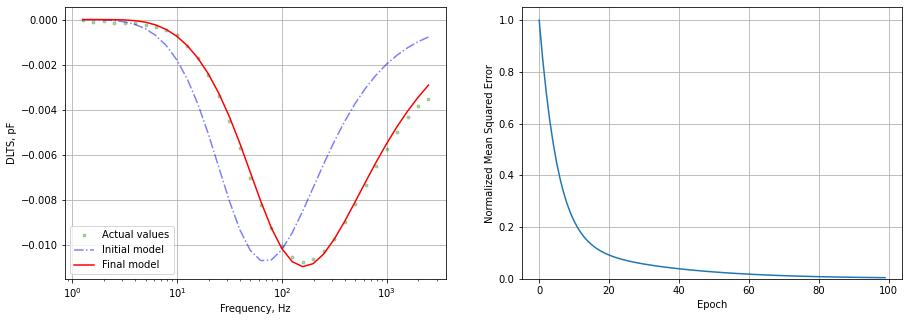

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.0979 log10(s)
Time constant = 7.9810e-03 s
Amplitude = -1.3258e-02 pF
P = 1.0000
MSE = 1.2686e-05
RMSE = 3.5617e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -2.5021 log10(s)
Time constant = 3.1474e-03 s
Amplitude = -1.3480e-02 pF
P = 0.7796
MSE = 3.4677e-08
RMSE = 1.8622e-04


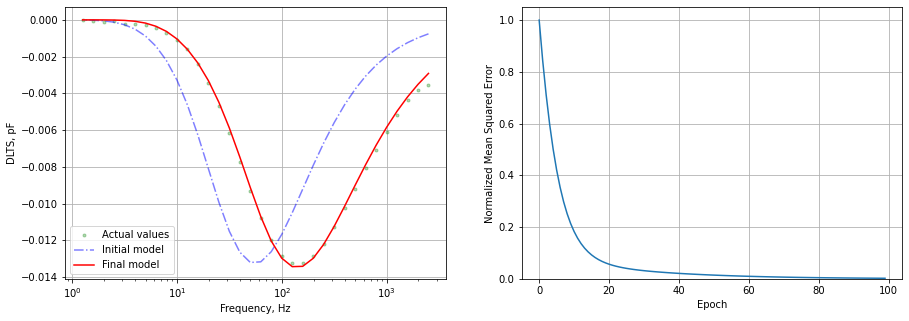

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.0979 log10(s)
Time constant = 7.9810e-03 s
Amplitude = -1.4520e-02 pF
P = 1.0000
MSE = 1.3612e-05
RMSE = 3.6894e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -2.4786 log10(s)
Time constant = 3.3223e-03 s
Amplitude = -1.4734e-02 pF
P = 0.8010
MSE = 3.5440e-08
RMSE = 1.8826e-04


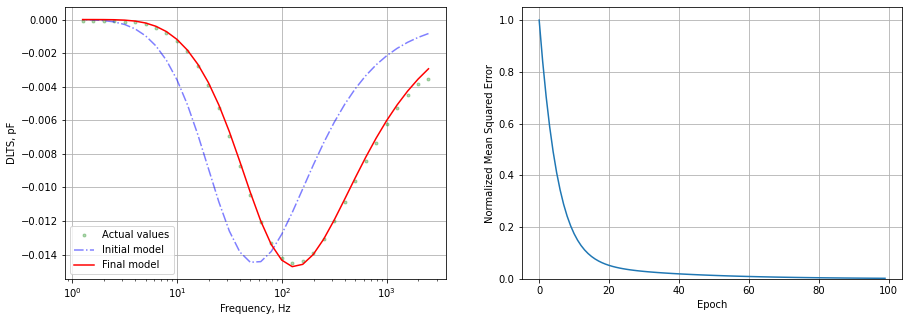

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.0979 log10(s)
Time constant = 7.9810e-03 s
Amplitude = -1.5016e-02 pF
P = 1.0000
MSE = 1.3470e-05
RMSE = 3.6702e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -2.4622 log10(s)
Time constant = 3.4496e-03 s
Amplitude = -1.5232e-02 pF
P = 0.8159
MSE = 3.7000e-08
RMSE = 1.9235e-04


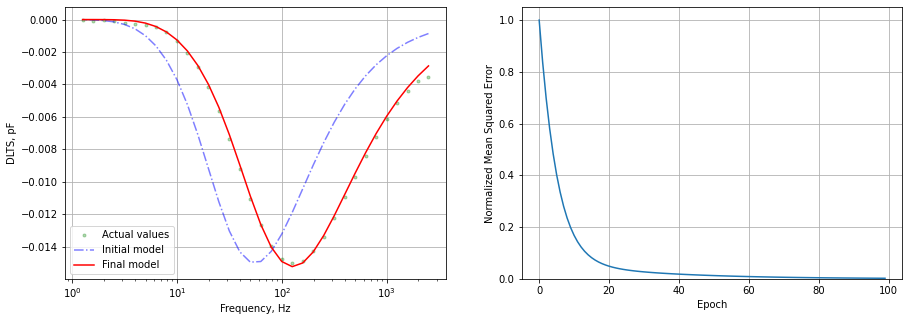

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.0979 log10(s)
Time constant = 7.9810e-03 s
Amplitude = -1.5214e-02 pF
P = 1.0000
MSE = 1.3093e-05
RMSE = 3.6184e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -2.4519 log10(s)
Time constant = 3.5330e-03 s
Amplitude = -1.5420e-02 pF
P = 0.8248
MSE = 3.4594e-08
RMSE = 1.8599e-04


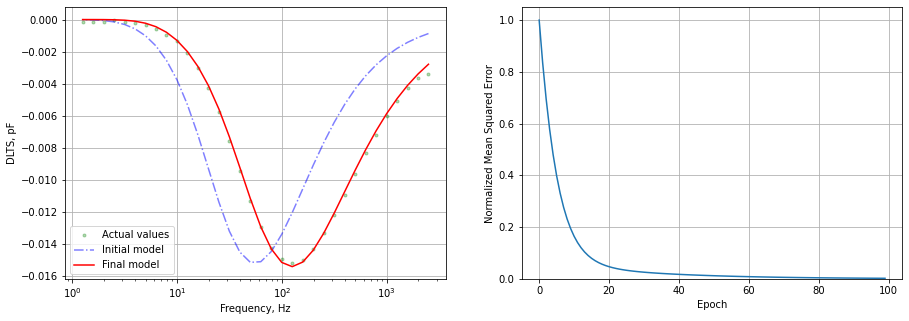

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.0979 log10(s)
Time constant = 7.9810e-03 s
Amplitude = -1.5258e-02 pF
P = 1.0000
MSE = 1.2523e-05
RMSE = 3.5388e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -2.4423 log10(s)
Time constant = 3.6120e-03 s
Amplitude = -1.5457e-02 pF
P = 0.8303
MSE = 3.4031e-08
RMSE = 1.8448e-04


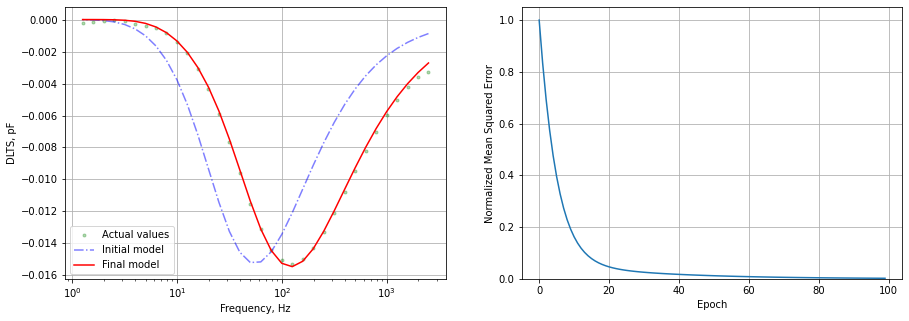

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.0979 log10(s)
Time constant = 7.9810e-03 s
Amplitude = -1.5160e-02 pF
P = 1.0000
MSE = 1.2072e-05
RMSE = 3.4745e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -2.4385 log10(s)
Time constant = 3.6435e-03 s
Amplitude = -1.5344e-02 pF
P = 0.8385
MSE = 3.1272e-08
RMSE = 1.7684e-04


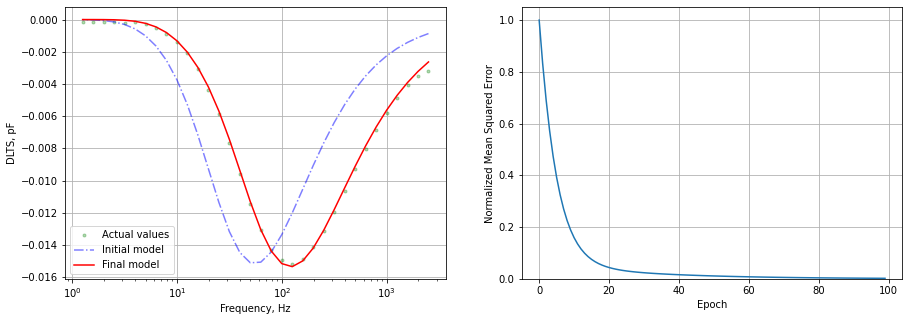

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.0979 log10(s)
Time constant = 7.9810e-03 s
Amplitude = -1.3002e-02 pF
P = 1.0000
MSE = 9.1634e-06
RMSE = 3.0271e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -2.4450 log10(s)
Time constant = 3.5892e-03 s
Amplitude = -1.3154e-02 pF
P = 0.8326
MSE = 2.5290e-08
RMSE = 1.5903e-04


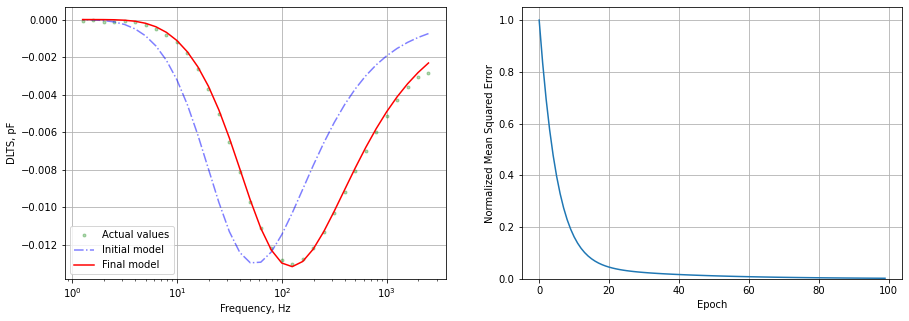

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.0979 log10(s)
Time constant = 7.9810e-03 s
Amplitude = -1.3078e-02 pF
P = 1.0000
MSE = 9.2915e-06
RMSE = 3.0482e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -2.4444 log10(s)
Time constant = 3.5944e-03 s
Amplitude = -1.3244e-02 pF
P = 0.8284
MSE = 2.7149e-08
RMSE = 1.6477e-04


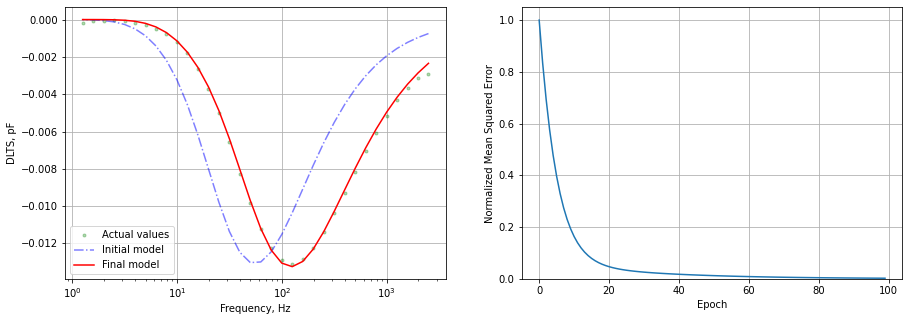

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.0979 log10(s)
Time constant = 7.9810e-03 s
Amplitude = -1.3134e-02 pF
P = 1.0000
MSE = 9.0299e-06
RMSE = 3.0050e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -2.4370 log10(s)
Time constant = 3.6561e-03 s
Amplitude = -1.3305e-02 pF
P = 0.8320
MSE = 2.6330e-08
RMSE = 1.6226e-04


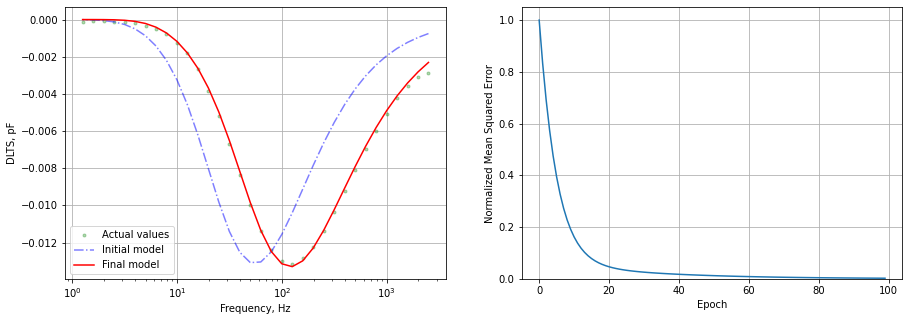

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.5979 log10(s)
Time constant = 2.5238e-03 s
Amplitude = -2.7620e-03 pF
P = 1.0000
MSE = 3.7009e-07
RMSE = 6.0835e-04

Final values
Filling pulse = 2.0000e-05
Time constant power = -2.8955 log10(s)
Time constant = 1.2720e-03 s
Amplitude = -2.8507e-03 pF
P = 0.5315
MSE = 8.8057e-09
RMSE = 9.3839e-05


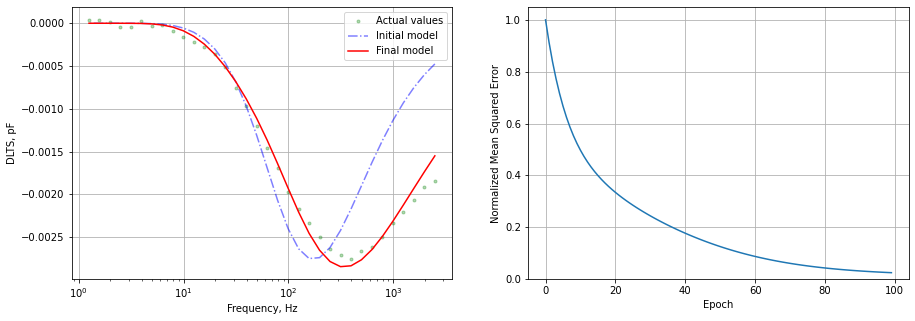

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.2979 log10(s)
Time constant = 5.0357e-03 s
Amplitude = -6.9270e-03 pF
P = 1.0000
MSE = 2.2822e-06
RMSE = 1.5107e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -2.6076 log10(s)
Time constant = 2.4681e-03 s
Amplitude = -7.0927e-03 pF
P = 0.6919
MSE = 1.8344e-08
RMSE = 1.3544e-04


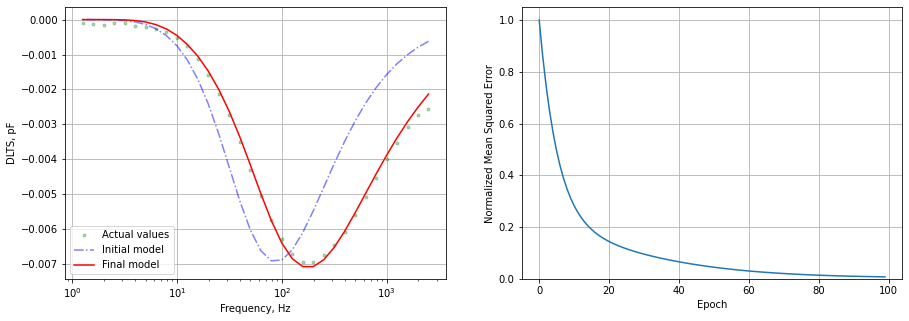

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.1979 log10(s)
Time constant = 6.3396e-03 s
Amplitude = -9.6000e-03 pF
P = 1.0000
MSE = 4.8156e-06
RMSE = 2.1944e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -2.5335 log10(s)
Time constant = 2.9275e-03 s
Amplitude = -9.7753e-03 pF
P = 0.7545
MSE = 2.3852e-08
RMSE = 1.5444e-04


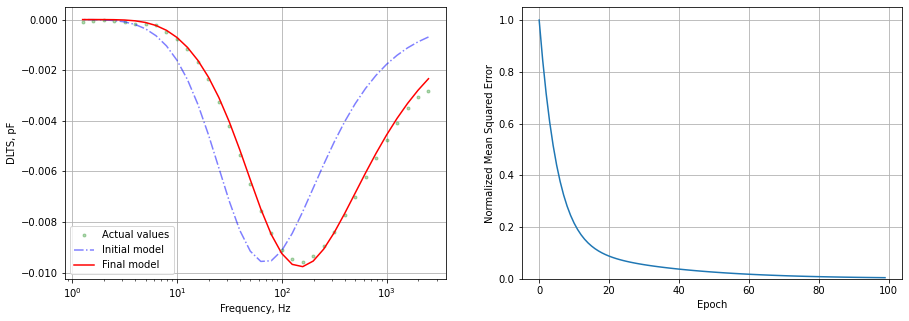

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.0979 log10(s)
Time constant = 7.9810e-03 s
Amplitude = -1.1052e-02 pF
P = 1.0000
MSE = 8.6999e-06
RMSE = 2.9496e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -2.4972 log10(s)
Time constant = 3.1830e-03 s
Amplitude = -1.1255e-02 pF
P = 0.7735
MSE = 2.3972e-08
RMSE = 1.5483e-04


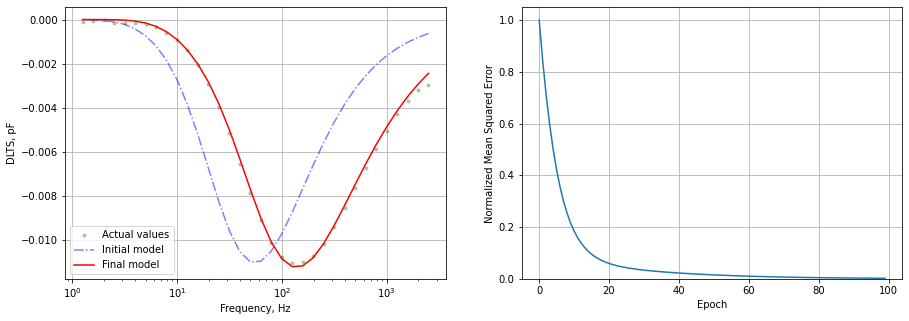

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.0979 log10(s)
Time constant = 7.9810e-03 s
Amplitude = -1.1976e-02 pF
P = 1.0000
MSE = 9.2643e-06
RMSE = 3.0437e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -2.4776 log10(s)
Time constant = 3.3295e-03 s
Amplitude = -1.2167e-02 pF
P = 0.7943
MSE = 2.5579e-08
RMSE = 1.5993e-04


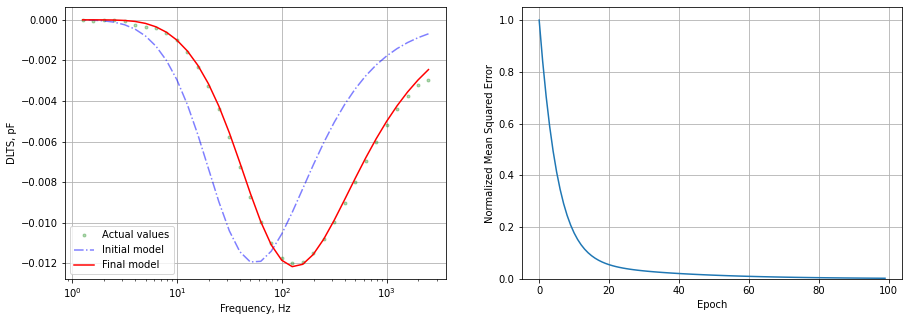

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.0979 log10(s)
Time constant = 7.9810e-03 s
Amplitude = -1.2558e-02 pF
P = 1.0000
MSE = 9.3389e-06
RMSE = 3.0560e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -2.4614 log10(s)
Time constant = 3.4562e-03 s
Amplitude = -1.2724e-02 pF
P = 0.8158
MSE = 3.0308e-08
RMSE = 1.7409e-04


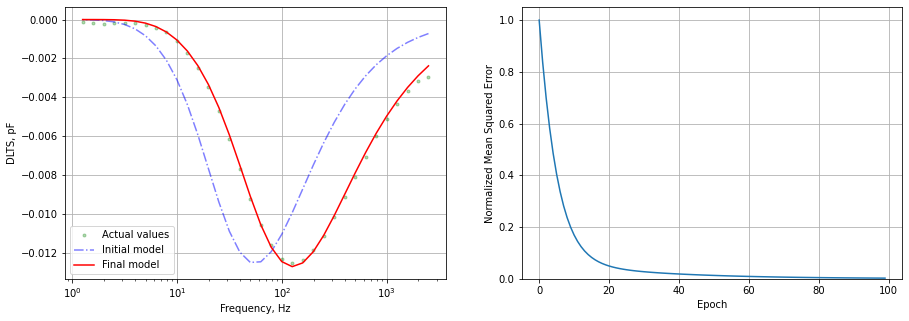

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.0979 log10(s)
Time constant = 7.9810e-03 s
Amplitude = -1.2826e-02 pF
P = 1.0000
MSE = 9.4101e-06
RMSE = 3.0676e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -2.4543 log10(s)
Time constant = 3.5132e-03 s
Amplitude = -1.2997e-02 pF
P = 0.8219
MSE = 2.5808e-08
RMSE = 1.6065e-04


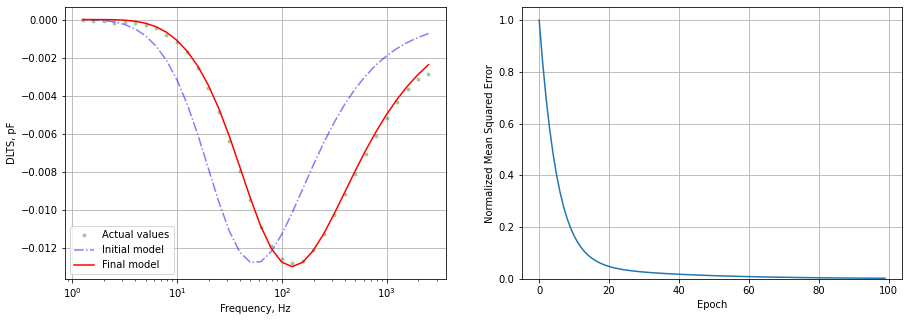

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.0979 log10(s)
Time constant = 7.9810e-03 s
Amplitude = -1.0960e-02 pF
P = 1.0000
MSE = 7.2022e-06
RMSE = 2.6837e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -2.4623 log10(s)
Time constant = 3.4494e-03 s
Amplitude = -1.1125e-02 pF
P = 0.8090
MSE = 2.0566e-08
RMSE = 1.4341e-04


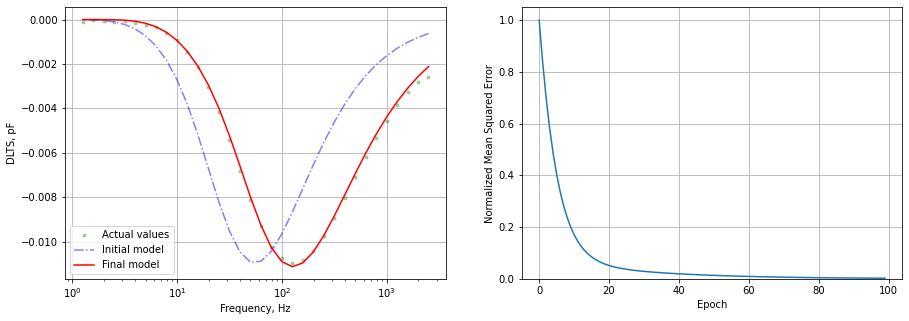

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.0979 log10(s)
Time constant = 7.9810e-03 s
Amplitude = -1.1350e-02 pF
P = 1.0000
MSE = 7.4011e-06
RMSE = 2.7205e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -2.4557 log10(s)
Time constant = 3.5022e-03 s
Amplitude = -1.1492e-02 pF
P = 0.8255
MSE = 2.0912e-08
RMSE = 1.4461e-04


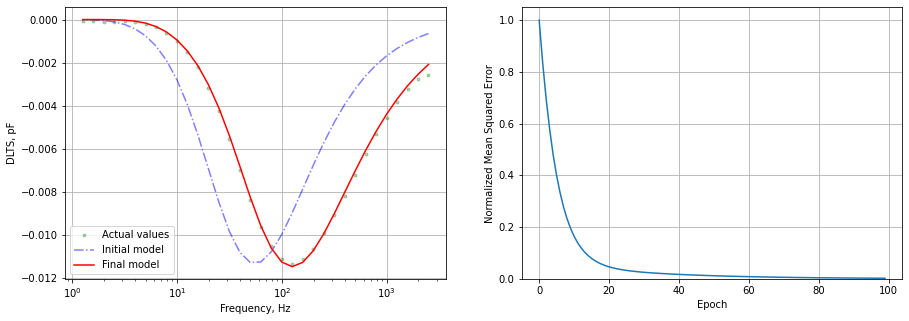

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.0979 log10(s)
Time constant = 7.9810e-03 s
Amplitude = -1.1548e-02 pF
P = 1.0000
MSE = 7.4781e-06
RMSE = 2.7346e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -2.4503 log10(s)
Time constant = 3.5455e-03 s
Amplitude = -1.1701e-02 pF
P = 0.8213
MSE = 2.1128e-08
RMSE = 1.4536e-04


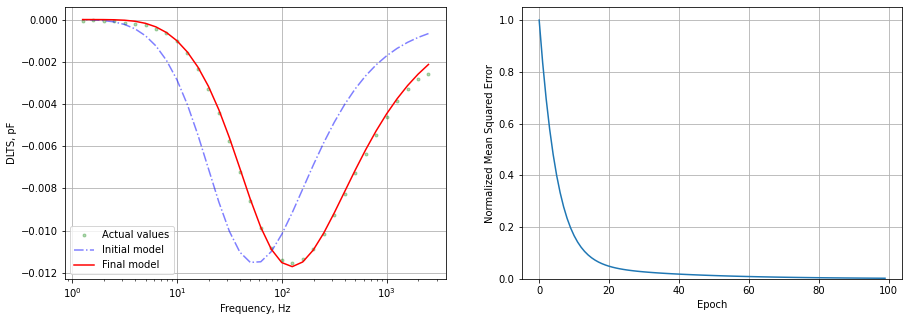

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.6979 log10(s)
Time constant = 2.0047e-03 s
Amplitude = -1.6814e-03 pF
P = 1.0000
MSE = 1.3412e-07
RMSE = 3.6622e-04

Final values
Filling pulse = 2.0000e-05
Time constant power = -2.9757 log10(s)
Time constant = 1.0575e-03 s
Amplitude = -1.7461e-03 pF
P = 0.4908
MSE = 4.7467e-09
RMSE = 6.8897e-05


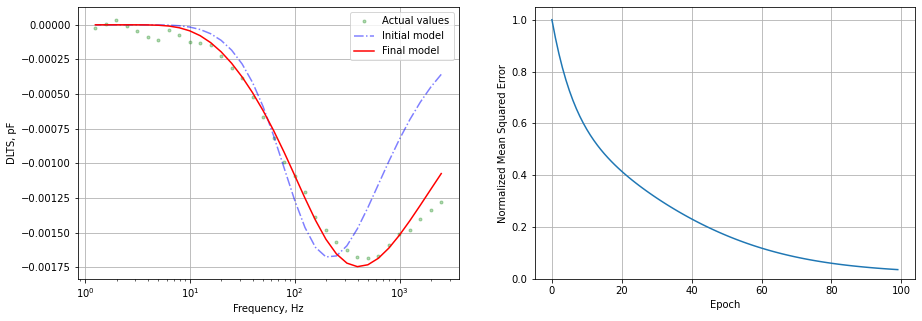

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.2979 log10(s)
Time constant = 5.0357e-03 s
Amplitude = -4.7865e-03 pF
P = 1.0000
MSE = 1.4064e-06
RMSE = 1.1859e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -2.6577 log10(s)
Time constant = 2.1993e-03 s
Amplitude = -4.9198e-03 pF
P = 0.6561
MSE = 9.2761e-09
RMSE = 9.6313e-05


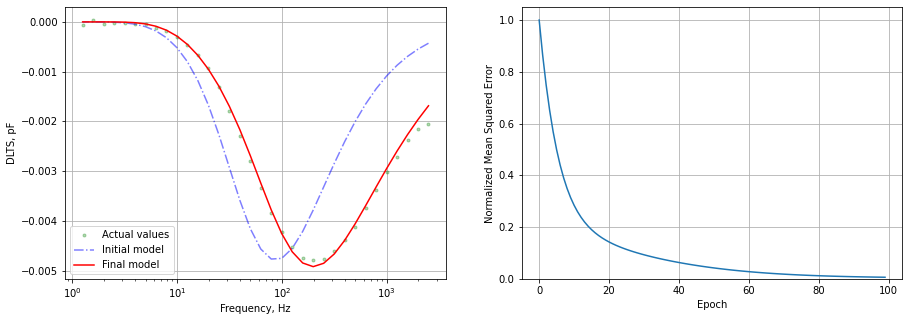

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.1979 log10(s)
Time constant = 6.3396e-03 s
Amplitude = -7.2750e-03 pF
P = 1.0000
MSE = 3.1101e-06
RMSE = 1.7635e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -2.5541 log10(s)
Time constant = 2.7918e-03 s
Amplitude = -7.4260e-03 pF
P = 0.7244
MSE = 1.8529e-08
RMSE = 1.3612e-04


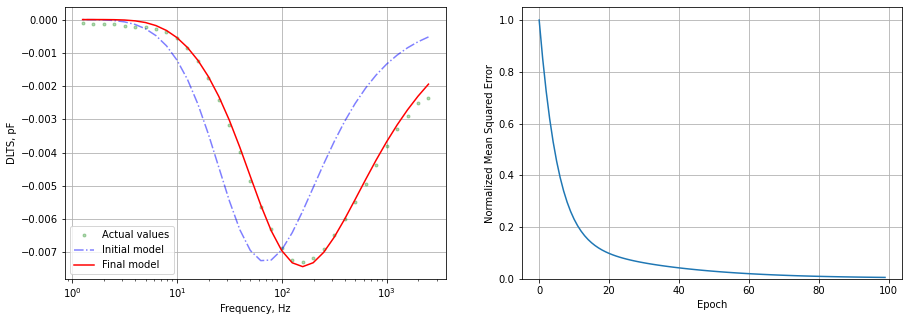

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.0979 log10(s)
Time constant = 7.9810e-03 s
Amplitude = -8.8520e-03 pF
P = 1.0000
MSE = 5.9101e-06
RMSE = 2.4311e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -2.5119 log10(s)
Time constant = 3.0769e-03 s
Amplitude = -9.0050e-03 pF
P = 0.7680
MSE = 1.8587e-08
RMSE = 1.3633e-04


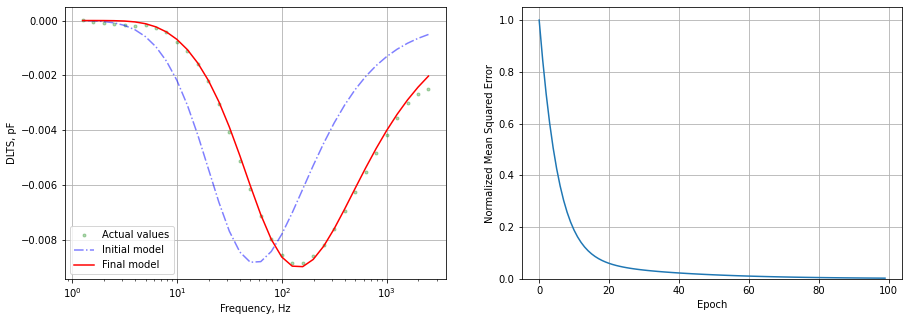

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.0979 log10(s)
Time constant = 7.9810e-03 s
Amplitude = -9.8680e-03 pF
P = 1.0000
MSE = 6.6395e-06
RMSE = 2.5767e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -2.4893 log10(s)
Time constant = 3.2409e-03 s
Amplitude = -1.0028e-02 pF
P = 0.7850
MSE = 2.0171e-08
RMSE = 1.4202e-04


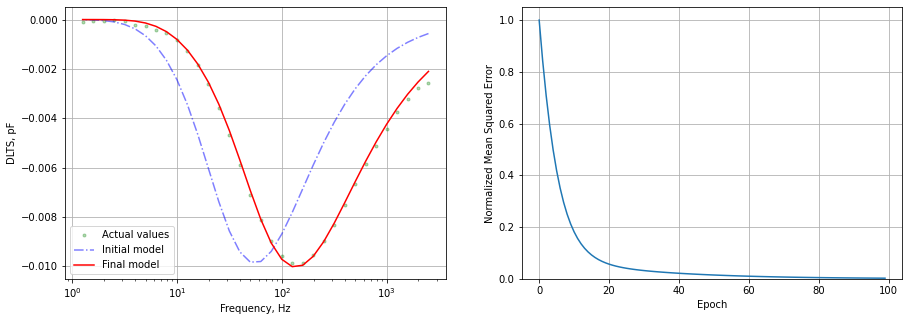

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.0979 log10(s)
Time constant = 7.9810e-03 s
Amplitude = -1.0516e-02 pF
P = 1.0000
MSE = 7.0212e-06
RMSE = 2.6498e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -2.4737 log10(s)
Time constant = 3.3595e-03 s
Amplitude = -1.0683e-02 pF
P = 0.7946
MSE = 2.2104e-08
RMSE = 1.4867e-04


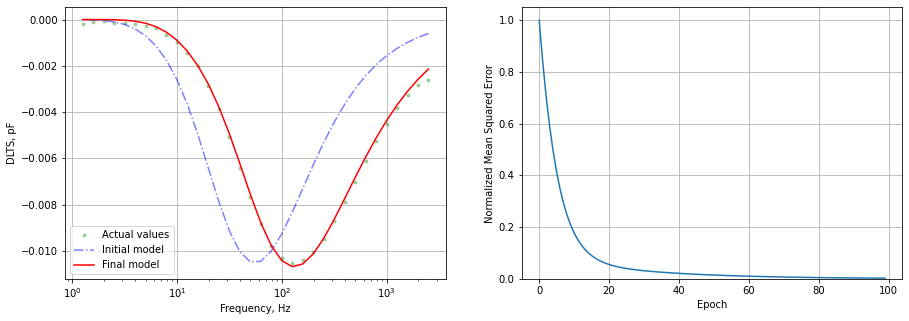

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.0979 log10(s)
Time constant = 7.9810e-03 s
Amplitude = -9.0160e-03 pF
P = 1.0000
MSE = 5.3792e-06
RMSE = 2.3193e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -2.4826 log10(s)
Time constant = 3.2914e-03 s
Amplitude = -9.1584e-03 pF
P = 0.7903
MSE = 1.8402e-08
RMSE = 1.3565e-04


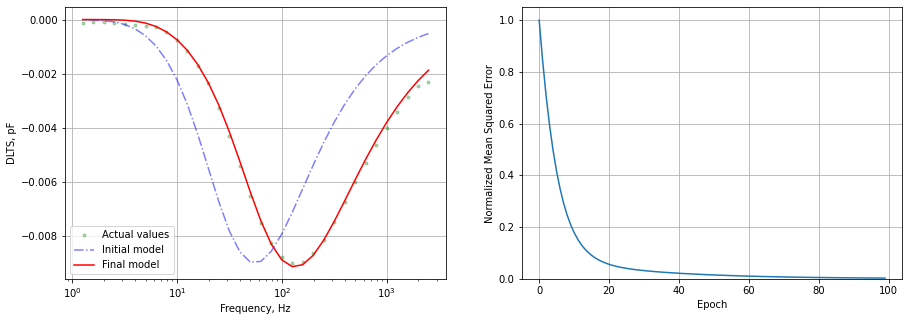

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.0979 log10(s)
Time constant = 7.9810e-03 s
Amplitude = -9.5840e-03 pF
P = 1.0000
MSE = 5.7384e-06
RMSE = 2.3955e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -2.4708 log10(s)
Time constant = 3.3826e-03 s
Amplitude = -9.7292e-03 pF
P = 0.8002
MSE = 1.7955e-08
RMSE = 1.3399e-04


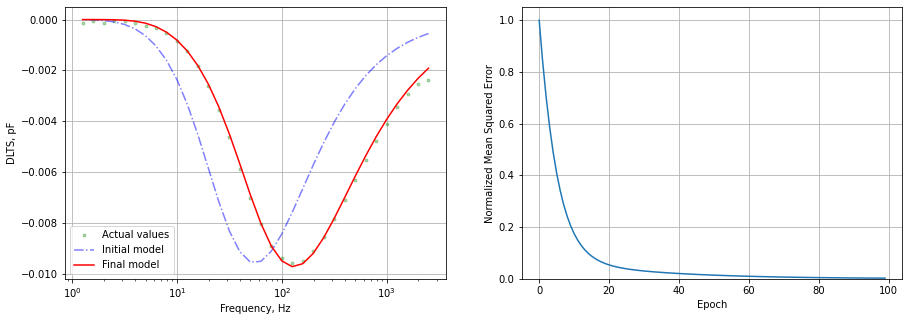

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.0979 log10(s)
Time constant = 7.9810e-03 s
Amplitude = -1.0004e-02 pF
P = 1.0000
MSE = 6.0076e-06
RMSE = 2.4510e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -2.4636 log10(s)
Time constant = 3.4391e-03 s
Amplitude = -1.0142e-02 pF
P = 0.8082
MSE = 1.9215e-08
RMSE = 1.3862e-04


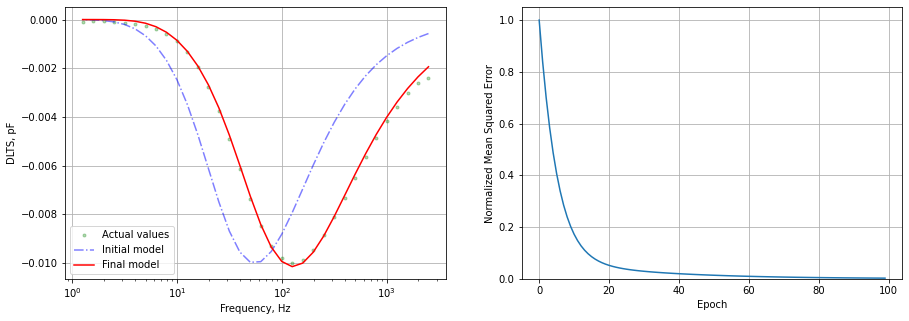

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.6979 log10(s)
Time constant = 2.0047e-03 s
Amplitude = -1.1045e-03 pF
P = 1.0000
MSE = 7.4467e-08
RMSE = 2.7289e-04

Final values
Filling pulse = 2.0000e-05
Time constant power = -3.0224 log10(s)
Time constant = 9.4973e-04 s
Amplitude = -1.1565e-03 pF
P = 0.4293
MSE = 3.3768e-09
RMSE = 5.8111e-05


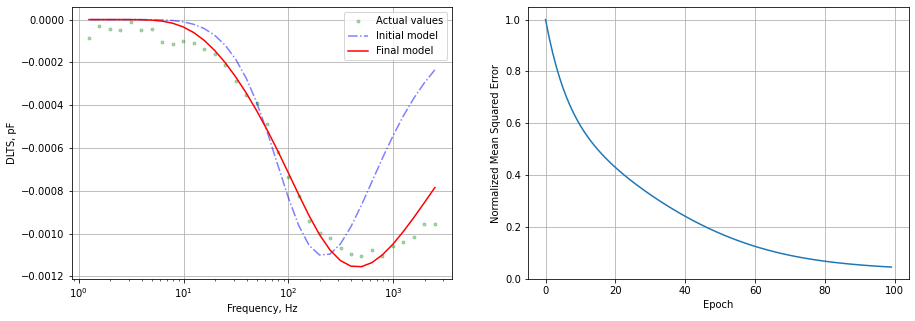

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.3979 log10(s)
Time constant = 4.0000e-03 s
Amplitude = -3.5305e-03 pF
P = 1.0000
MSE = 5.7463e-07
RMSE = 7.5805e-04

Final values
Filling pulse = 2.0000e-05
Time constant power = -2.6941 log10(s)
Time constant = 2.0226e-03 s
Amplitude = -3.6298e-03 pF
P = 0.6344
MSE = 6.8612e-09
RMSE = 8.2832e-05


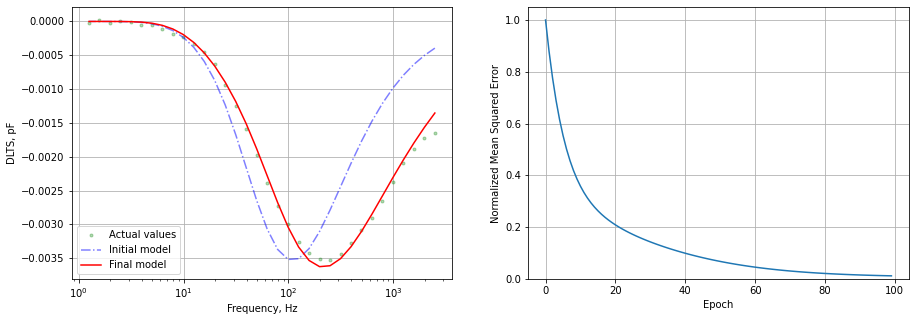

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.2979 log10(s)
Time constant = 5.0357e-03 s
Amplitude = -5.6970e-03 pF
P = 1.0000
MSE = 1.3219e-06
RMSE = 1.1497e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -2.5789 log10(s)
Time constant = 2.6367e-03 s
Amplitude = -5.8295e-03 pF
P = 0.7037
MSE = 1.2199e-08
RMSE = 1.1045e-04


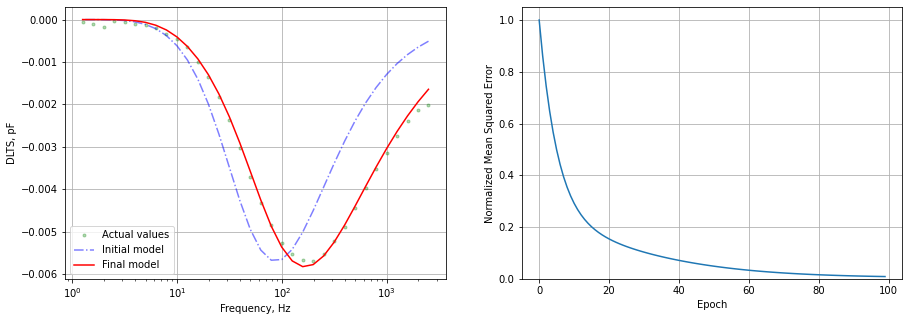

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.1979 log10(s)
Time constant = 6.3396e-03 s
Amplitude = -7.2960e-03 pF
P = 1.0000
MSE = 2.6973e-06
RMSE = 1.6423e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -2.5252 log10(s)
Time constant = 2.9841e-03 s
Amplitude = -7.4374e-03 pF
P = 0.7463
MSE = 1.9901e-08
RMSE = 1.4107e-04


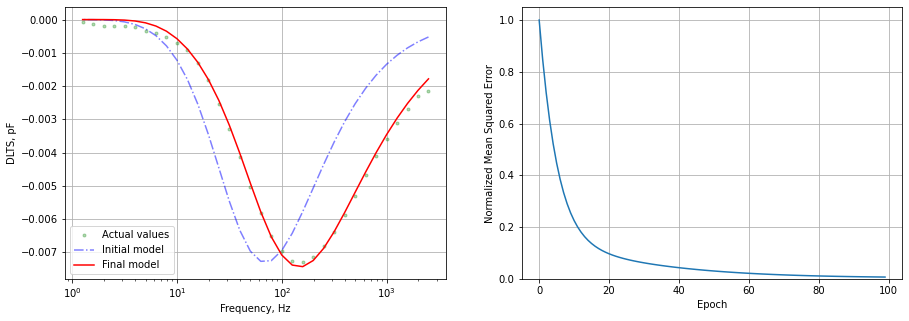

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.0979 log10(s)
Time constant = 7.9810e-03 s
Amplitude = -8.2260e-03 pF
P = 1.0000
MSE = 4.8997e-06
RMSE = 2.2135e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -2.5016 log10(s)
Time constant = 3.1505e-03 s
Amplitude = -8.3723e-03 pF
P = 0.7687
MSE = 1.5437e-08
RMSE = 1.2424e-04


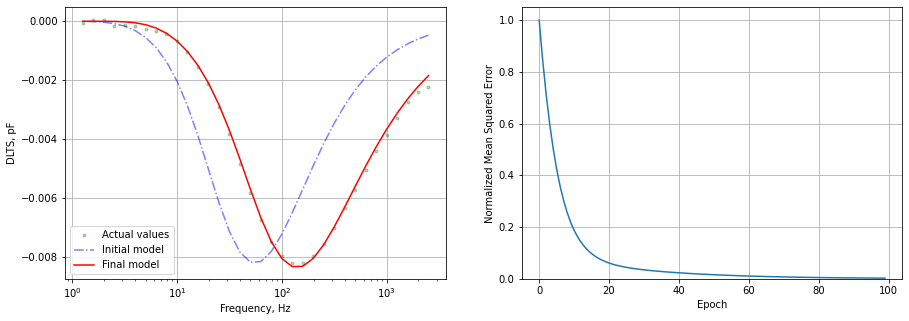

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.1979 log10(s)
Time constant = 6.3396e-03 s
Amplitude = -7.0660e-03 pF
P = 1.0000
MSE = 2.3195e-06
RMSE = 1.5230e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -2.5097 log10(s)
Time constant = 3.0923e-03 s
Amplitude = -7.1982e-03 pF
P = 0.7557
MSE = 1.5810e-08
RMSE = 1.2574e-04


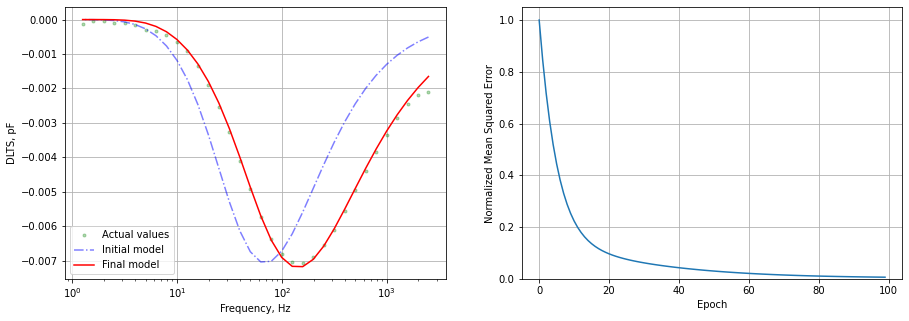

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.0979 log10(s)
Time constant = 7.9810e-03 s
Amplitude = -7.8340e-03 pF
P = 1.0000
MSE = 4.2701e-06
RMSE = 2.0664e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -2.4921 log10(s)
Time constant = 3.2202e-03 s
Amplitude = -7.9751e-03 pF
P = 0.7696
MSE = 1.3672e-08
RMSE = 1.1693e-04


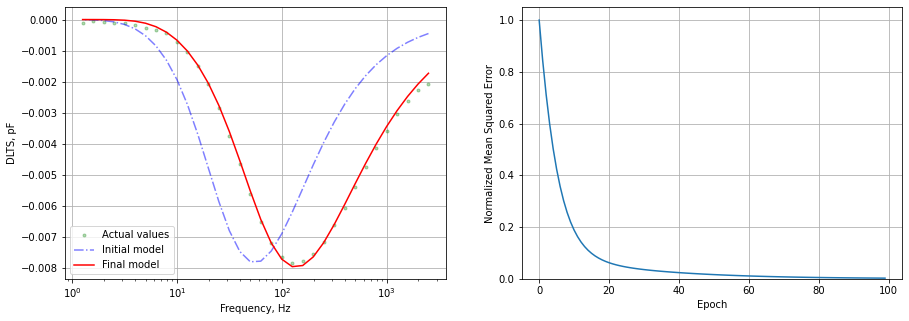

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.0979 log10(s)
Time constant = 7.9810e-03 s
Amplitude = -8.4440e-03 pF
P = 1.0000
MSE = 4.5927e-06
RMSE = 2.1431e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -2.4783 log10(s)
Time constant = 3.3240e-03 s
Amplitude = -8.5658e-03 pF
P = 0.7909
MSE = 1.5688e-08
RMSE = 1.2525e-04


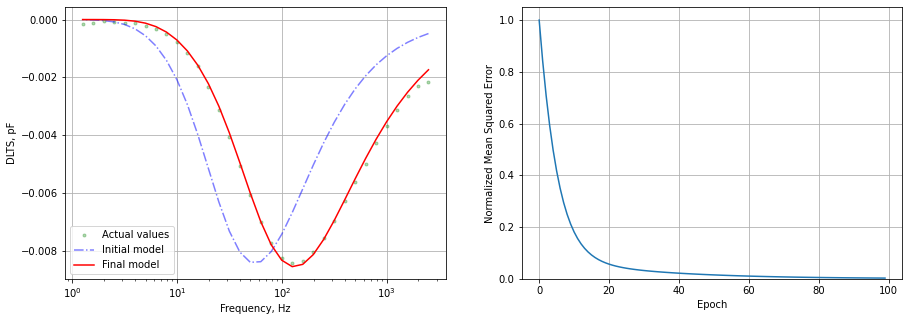

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.6979 log10(s)
Time constant = 2.0047e-03 s
Amplitude = -9.1520e-04 pF
P = 1.0000
MSE = 4.9417e-08
RMSE = 2.2230e-04

Final values
Filling pulse = 2.0000e-05
Time constant power = -3.0589 log10(s)
Time constant = 8.7318e-04 s
Amplitude = -9.2597e-04 pF
P = 0.5261
MSE = 5.9063e-09
RMSE = 7.6852e-05


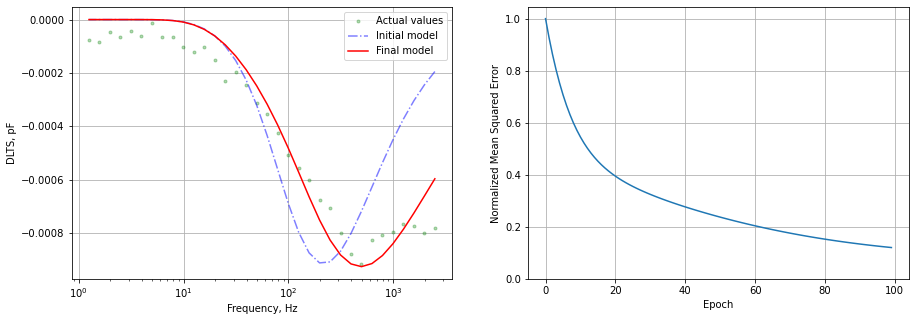

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.3979 log10(s)
Time constant = 4.0000e-03 s
Amplitude = -2.6880e-03 pF
P = 1.0000
MSE = 4.0630e-07
RMSE = 6.3741e-04

Final values
Filling pulse = 2.0000e-05
Time constant power = -2.7324 log10(s)
Time constant = 1.8518e-03 s
Amplitude = -2.7736e-03 pF
P = 0.6068
MSE = 4.1226e-09
RMSE = 6.4208e-05


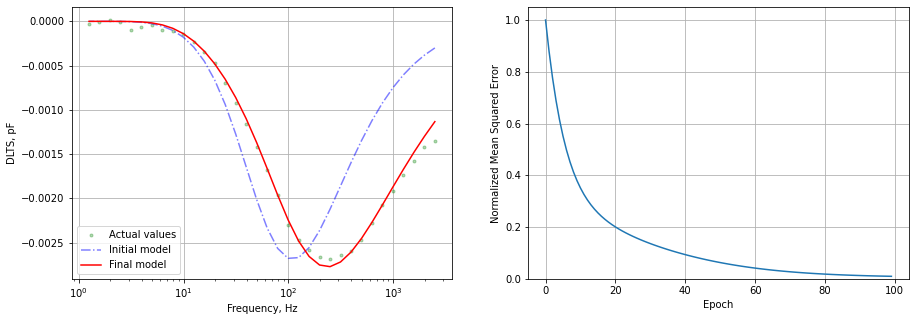

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.2979 log10(s)
Time constant = 5.0357e-03 s
Amplitude = -4.5890e-03 pF
P = 1.0000
MSE = 9.5986e-07
RMSE = 9.7972e-04

Final values
Filling pulse = 2.0000e-05
Time constant power = -2.5967 log10(s)
Time constant = 2.5313e-03 s
Amplitude = -4.7004e-03 pF
P = 0.6826
MSE = 9.9974e-09
RMSE = 9.9987e-05


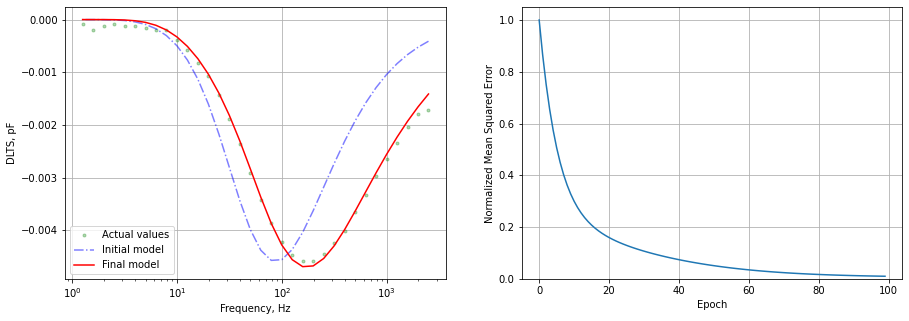

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.1979 log10(s)
Time constant = 6.3396e-03 s
Amplitude = -5.9950e-03 pF
P = 1.0000
MSE = 2.0295e-06
RMSE = 1.4246e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -2.5413 log10(s)
Time constant = 2.8752e-03 s
Amplitude = -6.1399e-03 pF
P = 0.7157
MSE = 1.1850e-08
RMSE = 1.0886e-04


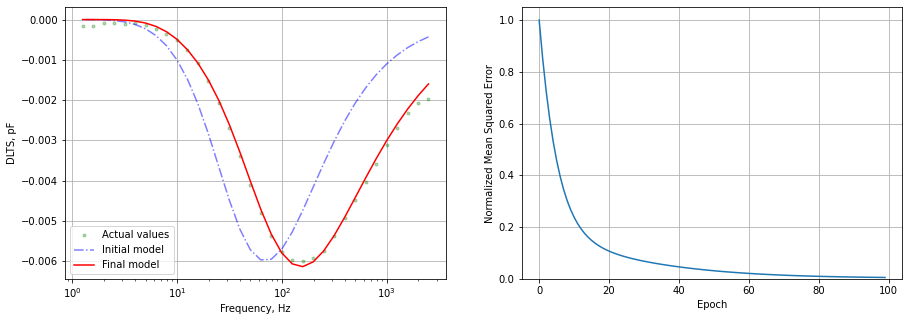

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.1979 log10(s)
Time constant = 6.3396e-03 s
Amplitude = -5.1180e-03 pF
P = 1.0000
MSE = 1.5194e-06
RMSE = 1.2326e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -2.5512 log10(s)
Time constant = 2.8106e-03 s
Amplitude = -5.2213e-03 pF
P = 0.7209
MSE = 1.1017e-08
RMSE = 1.0496e-04


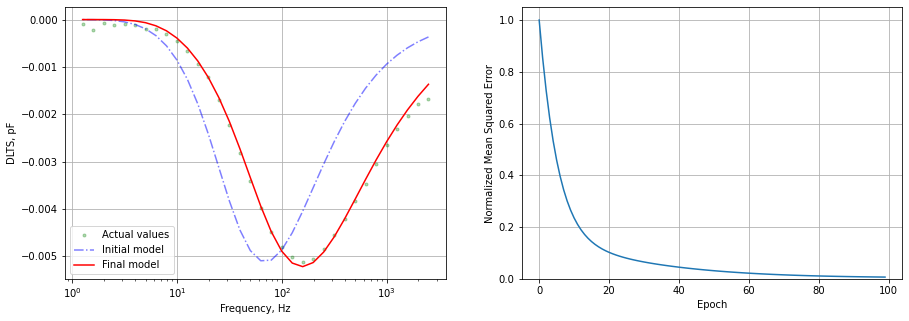

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.1979 log10(s)
Time constant = 6.3396e-03 s
Amplitude = -6.0760e-03 pF
P = 1.0000
MSE = 1.8423e-06
RMSE = 1.3573e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -2.5220 log10(s)
Time constant = 3.0064e-03 s
Amplitude = -6.1974e-03 pF
P = 0.7438
MSE = 1.0816e-08
RMSE = 1.0400e-04


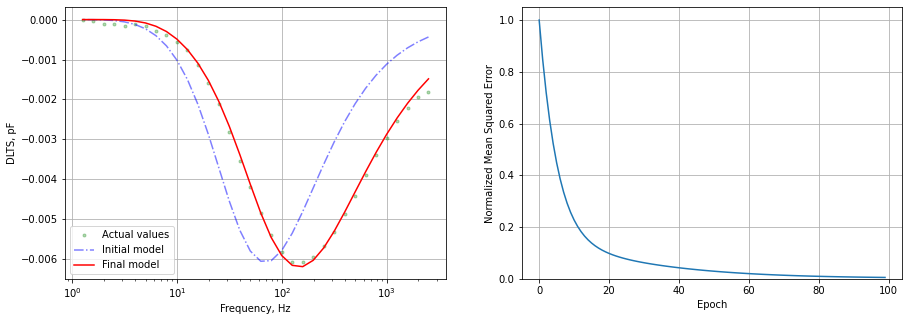

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.0979 log10(s)
Time constant = 7.9810e-03 s
Amplitude = -6.8830e-03 pF
P = 1.0000
MSE = 3.3036e-06
RMSE = 1.8176e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -2.4928 log10(s)
Time constant = 3.2154e-03 s
Amplitude = -7.0054e-03 pF
P = 0.7307
MSE = 1.8118e-08
RMSE = 1.3460e-04


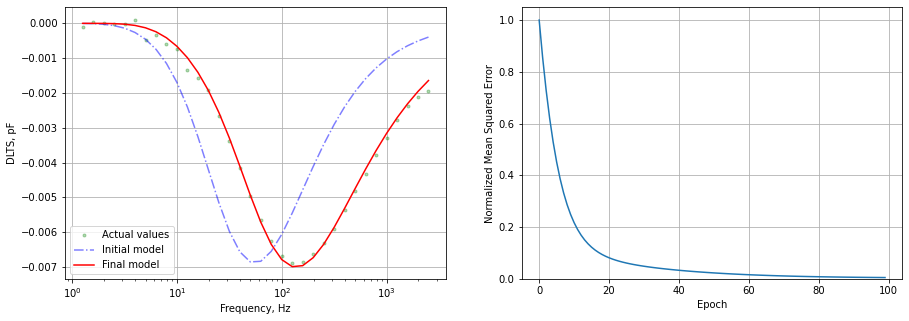

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -3.1979 log10(s)
Time constant = 6.3396e-04 s
Amplitude = -6.5640e-04 pF
P = 1.0000
MSE = 2.0693e-08
RMSE = 1.4385e-04

Final values
Filling pulse = 2.0000e-05
Time constant power = -3.1440 log10(s)
Time constant = 7.1782e-04 s
Amplitude = -6.7870e-04 pF
P = 0.4217
MSE = 4.8052e-09
RMSE = 6.9319e-05


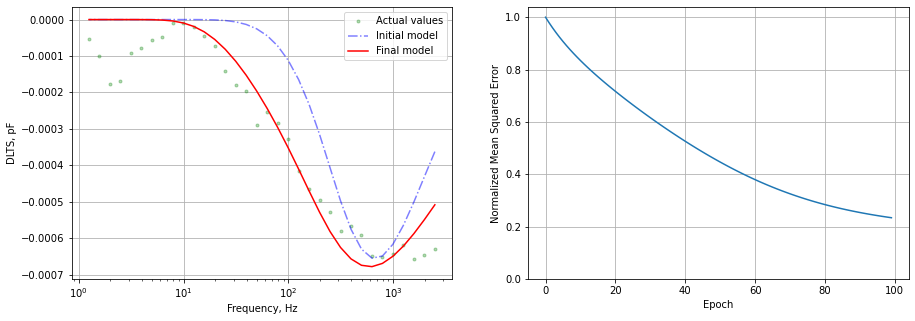

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.3979 log10(s)
Time constant = 4.0000e-03 s
Amplitude = -2.0865e-03 pF
P = 1.0000
MSE = 2.8380e-07
RMSE = 5.3273e-04

Final values
Filling pulse = 2.0000e-05
Time constant power = -2.7603 log10(s)
Time constant = 1.7365e-03 s
Amplitude = -2.1597e-03 pF
P = 0.5621
MSE = 4.4563e-09
RMSE = 6.6755e-05


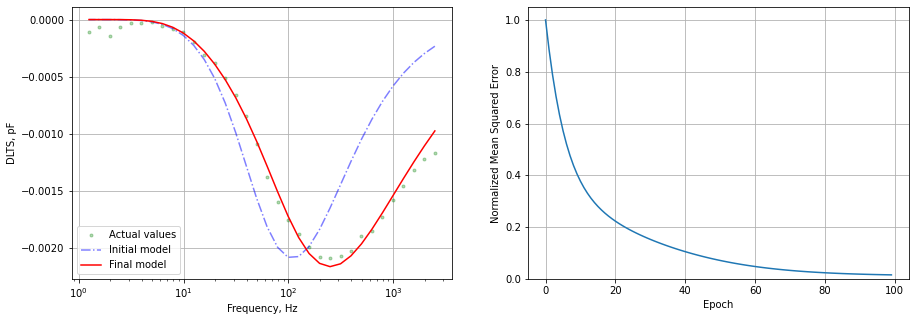

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.2979 log10(s)
Time constant = 5.0357e-03 s
Amplitude = -3.7660e-03 pF
P = 1.0000
MSE = 7.3322e-07
RMSE = 8.5628e-04

Final values
Filling pulse = 2.0000e-05
Time constant power = -2.6169 log10(s)
Time constant = 2.4159e-03 s
Amplitude = -3.8644e-03 pF
P = 0.6537
MSE = 9.7486e-09
RMSE = 9.8735e-05


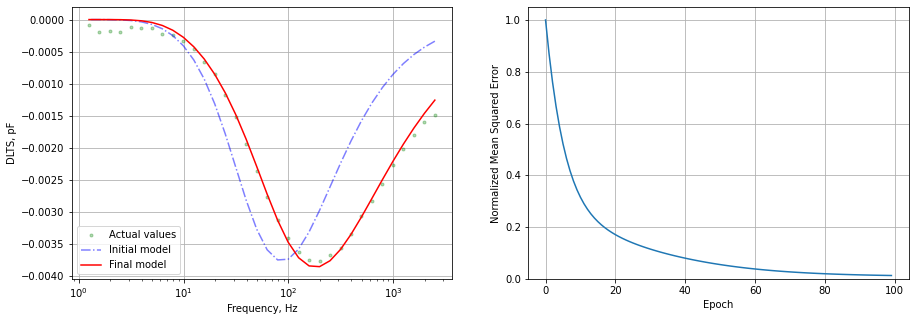

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.2979 log10(s)
Time constant = 5.0357e-03 s
Amplitude = -3.1630e-03 pF
P = 1.0000
MSE = 5.5104e-07
RMSE = 7.4232e-04

Final values
Filling pulse = 2.0000e-05
Time constant power = -2.6386 log10(s)
Time constant = 2.2984e-03 s
Amplitude = -3.2332e-03 pF
P = 0.6658
MSE = 6.1912e-09
RMSE = 7.8684e-05


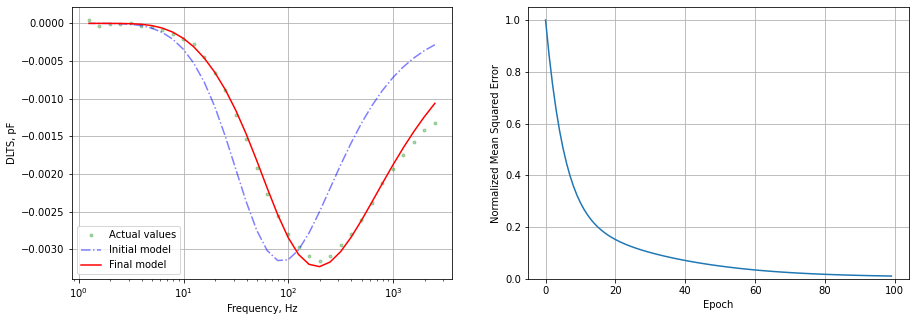

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.1979 log10(s)
Time constant = 6.3396e-03 s
Amplitude = -4.3910e-03 pF
P = 1.0000
MSE = 1.1932e-06
RMSE = 1.0923e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -2.5620 log10(s)
Time constant = 2.7414e-03 s
Amplitude = -4.4900e-03 pF
P = 0.7008
MSE = 8.8476e-09
RMSE = 9.4062e-05


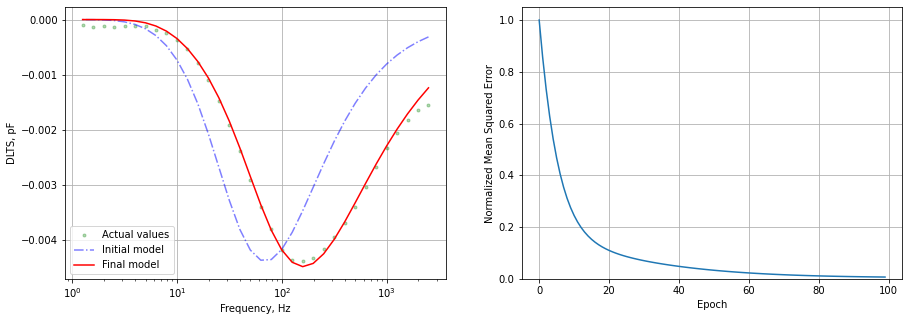

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.0979 log10(s)
Time constant = 7.9810e-03 s
Amplitude = -5.2820e-03 pF
P = 1.0000
MSE = 2.3045e-06
RMSE = 1.5181e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -2.5306 log10(s)
Time constant = 2.9470e-03 s
Amplitude = -5.3939e-03 pF
P = 0.7314
MSE = 8.4170e-09
RMSE = 9.1744e-05


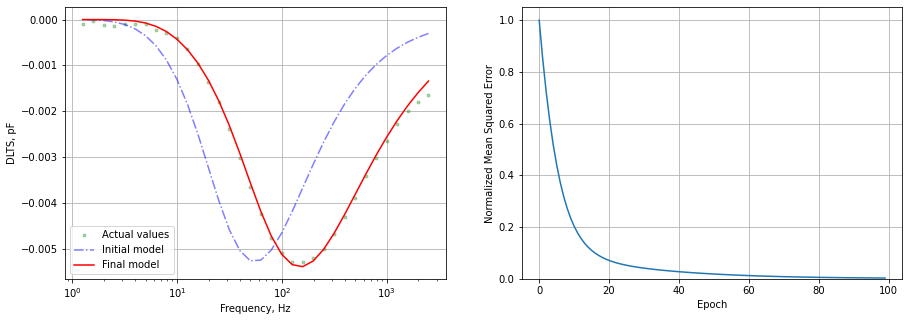

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.9979 log10(s)
Time constant = 1.0048e-03 s
Amplitude = -5.7430e-04 pF
P = 1.0000
MSE = 1.2253e-08
RMSE = 1.1069e-04

Final values
Filling pulse = 2.0000e-05
Time constant power = -3.1796 log10(s)
Time constant = 6.6123e-04 s
Amplitude = -5.8934e-04 pF
P = 0.5072
MSE = 2.9075e-09
RMSE = 5.3921e-05


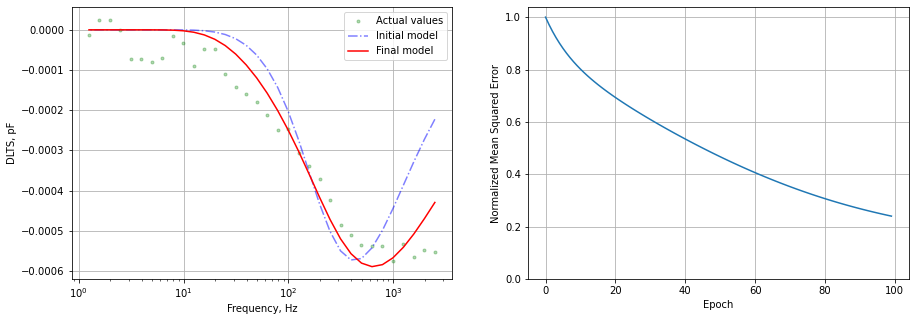

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.4979 log10(s)
Time constant = 3.1773e-03 s
Amplitude = -1.6940e-03 pF
P = 1.0000
MSE = 1.3967e-07
RMSE = 3.7373e-04

Final values
Filling pulse = 2.0000e-05
Time constant power = -2.7839 log10(s)
Time constant = 1.6448e-03 s
Amplitude = -1.7469e-03 pF
P = 0.5324
MSE = 3.1234e-09
RMSE = 5.5887e-05


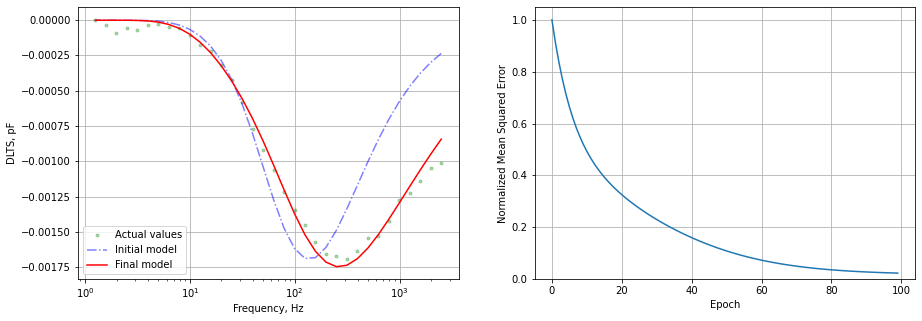

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.5979 log10(s)
Time constant = 2.5238e-03 s
Amplitude = -1.4222e-03 pF
P = 1.0000
MSE = 8.2544e-08
RMSE = 2.8730e-04

Final values
Filling pulse = 2.0000e-05
Time constant power = -2.8211 log10(s)
Time constant = 1.5098e-03 s
Amplitude = -1.4787e-03 pF
P = 0.5124
MSE = 2.0919e-09
RMSE = 4.5738e-05


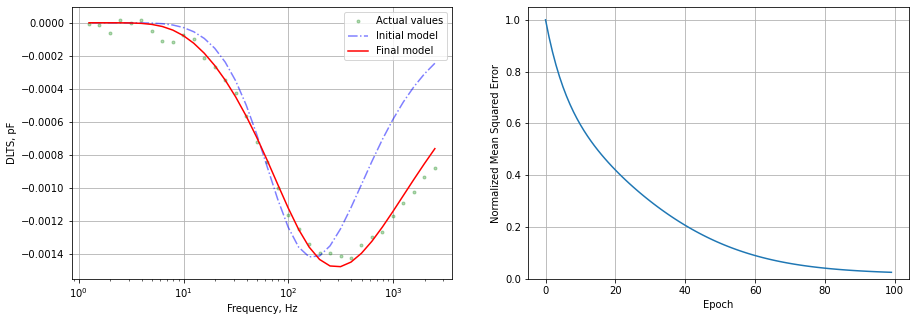

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.2979 log10(s)
Time constant = 5.0357e-03 s
Amplitude = -2.6560e-03 pF
P = 1.0000
MSE = 4.4696e-07
RMSE = 6.6855e-04

Final values
Filling pulse = 2.0000e-05
Time constant power = -2.6662 log10(s)
Time constant = 2.1566e-03 s
Amplitude = -2.7223e-03 pF
P = 0.6424
MSE = 4.5560e-09
RMSE = 6.7498e-05


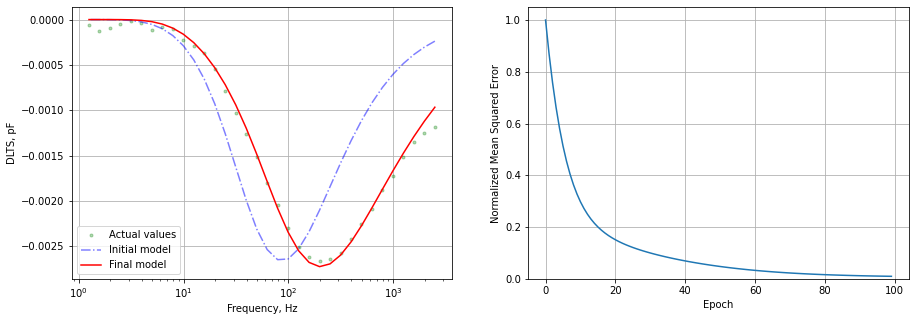

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.2979 log10(s)
Time constant = 5.0357e-03 s
Amplitude = -3.7740e-03 pF
P = 1.0000
MSE = 5.9341e-07
RMSE = 7.7033e-04

Final values
Filling pulse = 2.0000e-05
Time constant power = -2.5777 log10(s)
Time constant = 2.6444e-03 s
Amplitude = -3.8665e-03 pF
P = 0.6794
MSE = 6.8466e-09
RMSE = 8.2744e-05


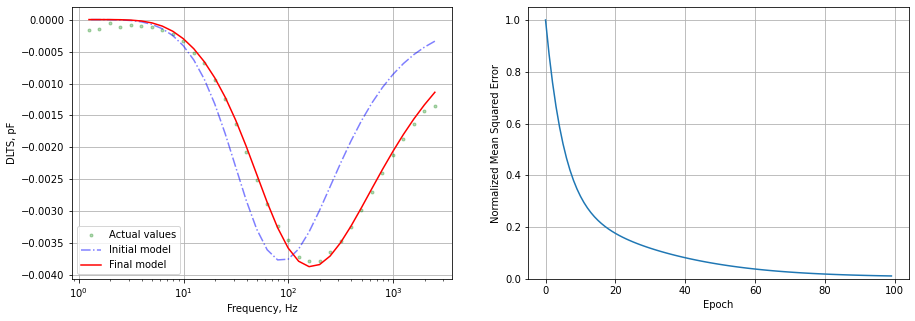

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -3.1979 log10(s)
Time constant = 6.3396e-04 s
Amplitude = -5.1510e-04 pF
P = 1.0000
MSE = 8.3695e-09
RMSE = 9.1485e-05

Final values
Filling pulse = 2.0000e-05
Time constant power = -3.2090 log10(s)
Time constant = 6.1798e-04 s
Amplitude = -5.2743e-04 pF
P = 0.5136
MSE = 2.4717e-09
RMSE = 4.9716e-05


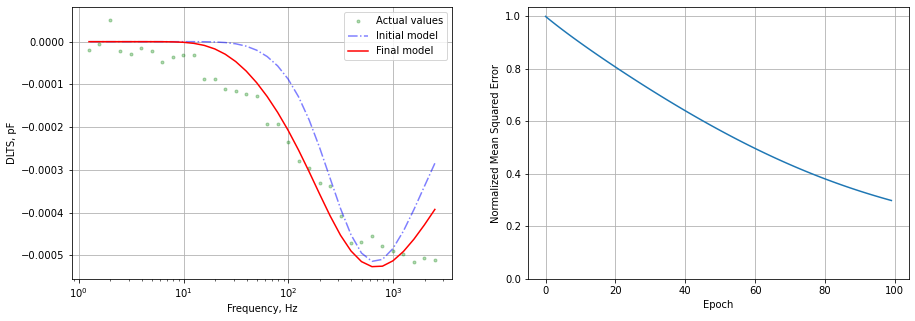

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -3.0979 log10(s)
Time constant = 7.9810e-04 s
Amplitude = -4.1400e-04 pF
P = 1.0000
MSE = 5.6595e-09
RMSE = 7.5229e-05

Final values
Filling pulse = 2.0000e-05
Time constant power = -3.1907 log10(s)
Time constant = 6.4457e-04 s
Amplitude = -4.1903e-04 pF
P = 0.5536
MSE = 2.4283e-09
RMSE = 4.9277e-05


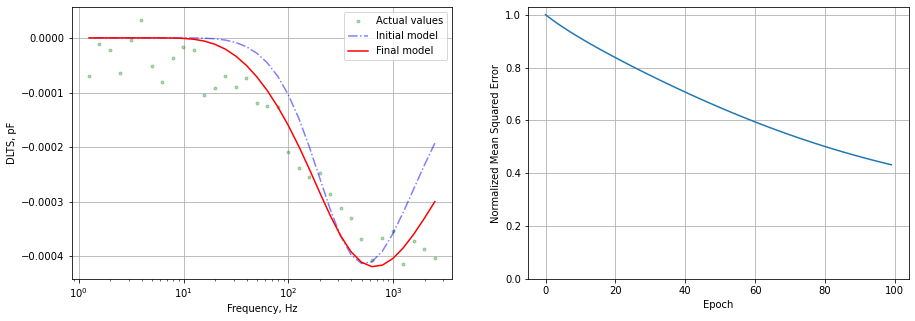

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.3979 log10(s)
Time constant = 4.0000e-03 s
Amplitude = -1.1595e-03 pF
P = 1.0000
MSE = 1.2709e-07
RMSE = 3.5650e-04

Final values
Filling pulse = 2.0000e-05
Time constant power = -2.8601 log10(s)
Time constant = 1.3801e-03 s
Amplitude = -1.2048e-03 pF
P = 0.4600
MSE = 1.7282e-09
RMSE = 4.1571e-05


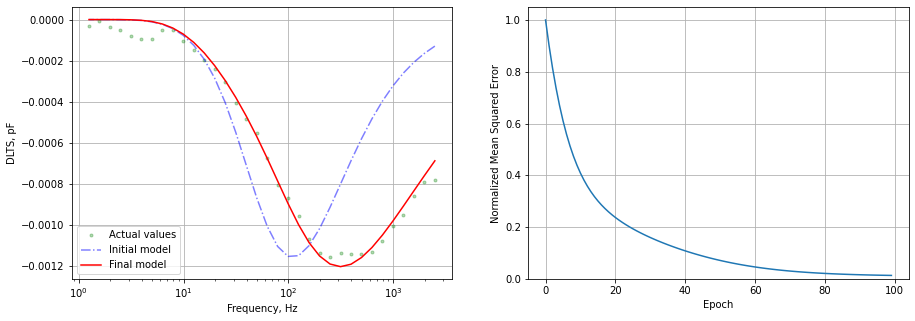

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.2979 log10(s)
Time constant = 5.0357e-03 s
Amplitude = -2.2695e-03 pF
P = 1.0000
MSE = 3.3886e-07
RMSE = 5.8212e-04

Final values
Filling pulse = 2.0000e-05
Time constant power = -2.6722 log10(s)
Time constant = 2.1274e-03 s
Amplitude = -2.3324e-03 pF
P = 0.6330
MSE = 3.5585e-09
RMSE = 5.9653e-05


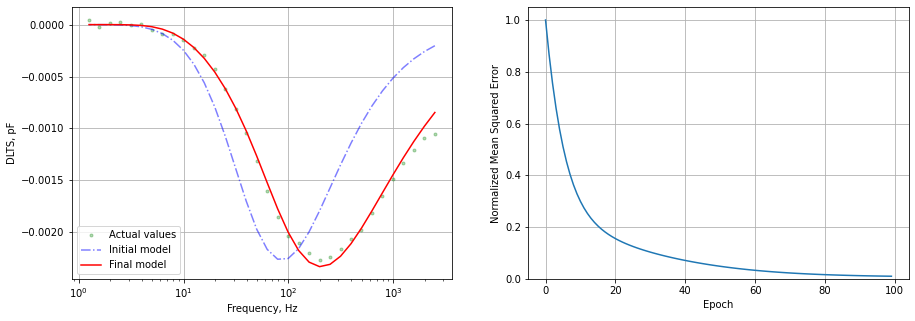

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -3.2979 log10(s)
Time constant = 5.0357e-04 s
Amplitude = -6.8710e-04 pF
P = 1.0000
MSE = 2.7038e-08
RMSE = 1.6443e-04

Final values
Filling pulse = 2.0000e-05
Time constant power = nan log10(s)
Time constant = nan s
Amplitude = nan pF
P = nan
MSE = nan
RMSE = nan


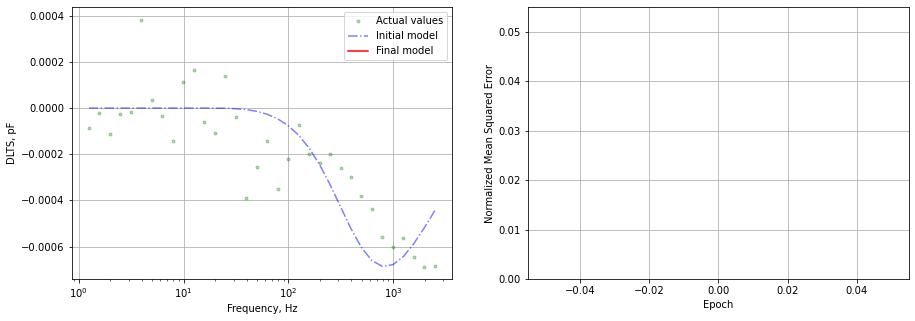

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -3.0979 log10(s)
Time constant = 7.9810e-04 s
Amplitude = -1.5580e-03 pF
P = 1.0000
MSE = 8.4319e-08
RMSE = 2.9038e-04

Final values
Filling pulse = 2.0000e-05
Time constant power = nan log10(s)
Time constant = nan s
Amplitude = nan pF
P = nan
MSE = nan
RMSE = nan


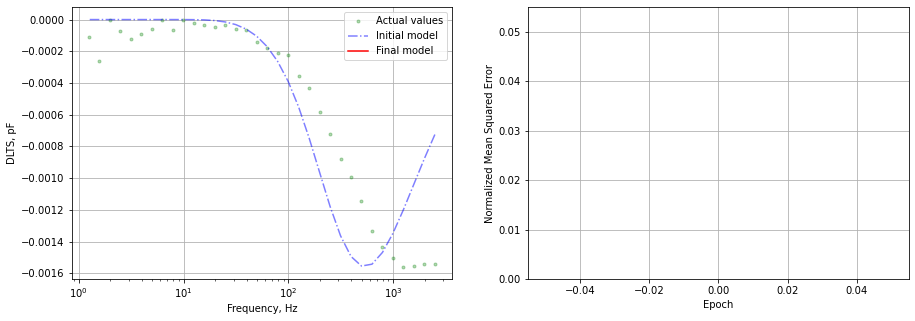

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -3.3979 log10(s)
Time constant = 4.0000e-04 s
Amplitude = -5.7340e-04 pF
P = 1.0000
MSE = 4.1537e-09
RMSE = 6.4449e-05

Final values
Filling pulse = 2.0000e-05
Time constant power = nan log10(s)
Time constant = nan s
Amplitude = nan pF
P = nan
MSE = nan
RMSE = nan


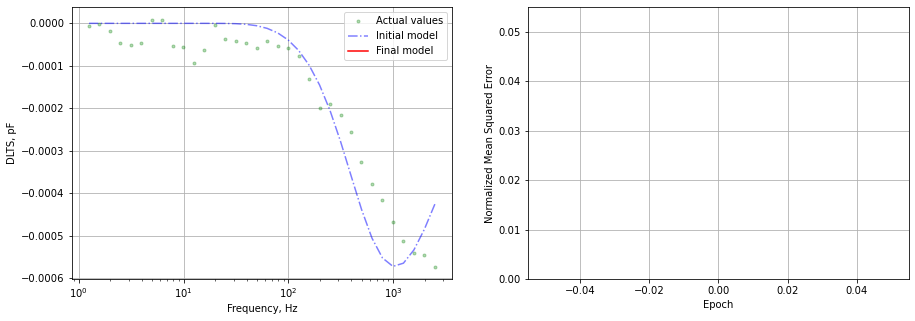

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.7979 log10(s)
Time constant = 1.5924e-03 s
Amplitude = -1.5814e-02 pF
P = 1.0000
MSE = 1.2572e-05
RMSE = 3.5457e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -3.1577 log10(s)
Time constant = 6.9546e-04 s
Amplitude = -1.6019e-02 pF
P = 0.8805
MSE = 1.6888e-07
RMSE = 4.1094e-04


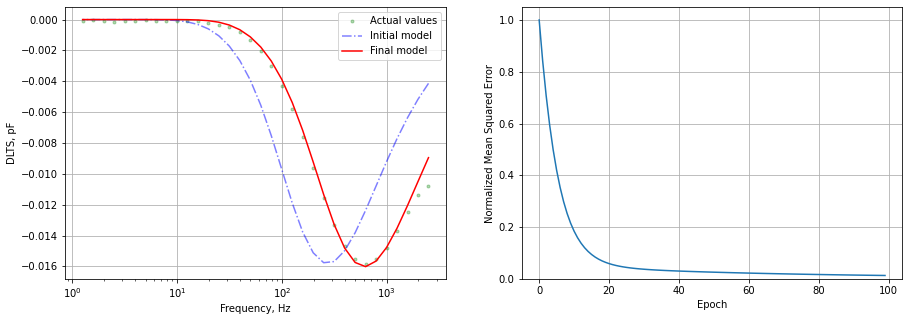

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.7979 log10(s)
Time constant = 1.5924e-03 s
Amplitude = -1.5654e-02 pF
P = 1.0000
MSE = 1.2041e-05
RMSE = 3.4700e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -3.1528 log10(s)
Time constant = 7.0339e-04 s
Amplitude = -1.5856e-02 pF
P = 0.8819
MSE = 1.6337e-07
RMSE = 4.0419e-04


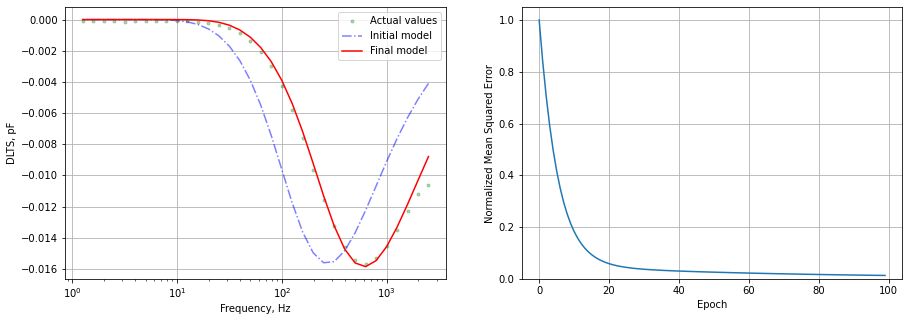

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.7979 log10(s)
Time constant = 1.5924e-03 s
Amplitude = -1.5378e-02 pF
P = 1.0000
MSE = 1.1535e-05
RMSE = 3.3963e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -3.1506 log10(s)
Time constant = 7.0691e-04 s
Amplitude = -1.5592e-02 pF
P = 0.8796
MSE = 1.5385e-07
RMSE = 3.9223e-04


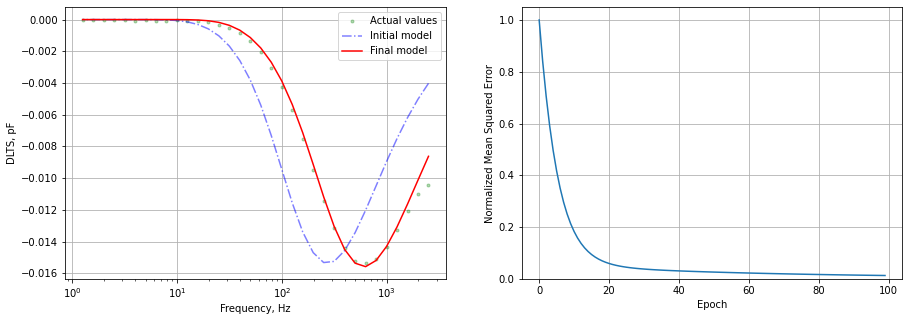

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -3.1010 log10(s)
Time constant = 7.9245e-04 s
Amplitude = -8.2330e-03 pF
P = 1.0000
MSE = 1.4204e-06
RMSE = 1.1918e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = nan log10(s)
Time constant = nan s
Amplitude = nan pF
P = nan
MSE = nan
RMSE = nan


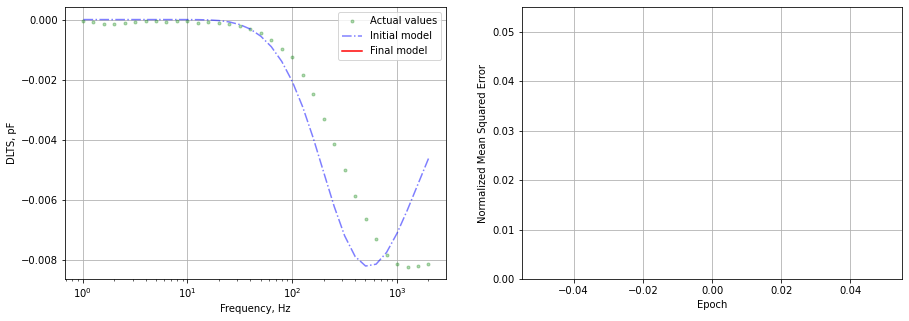

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.9010 log10(s)
Time constant = 1.2559e-03 s
Amplitude = -1.3380e-02 pF
P = 1.0000
MSE = 7.4667e-06
RMSE = 2.7325e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = nan log10(s)
Time constant = nan s
Amplitude = nan pF
P = nan
MSE = nan
RMSE = nan


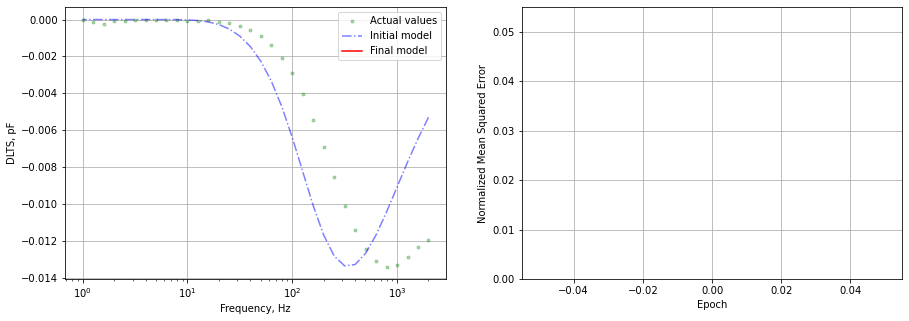

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.9010 log10(s)
Time constant = 1.2559e-03 s
Amplitude = -1.5372e-02 pF
P = 1.0000
MSE = 8.0059e-06
RMSE = 2.8295e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -3.2015 log10(s)
Time constant = 6.2872e-04 s
Amplitude = -1.5627e-02 pF
P = 0.8983
MSE = 2.5716e-07
RMSE = 5.0711e-04


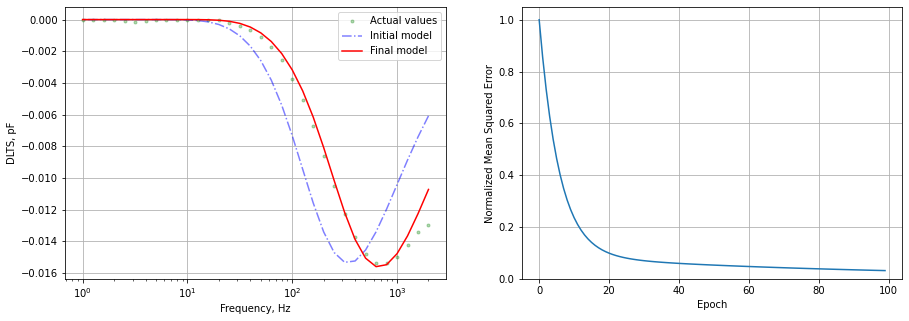

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.8010 log10(s)
Time constant = 1.5811e-03 s
Amplitude = -1.6144e-02 pF
P = 1.0000
MSE = 1.3949e-05
RMSE = 3.7348e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -3.1804 log10(s)
Time constant = 6.6015e-04 s
Amplitude = -1.6370e-02 pF
P = 0.9016
MSE = 2.5876e-07
RMSE = 5.0868e-04


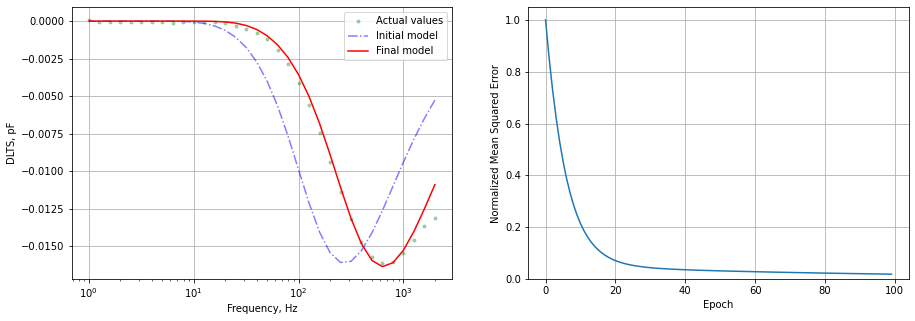

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.8010 log10(s)
Time constant = 1.5811e-03 s
Amplitude = -1.6346e-02 pF
P = 1.0000
MSE = 1.3451e-05
RMSE = 3.6676e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -3.1675 log10(s)
Time constant = 6.7991e-04 s
Amplitude = -1.6556e-02 pF
P = 0.9060
MSE = 2.3737e-07
RMSE = 4.8721e-04


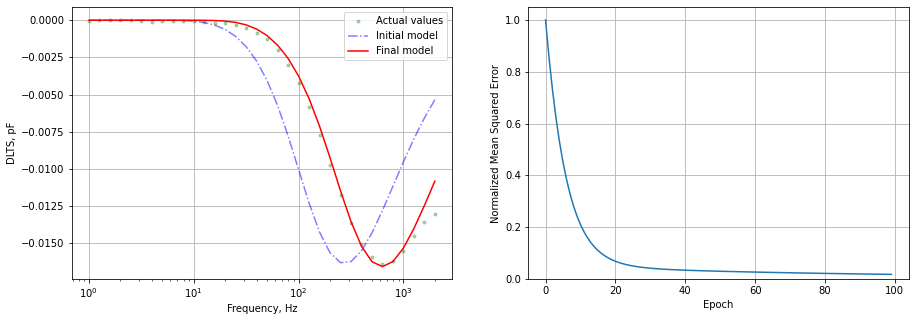

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.7979 log10(s)
Time constant = 1.5924e-03 s
Amplitude = -1.6402e-02 pF
P = 1.0000
MSE = 1.4587e-05
RMSE = 3.8192e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -3.1731 log10(s)
Time constant = 6.7128e-04 s
Amplitude = -1.6629e-02 pF
P = 0.8778
MSE = 1.9511e-07
RMSE = 4.4171e-04


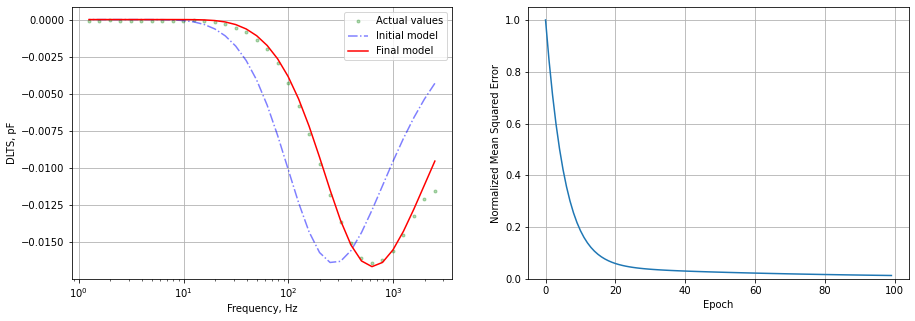

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.7979 log10(s)
Time constant = 1.5924e-03 s
Amplitude = -1.6230e-02 pF
P = 1.0000
MSE = 1.3813e-05
RMSE = 3.7166e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -3.1654 log10(s)
Time constant = 6.8332e-04 s
Amplitude = -1.6470e-02 pF
P = 0.8751
MSE = 1.8744e-07
RMSE = 4.3294e-04


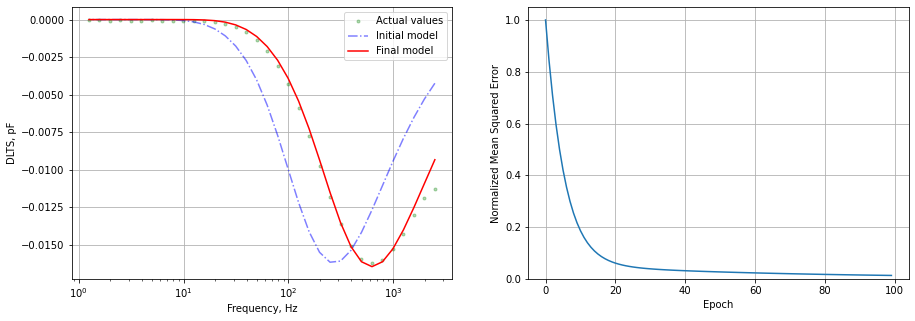

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.7979 log10(s)
Time constant = 1.5924e-03 s
Amplitude = -1.6062e-02 pF
P = 1.0000
MSE = 1.3239e-05
RMSE = 3.6386e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -3.1609 log10(s)
Time constant = 6.9033e-04 s
Amplitude = -1.6278e-02 pF
P = 0.8815
MSE = 1.8035e-07
RMSE = 4.2467e-04


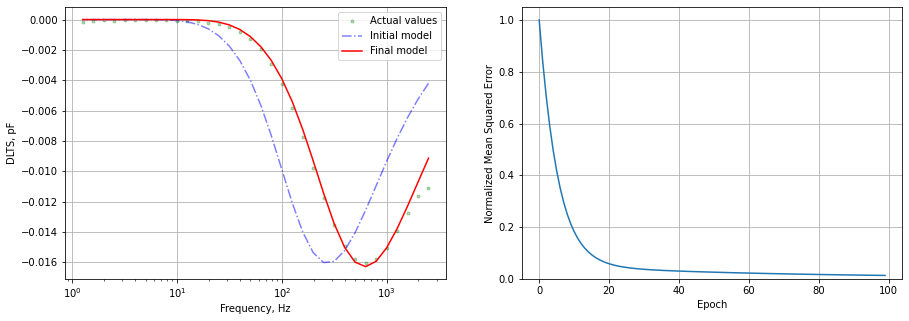

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.7979 log10(s)
Time constant = 1.5924e-03 s
Amplitude = -1.3840e-02 pF
P = 1.0000
MSE = 1.0224e-05
RMSE = 3.1975e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -3.1696 log10(s)
Time constant = 6.7665e-04 s
Amplitude = -1.4032e-02 pF
P = 0.8774
MSE = 1.4018e-07
RMSE = 3.7440e-04


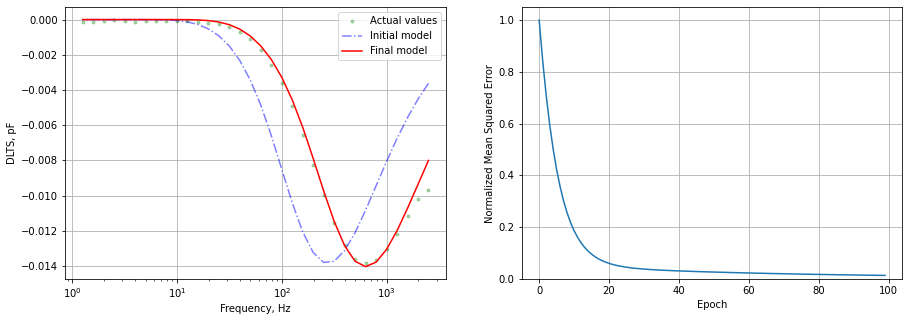

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.7979 log10(s)
Time constant = 1.5924e-03 s
Amplitude = -1.3828e-02 pF
P = 1.0000
MSE = 9.8970e-06
RMSE = 3.1459e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -3.1630 log10(s)
Time constant = 6.8714e-04 s
Amplitude = -1.4025e-02 pF
P = 0.8763
MSE = 1.3998e-07
RMSE = 3.7414e-04


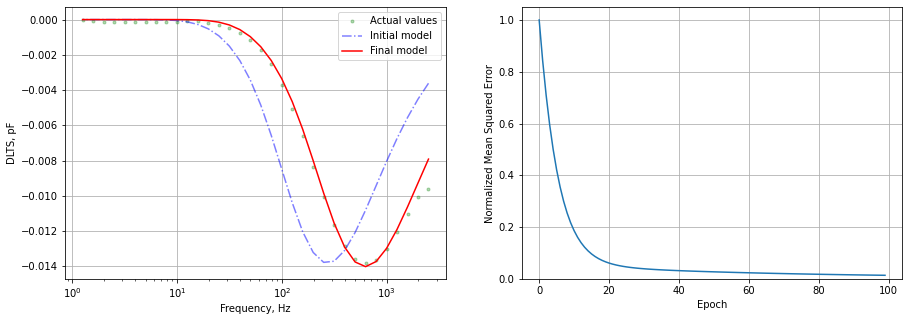

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.7979 log10(s)
Time constant = 1.5924e-03 s
Amplitude = -1.3816e-02 pF
P = 1.0000
MSE = 9.7199e-06
RMSE = 3.1177e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -3.1592 log10(s)
Time constant = 6.9307e-04 s
Amplitude = -1.4007e-02 pF
P = 0.8806
MSE = 1.3068e-07
RMSE = 3.6150e-04


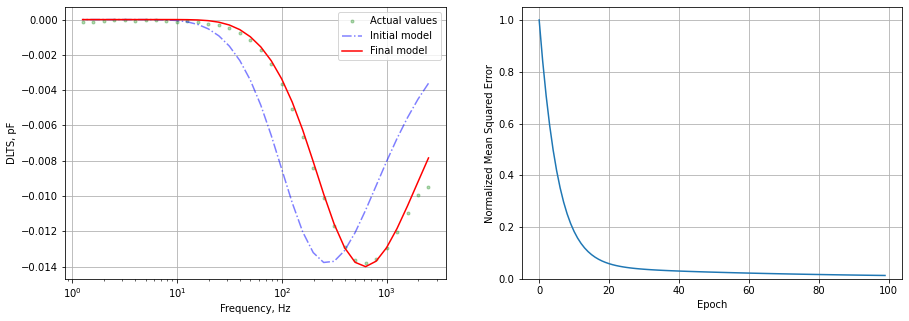

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -3.2010 log10(s)
Time constant = 6.2946e-04 s
Amplitude = -4.5740e-03 pF
P = 1.0000
MSE = 2.6175e-07
RMSE = 5.1162e-04

Final values
Filling pulse = 2.0000e-05
Time constant power = nan log10(s)
Time constant = nan s
Amplitude = nan pF
P = nan
MSE = nan
RMSE = nan


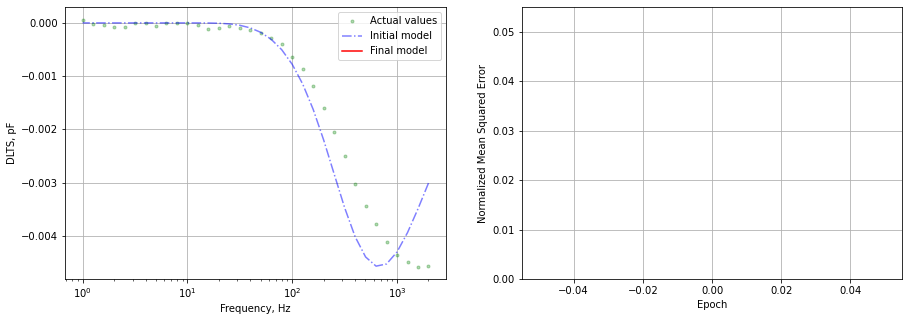

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -3.0010 log10(s)
Time constant = 9.9763e-04 s
Amplitude = -8.7860e-03 pF
P = 1.0000
MSE = 1.9522e-06
RMSE = 1.3972e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = nan log10(s)
Time constant = nan s
Amplitude = nan pF
P = nan
MSE = nan
RMSE = nan


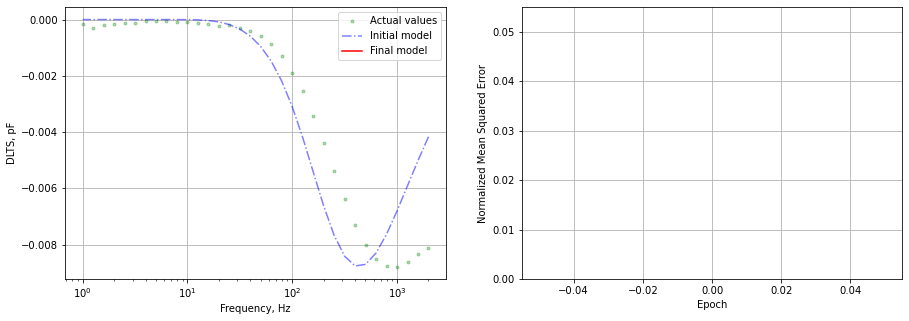

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.9010 log10(s)
Time constant = 1.2559e-03 s
Amplitude = -1.1148e-02 pF
P = 1.0000
MSE = 4.5943e-06
RMSE = 2.1434e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = nan log10(s)
Time constant = nan s
Amplitude = nan pF
P = nan
MSE = nan
RMSE = nan


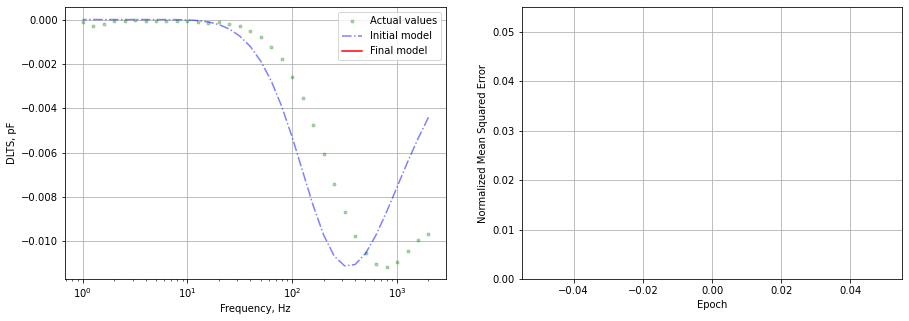

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.9010 log10(s)
Time constant = 1.2559e-03 s
Amplitude = -1.2430e-02 pF
P = 1.0000
MSE = 5.0207e-06
RMSE = 2.2407e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -3.1943 log10(s)
Time constant = 6.3929e-04 s
Amplitude = -1.2649e-02 pF
P = 0.8924
MSE = 1.7405e-07
RMSE = 4.1719e-04


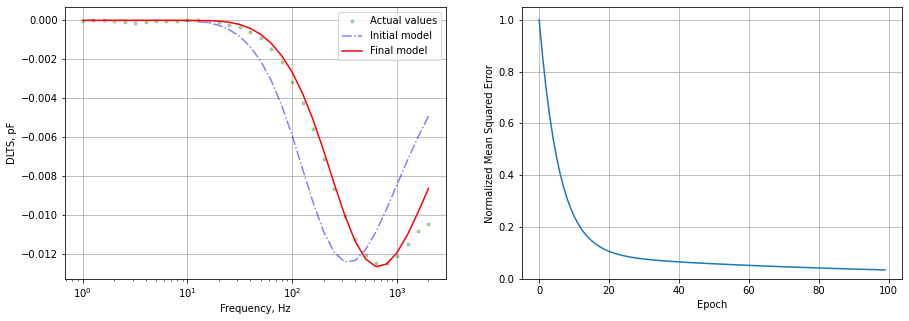

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.7979 log10(s)
Time constant = 1.5924e-03 s
Amplitude = -1.3210e-02 pF
P = 1.0000
MSE = 1.0367e-05
RMSE = 3.2199e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -3.1929 log10(s)
Time constant = 6.4130e-04 s
Amplitude = -1.3427e-02 pF
P = 0.8646
MSE = 1.5276e-07
RMSE = 3.9084e-04


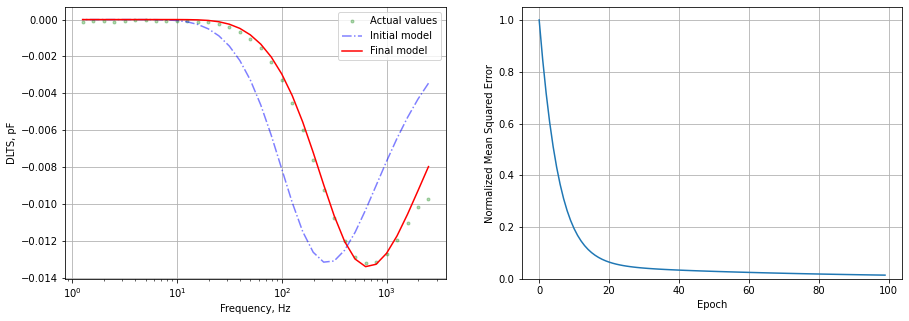

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.7979 log10(s)
Time constant = 1.5924e-03 s
Amplitude = -1.3572e-02 pF
P = 1.0000
MSE = 1.0508e-05
RMSE = 3.2417e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -3.1835 log10(s)
Time constant = 6.5546e-04 s
Amplitude = -1.3780e-02 pF
P = 0.8721
MSE = 1.4836e-07
RMSE = 3.8518e-04


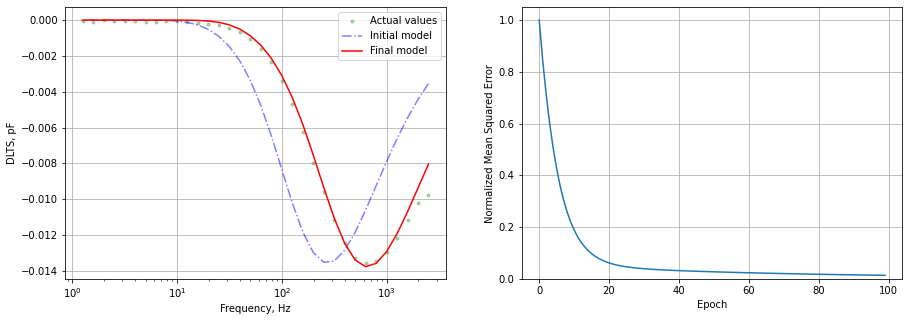

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.7979 log10(s)
Time constant = 1.5924e-03 s
Amplitude = -1.3724e-02 pF
P = 1.0000
MSE = 1.0335e-05
RMSE = 3.2148e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -3.1754 log10(s)
Time constant = 6.6778e-04 s
Amplitude = -1.3931e-02 pF
P = 0.8710
MSE = 1.4867e-07
RMSE = 3.8558e-04


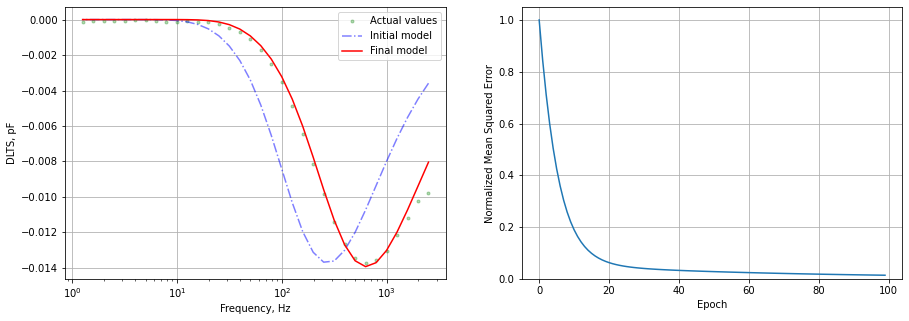

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.7979 log10(s)
Time constant = 1.5924e-03 s
Amplitude = -1.1838e-02 pF
P = 1.0000
MSE = 7.8832e-06
RMSE = 2.8077e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -3.1818 log10(s)
Time constant = 6.5790e-04 s
Amplitude = -1.2011e-02 pF
P = 0.8692
MSE = 1.1577e-07
RMSE = 3.4025e-04


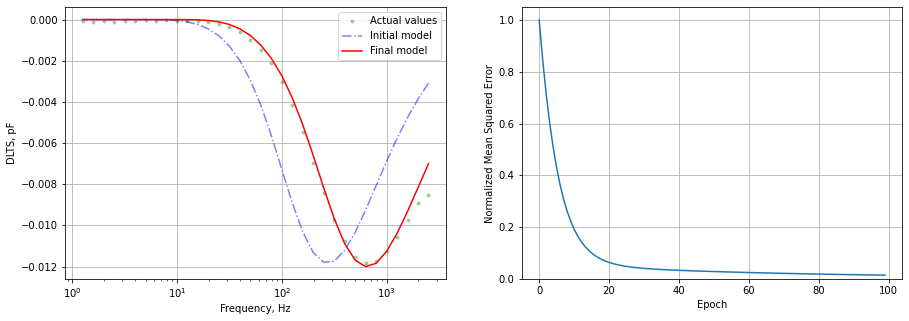

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.7979 log10(s)
Time constant = 1.5924e-03 s
Amplitude = -1.2090e-02 pF
P = 1.0000
MSE = 7.9692e-06
RMSE = 2.8230e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -3.1749 log10(s)
Time constant = 6.6846e-04 s
Amplitude = -1.2262e-02 pF
P = 0.8707
MSE = 1.2022e-07
RMSE = 3.4673e-04


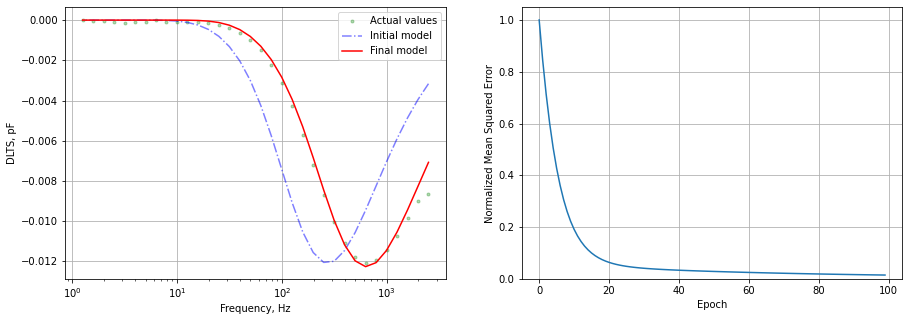

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.7979 log10(s)
Time constant = 1.5924e-03 s
Amplitude = -1.2162e-02 pF
P = 1.0000
MSE = 7.8723e-06
RMSE = 2.8058e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -3.1692 log10(s)
Time constant = 6.7737e-04 s
Amplitude = -1.2353e-02 pF
P = 0.8667
MSE = 1.1392e-07
RMSE = 3.3752e-04


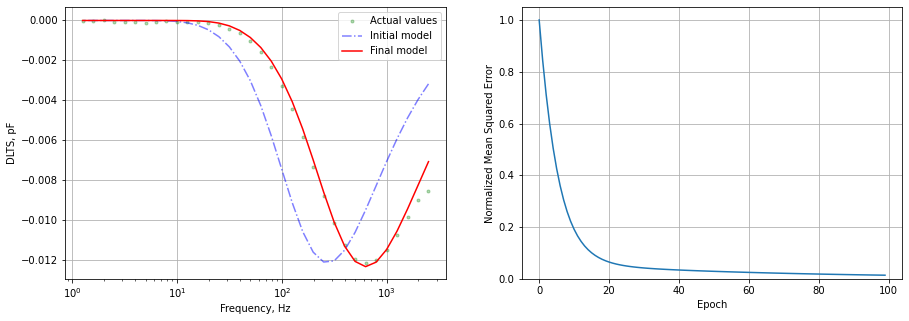

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -3.2010 log10(s)
Time constant = 6.2946e-04 s
Amplitude = -2.9725e-03 pF
P = 1.0000
MSE = 1.3997e-07
RMSE = 3.7412e-04

Final values
Filling pulse = 2.0000e-05
Time constant power = nan log10(s)
Time constant = nan s
Amplitude = nan pF
P = nan
MSE = nan
RMSE = nan


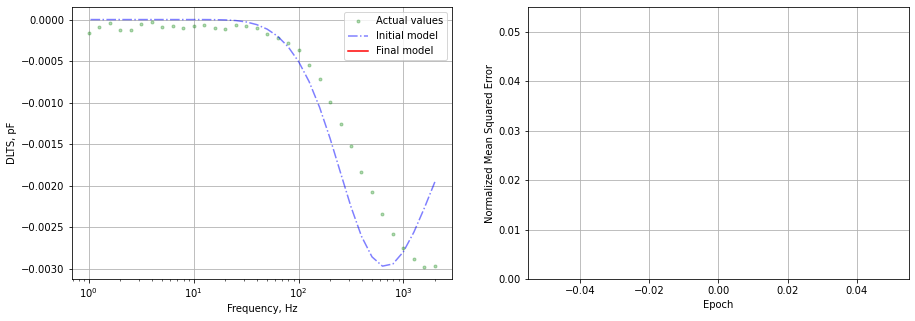

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -3.0010 log10(s)
Time constant = 9.9763e-04 s
Amplitude = -6.2050e-03 pF
P = 1.0000
MSE = 1.0891e-06
RMSE = 1.0436e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = nan log10(s)
Time constant = nan s
Amplitude = nan pF
P = nan
MSE = nan
RMSE = nan


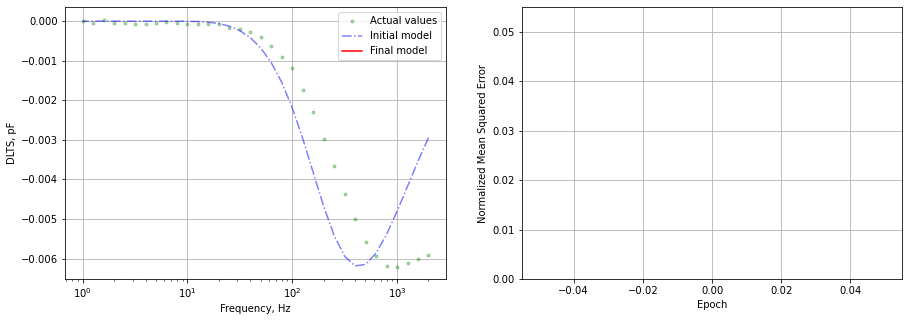

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.9010 log10(s)
Time constant = 1.2559e-03 s
Amplitude = -8.5900e-03 pF
P = 1.0000
MSE = 2.8992e-06
RMSE = 1.7027e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = nan log10(s)
Time constant = nan s
Amplitude = nan pF
P = nan
MSE = nan
RMSE = nan


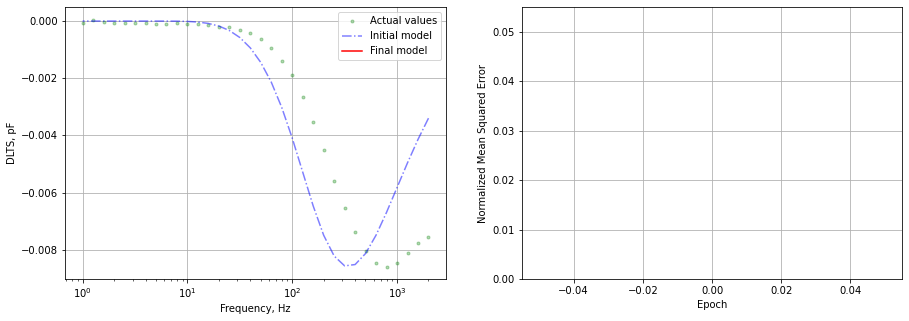

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.8979 log10(s)
Time constant = 1.2649e-03 s
Amplitude = -1.0056e-02 pF
P = 1.0000
MSE = 4.0568e-06
RMSE = 2.0141e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -3.2221 log10(s)
Time constant = 5.9963e-04 s
Amplitude = -1.0243e-02 pF
P = 0.8541
MSE = 1.1098e-07
RMSE = 3.3313e-04


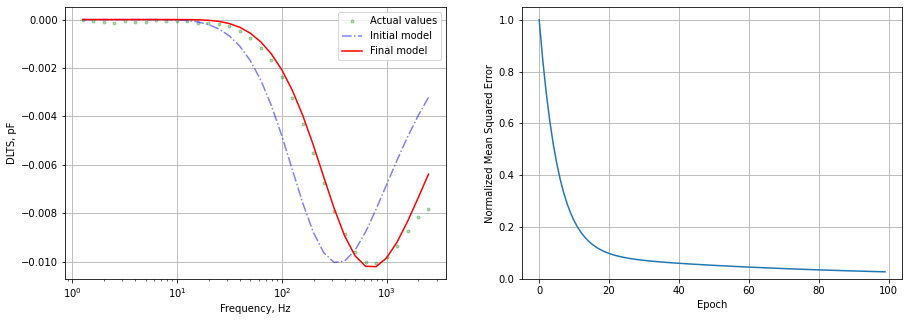

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.7979 log10(s)
Time constant = 1.5924e-03 s
Amplitude = -1.0904e-02 pF
P = 1.0000
MSE = 7.3931e-06
RMSE = 2.7190e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -3.2039 log10(s)
Time constant = 6.2527e-04 s
Amplitude = -1.1087e-02 pF
P = 0.8602
MSE = 1.1543e-07
RMSE = 3.3975e-04


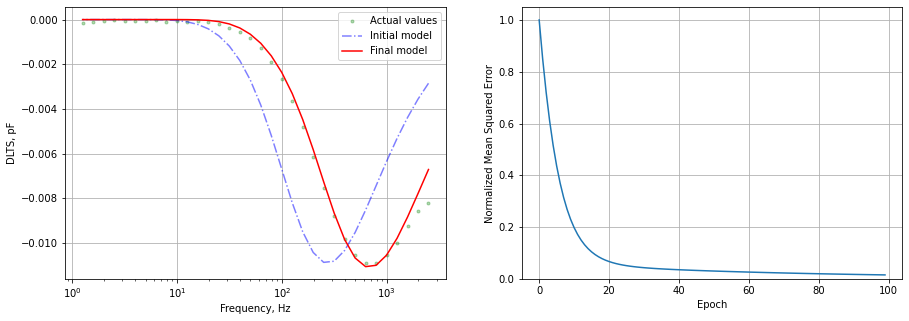

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.7979 log10(s)
Time constant = 1.5924e-03 s
Amplitude = -1.1454e-02 pF
P = 1.0000
MSE = 7.7235e-06
RMSE = 2.7791e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -3.1921 log10(s)
Time constant = 6.4259e-04 s
Amplitude = -1.1639e-02 pF
P = 0.8610
MSE = 1.1696e-07
RMSE = 3.4200e-04


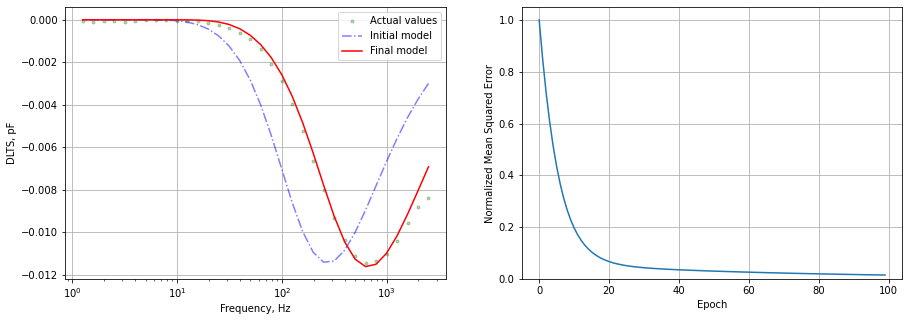

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.7979 log10(s)
Time constant = 1.5924e-03 s
Amplitude = -9.8340e-03 pF
P = 1.0000
MSE = 5.9215e-06
RMSE = 2.4334e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -3.2008 log10(s)
Time constant = 6.2985e-04 s
Amplitude = -9.9972e-03 pF
P = 0.8600
MSE = 9.2473e-08
RMSE = 3.0409e-04


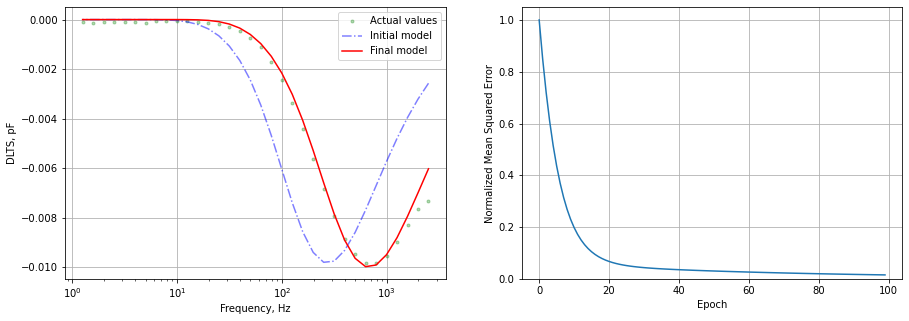

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.7979 log10(s)
Time constant = 1.5924e-03 s
Amplitude = -1.0324e-02 pF
P = 1.0000
MSE = 6.1952e-06
RMSE = 2.4890e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -3.1888 log10(s)
Time constant = 6.4747e-04 s
Amplitude = -1.0491e-02 pF
P = 0.8618
MSE = 9.8478e-08
RMSE = 3.1381e-04


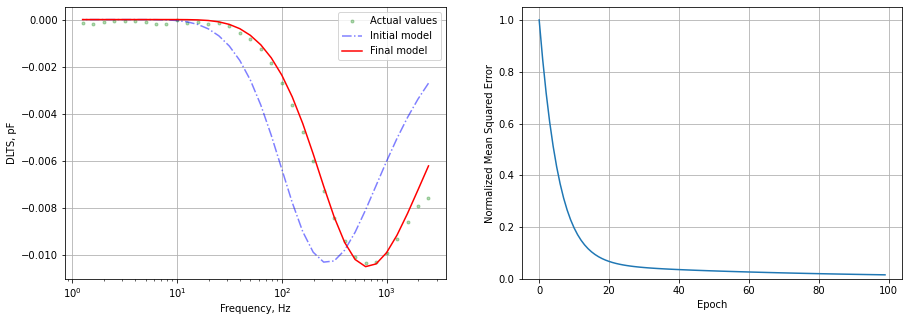

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.7979 log10(s)
Time constant = 1.5924e-03 s
Amplitude = -1.0670e-02 pF
P = 1.0000
MSE = 6.4157e-06
RMSE = 2.5329e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -3.1813 log10(s)
Time constant = 6.5873e-04 s
Amplitude = -1.0844e-02 pF
P = 0.8642
MSE = 9.5426e-08
RMSE = 3.0891e-04


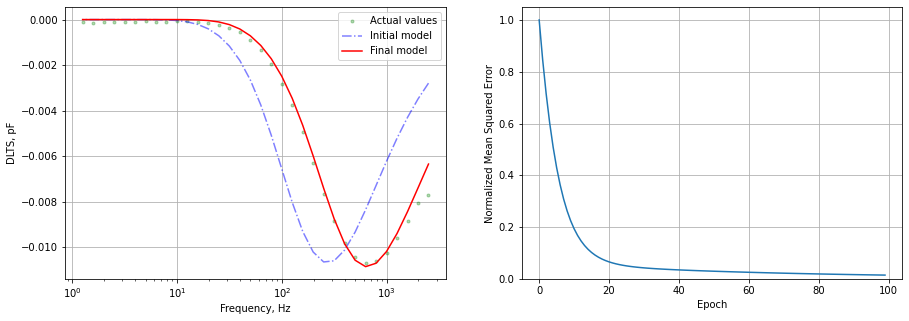

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -3.2010 log10(s)
Time constant = 6.2946e-04 s
Amplitude = -2.0450e-03 pF
P = 1.0000
MSE = 7.6293e-08
RMSE = 2.7621e-04

Final values
Filling pulse = 2.0000e-05
Time constant power = nan log10(s)
Time constant = nan s
Amplitude = nan pF
P = nan
MSE = nan
RMSE = nan


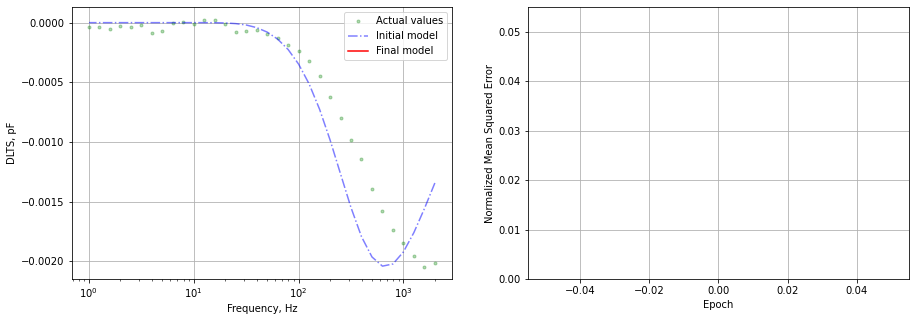

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -3.0010 log10(s)
Time constant = 9.9763e-04 s
Amplitude = -4.7000e-03 pF
P = 1.0000
MSE = 6.7800e-07
RMSE = 8.2340e-04

Final values
Filling pulse = 2.0000e-05
Time constant power = nan log10(s)
Time constant = nan s
Amplitude = nan pF
P = nan
MSE = nan
RMSE = nan


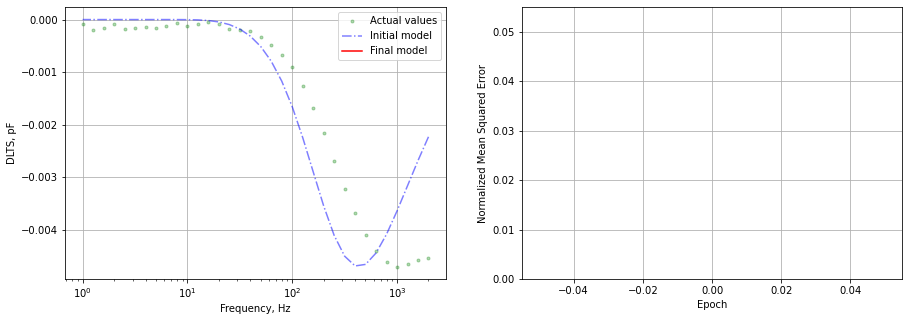

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.8979 log10(s)
Time constant = 1.2649e-03 s
Amplitude = -6.8710e-03 pF
P = 1.0000
MSE = 2.3129e-06
RMSE = 1.5208e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -3.2635 log10(s)
Time constant = 5.4514e-04 s
Amplitude = -7.0018e-03 pF
P = 0.8424
MSE = 7.1576e-08
RMSE = 2.6754e-04


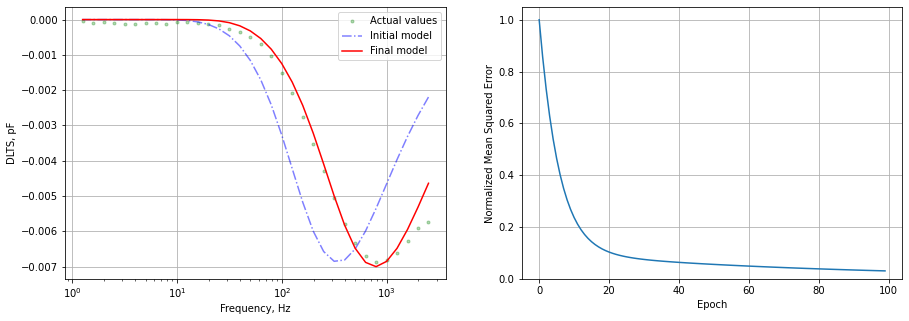

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.8979 log10(s)
Time constant = 1.2649e-03 s
Amplitude = -8.2880e-03 pF
P = 1.0000
MSE = 2.8864e-06
RMSE = 1.6989e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -3.2301 log10(s)
Time constant = 5.8877e-04 s
Amplitude = -8.4558e-03 pF
P = 0.8439
MSE = 8.9766e-08
RMSE = 2.9961e-04


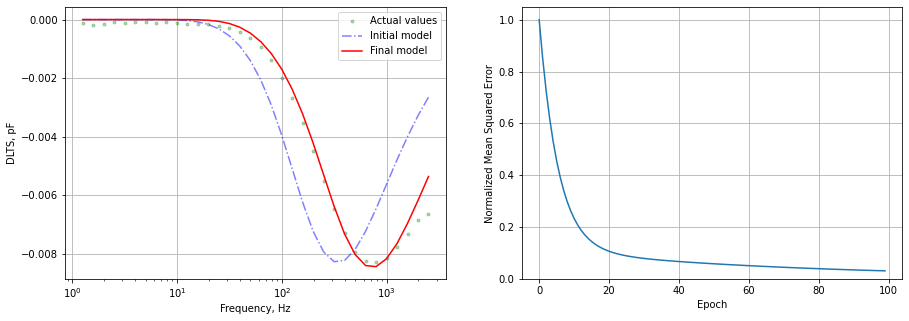

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.8979 log10(s)
Time constant = 1.2649e-03 s
Amplitude = -9.1700e-03 pF
P = 1.0000
MSE = 3.2263e-06
RMSE = 1.7962e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -3.2129 log10(s)
Time constant = 6.1244e-04 s
Amplitude = -9.3461e-03 pF
P = 0.8557
MSE = 8.8779e-08
RMSE = 2.9796e-04


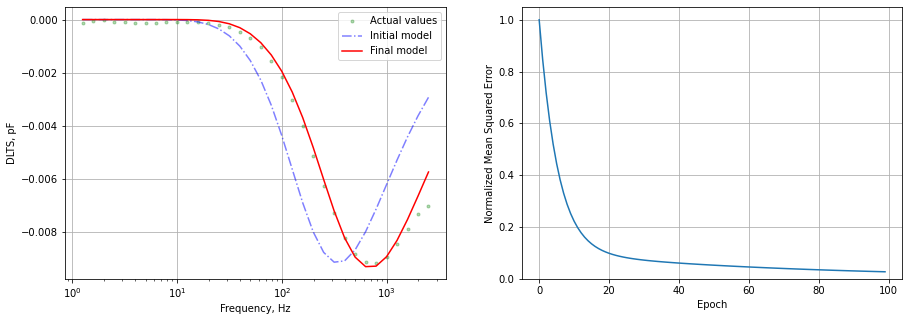

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.8979 log10(s)
Time constant = 1.2649e-03 s
Amplitude = -7.9490e-03 pF
P = 1.0000
MSE = 2.5213e-06
RMSE = 1.5879e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -3.2220 log10(s)
Time constant = 5.9977e-04 s
Amplitude = -8.0951e-03 pF
P = 0.8487
MSE = 7.4349e-08
RMSE = 2.7267e-04


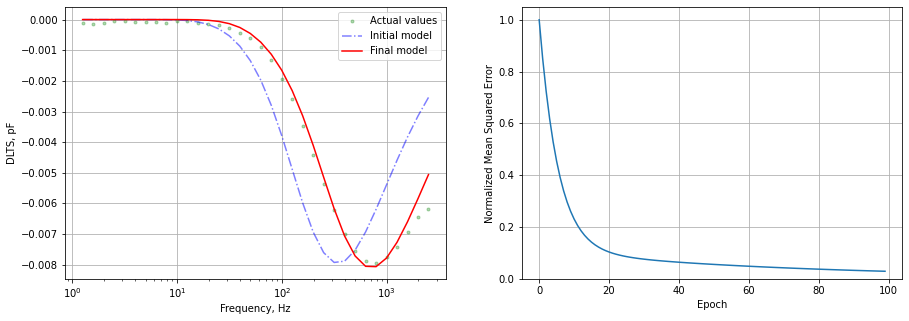

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.7979 log10(s)
Time constant = 1.5924e-03 s
Amplitude = -8.5990e-03 pF
P = 1.0000
MSE = 4.5602e-06
RMSE = 2.1355e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -3.2024 log10(s)
Time constant = 6.2750e-04 s
Amplitude = -8.7572e-03 pF
P = 0.8485
MSE = 8.1136e-08
RMSE = 2.8484e-04


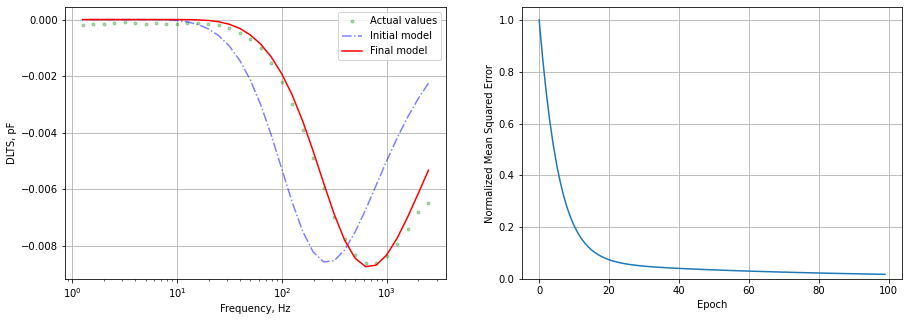

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.7979 log10(s)
Time constant = 1.5924e-03 s
Amplitude = -9.0680e-03 pF
P = 1.0000
MSE = 4.9113e-06
RMSE = 2.2161e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -3.1953 log10(s)
Time constant = 6.3781e-04 s
Amplitude = -9.2212e-03 pF
P = 0.8554
MSE = 8.1344e-08
RMSE = 2.8521e-04


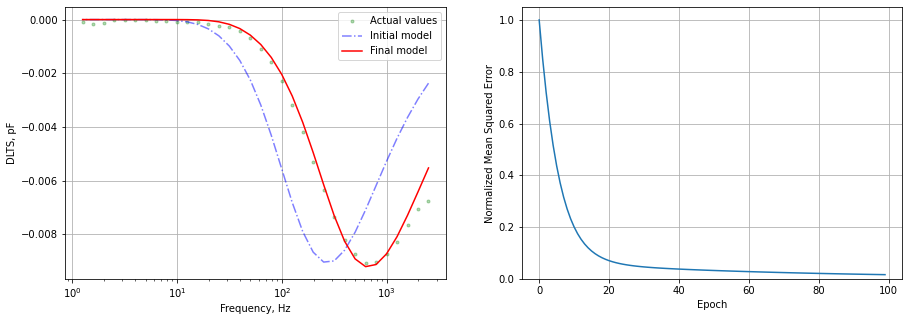

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -3.2010 log10(s)
Time constant = 6.2946e-04 s
Amplitude = -1.5812e-03 pF
P = 1.0000
MSE = 5.9449e-08
RMSE = 2.4382e-04

Final values
Filling pulse = 2.0000e-05
Time constant power = nan log10(s)
Time constant = nan s
Amplitude = nan pF
P = nan
MSE = nan
RMSE = nan


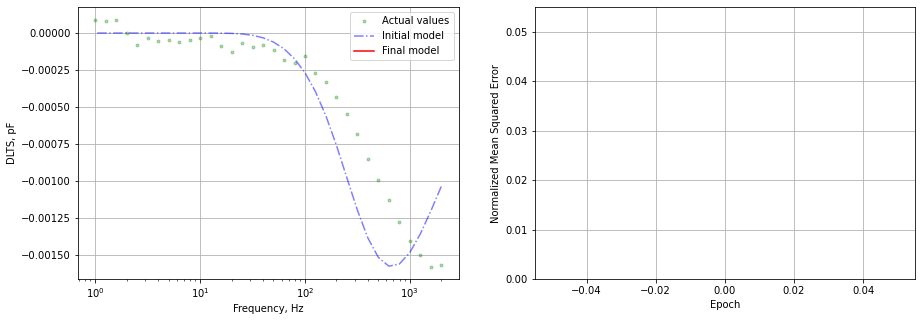

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.9979 log10(s)
Time constant = 1.0048e-03 s
Amplitude = -3.7275e-03 pF
P = 1.0000
MSE = 6.0280e-07
RMSE = 7.7640e-04

Final values
Filling pulse = 2.0000e-05
Time constant power = nan log10(s)
Time constant = nan s
Amplitude = nan pF
P = nan
MSE = nan
RMSE = nan


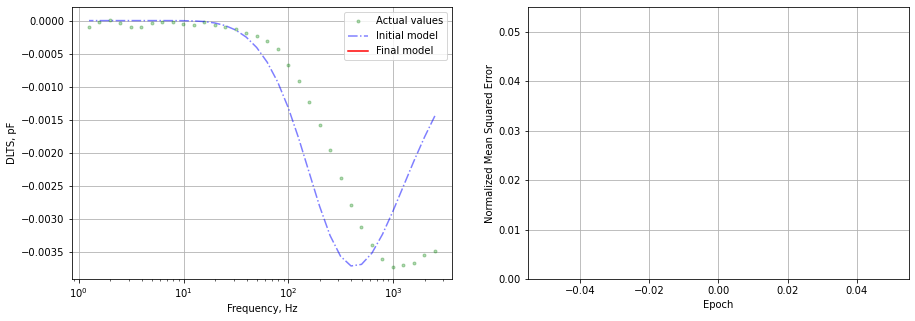

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.9979 log10(s)
Time constant = 1.0048e-03 s
Amplitude = -5.6120e-03 pF
P = 1.0000
MSE = 9.2593e-07
RMSE = 9.6225e-04

Final values
Filling pulse = 2.0000e-05
Time constant power = -3.2760 log10(s)
Time constant = 5.2969e-04 s
Amplitude = -5.7282e-03 pF
P = 0.8378
MSE = 5.3573e-08
RMSE = 2.3146e-04


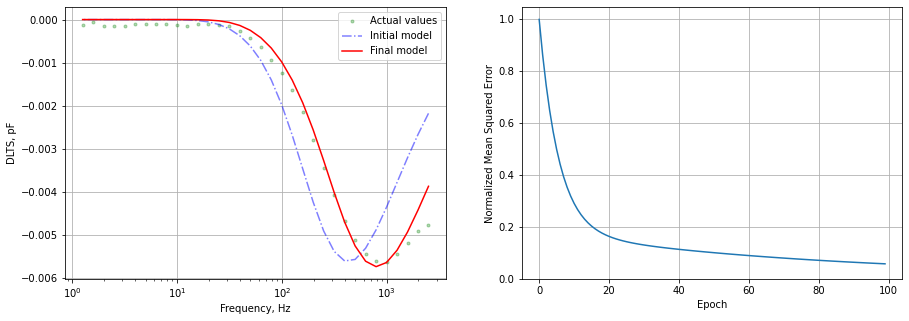

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.8979 log10(s)
Time constant = 1.2649e-03 s
Amplitude = -6.9670e-03 pF
P = 1.0000
MSE = 2.1929e-06
RMSE = 1.4809e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -3.2454 log10(s)
Time constant = 5.6833e-04 s
Amplitude = -7.1088e-03 pF
P = 0.8395
MSE = 6.7984e-08
RMSE = 2.6074e-04


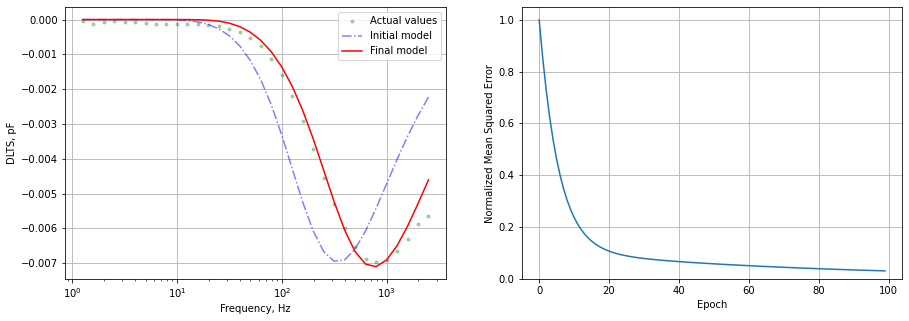

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.8979 log10(s)
Time constant = 1.2649e-03 s
Amplitude = -5.9260e-03 pF
P = 1.0000
MSE = 1.6293e-06
RMSE = 1.2764e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -3.2514 log10(s)
Time constant = 5.6053e-04 s
Amplitude = -6.0466e-03 pF
P = 0.8315
MSE = 5.7083e-08
RMSE = 2.3892e-04


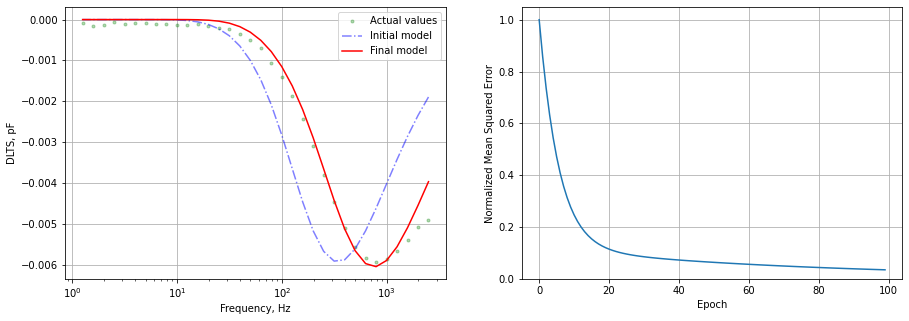

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.8979 log10(s)
Time constant = 1.2649e-03 s
Amplitude = -6.8890e-03 pF
P = 1.0000
MSE = 1.9535e-06
RMSE = 1.3977e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -3.2270 log10(s)
Time constant = 5.9287e-04 s
Amplitude = -7.0231e-03 pF
P = 0.8457
MSE = 5.8856e-08
RMSE = 2.4260e-04


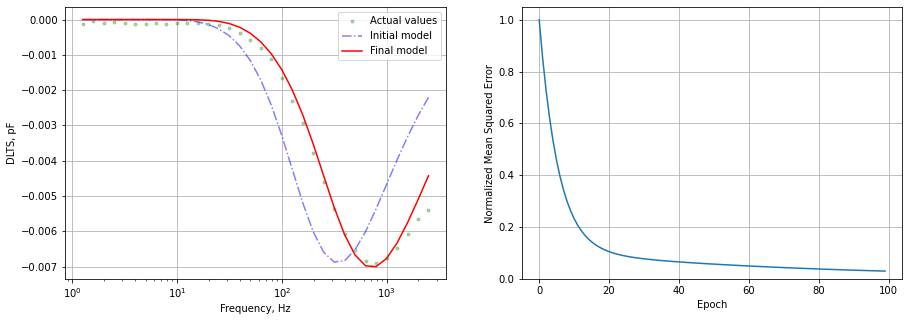

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.8979 log10(s)
Time constant = 1.2649e-03 s
Amplitude = -7.6030e-03 pF
P = 1.0000
MSE = 2.1794e-06
RMSE = 1.4763e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -3.2105 log10(s)
Time constant = 6.1595e-04 s
Amplitude = -7.7485e-03 pF
P = 0.8487
MSE = 6.5694e-08
RMSE = 2.5631e-04


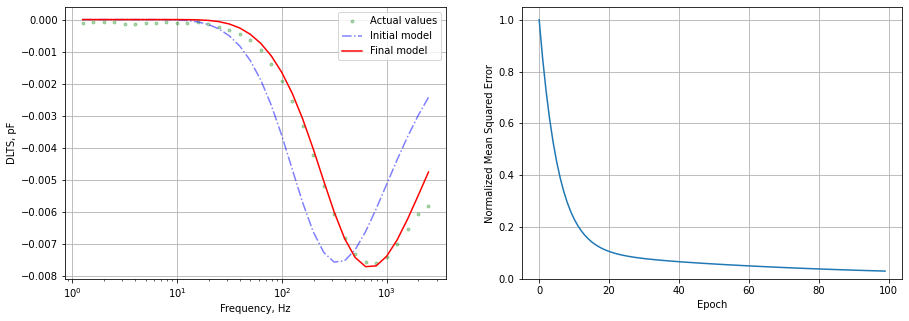

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -3.3979 log10(s)
Time constant = 4.0000e-04 s
Amplitude = -1.2638e-03 pF
P = 1.0000
MSE = 1.2607e-08
RMSE = 1.1228e-04

Final values
Filling pulse = 2.0000e-05
Time constant power = nan log10(s)
Time constant = nan s
Amplitude = nan pF
P = nan
MSE = nan
RMSE = nan


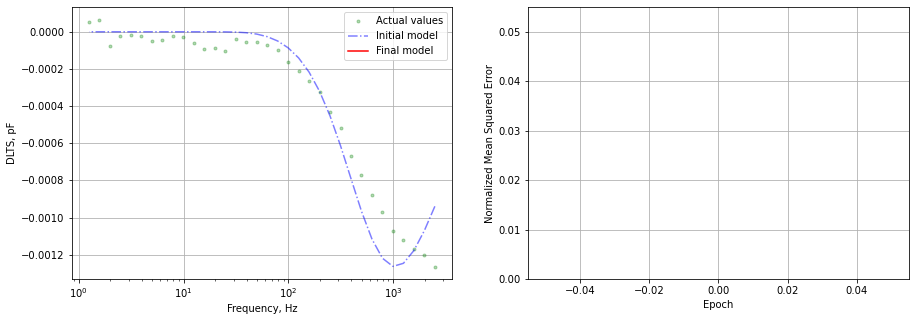

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -3.0979 log10(s)
Time constant = 7.9810e-04 s
Amplitude = -3.0140e-03 pF
P = 1.0000
MSE = 2.3844e-07
RMSE = 4.8830e-04

Final values
Filling pulse = 2.0000e-05
Time constant power = nan log10(s)
Time constant = nan s
Amplitude = nan pF
P = nan
MSE = nan
RMSE = nan


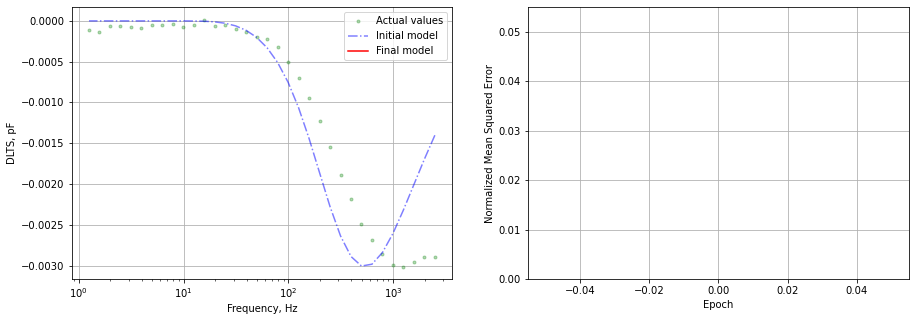

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.8979 log10(s)
Time constant = 1.2649e-03 s
Amplitude = -4.6570e-03 pF
P = 1.0000
MSE = 1.1776e-06
RMSE = 1.0852e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -3.2878 log10(s)
Time constant = 5.1541e-04 s
Amplitude = -4.7457e-03 pF
P = 0.8322
MSE = 4.3511e-08
RMSE = 2.0859e-04


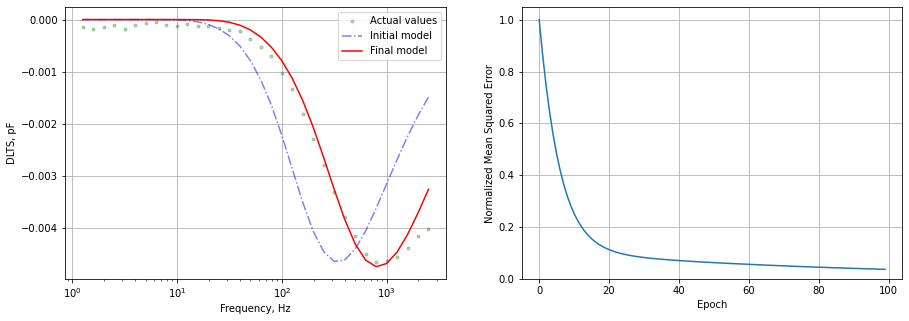

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.9979 log10(s)
Time constant = 1.0048e-03 s
Amplitude = -3.9970e-03 pF
P = 1.0000
MSE = 5.2531e-07
RMSE = 7.2478e-04

Final values
Filling pulse = 2.0000e-05
Time constant power = -3.2979 log10(s)
Time constant = 5.0361e-04 s
Amplitude = -4.0665e-03 pF
P = 0.8407
MSE = 3.1159e-08
RMSE = 1.7652e-04


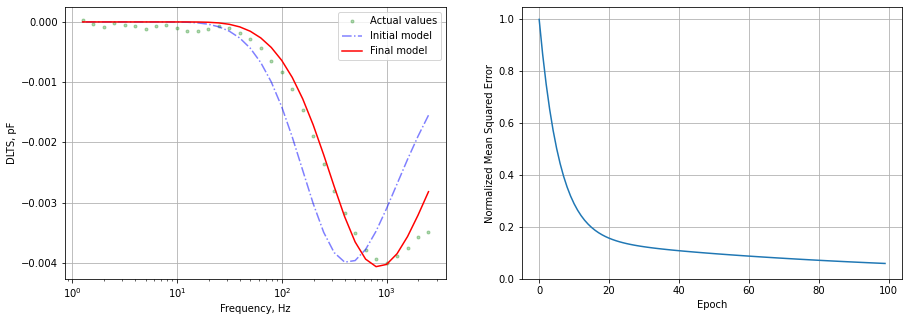

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.8979 log10(s)
Time constant = 1.2649e-03 s
Amplitude = -5.2050e-03 pF
P = 1.0000
MSE = 1.2818e-06
RMSE = 1.1322e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -3.2569 log10(s)
Time constant = 5.5346e-04 s
Amplitude = -5.2921e-03 pF
P = 0.8506
MSE = 4.2084e-08
RMSE = 2.0514e-04


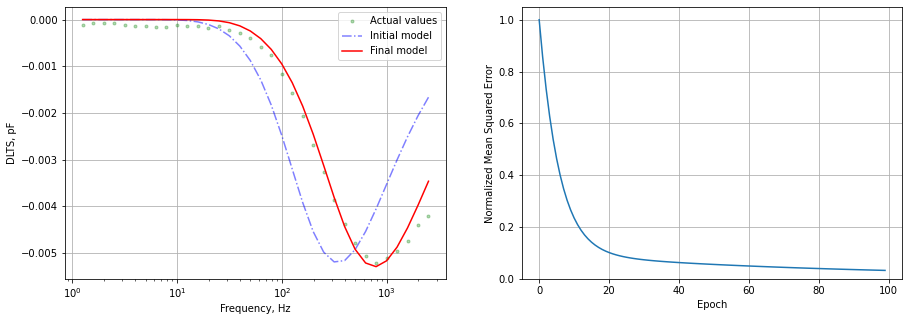

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.8979 log10(s)
Time constant = 1.2649e-03 s
Amplitude = -6.0490e-03 pF
P = 1.0000
MSE = 1.5315e-06
RMSE = 1.2375e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -3.2300 log10(s)
Time constant = 5.8891e-04 s
Amplitude = -6.1706e-03 pF
P = 0.8375
MSE = 5.3158e-08
RMSE = 2.3056e-04


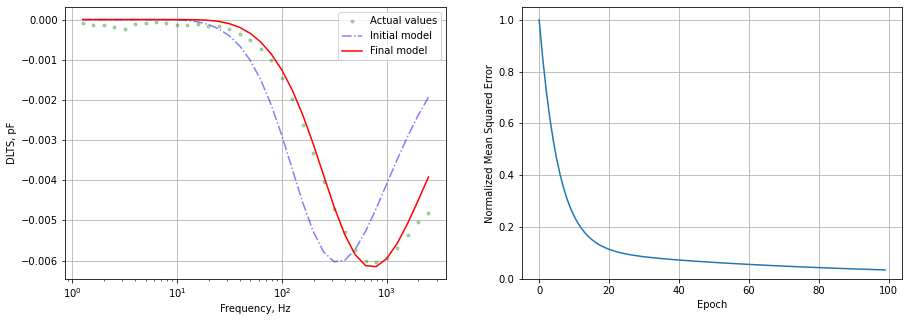

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -3.3979 log10(s)
Time constant = 4.0000e-04 s
Amplitude = -1.0534e-03 pF
P = 1.0000
MSE = 1.0772e-08
RMSE = 1.0379e-04

Final values
Filling pulse = 2.0000e-05
Time constant power = nan log10(s)
Time constant = nan s
Amplitude = nan pF
P = nan
MSE = nan
RMSE = nan


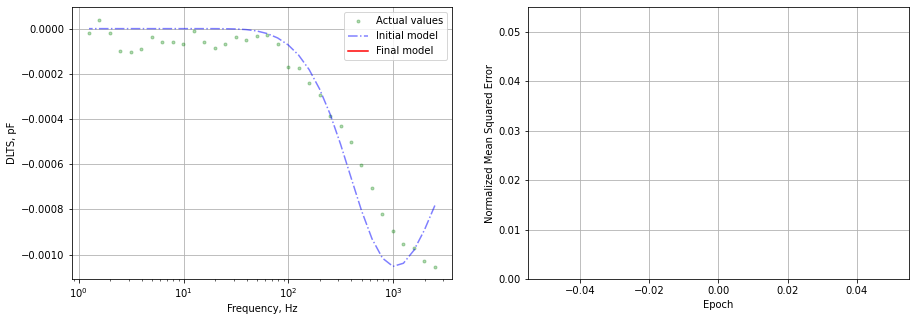

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -3.0979 log10(s)
Time constant = 7.9810e-04 s
Amplitude = -2.5035e-03 pF
P = 1.0000
MSE = 1.7906e-07
RMSE = 4.2316e-04

Final values
Filling pulse = 2.0000e-05
Time constant power = nan log10(s)
Time constant = nan s
Amplitude = nan pF
P = nan
MSE = nan
RMSE = nan


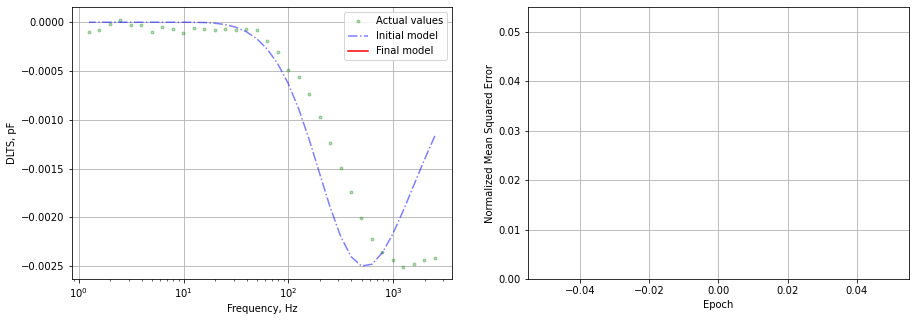

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -3.1979 log10(s)
Time constant = 6.3396e-04 s
Amplitude = -2.1150e-03 pF
P = 1.0000
MSE = 6.9906e-08
RMSE = 2.6440e-04

Final values
Filling pulse = 2.0000e-05
Time constant power = nan log10(s)
Time constant = nan s
Amplitude = nan pF
P = nan
MSE = nan
RMSE = nan


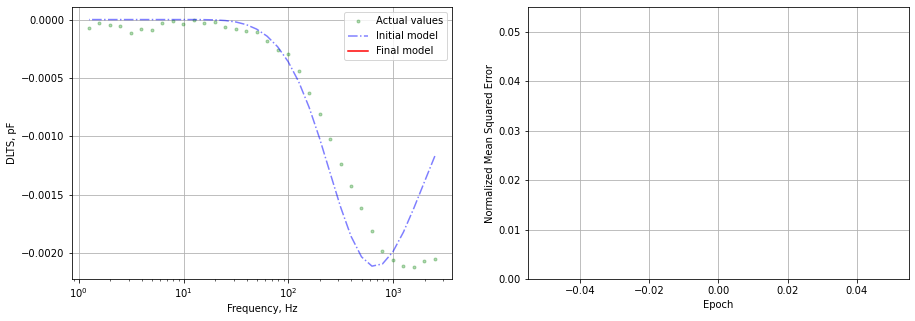

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.9979 log10(s)
Time constant = 1.0048e-03 s
Amplitude = -3.4060e-03 pF
P = 1.0000
MSE = 4.1955e-07
RMSE = 6.4773e-04

Final values
Filling pulse = 2.0000e-05
Time constant power = nan log10(s)
Time constant = nan s
Amplitude = nan pF
P = nan
MSE = nan
RMSE = nan


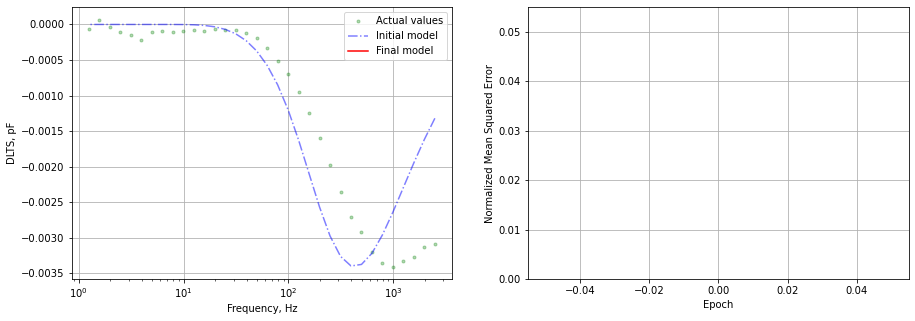

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.8979 log10(s)
Time constant = 1.2649e-03 s
Amplitude = -4.4800e-03 pF
P = 1.0000
MSE = 9.7896e-07
RMSE = 9.8942e-04

Final values
Filling pulse = 2.0000e-05
Time constant power = -3.2611 log10(s)
Time constant = 5.4809e-04 s
Amplitude = -4.5790e-03 pF
P = 0.8187
MSE = 3.9819e-08
RMSE = 1.9955e-04


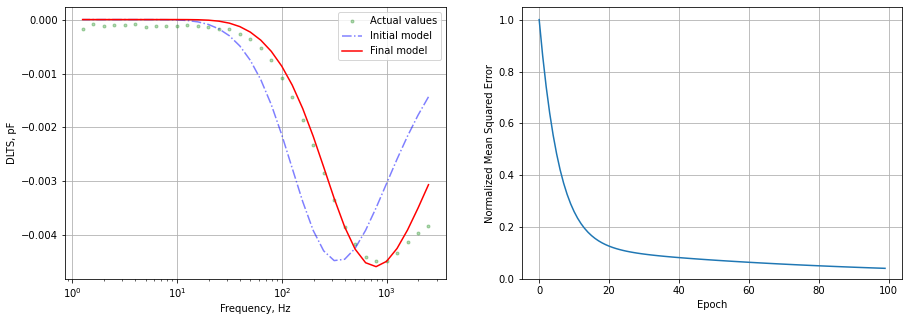

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -3.2979 log10(s)
Time constant = 5.0357e-04 s
Amplitude = -8.8880e-04 pF
P = 1.0000
MSE = 1.8530e-08
RMSE = 1.3613e-04

Final values
Filling pulse = 2.0000e-05
Time constant power = nan log10(s)
Time constant = nan s
Amplitude = nan pF
P = nan
MSE = nan
RMSE = nan


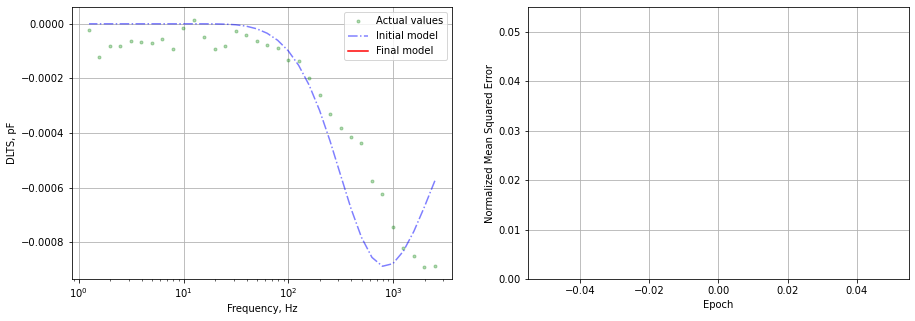

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -3.3979 log10(s)
Time constant = 4.0000e-04 s
Amplitude = -7.6000e-04 pF
P = 1.0000
MSE = 8.4626e-09
RMSE = 9.1992e-05

Final values
Filling pulse = 2.0000e-05
Time constant power = nan log10(s)
Time constant = nan s
Amplitude = nan pF
P = nan
MSE = nan
RMSE = nan


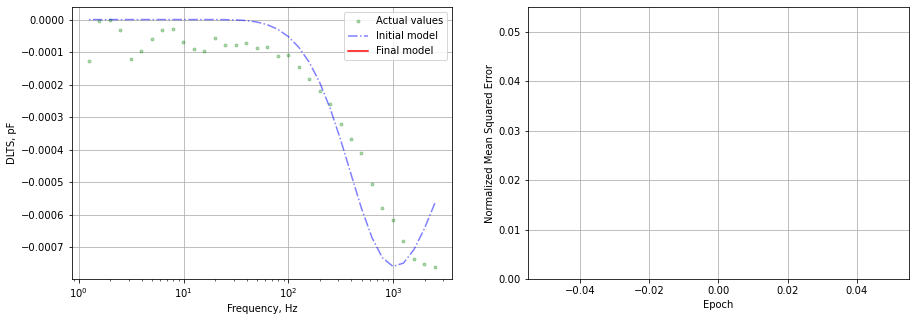

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -3.1979 log10(s)
Time constant = 6.3396e-04 s
Amplitude = -1.8324e-03 pF
P = 1.0000
MSE = 6.6815e-08
RMSE = 2.5849e-04

Final values
Filling pulse = 2.0000e-05
Time constant power = nan log10(s)
Time constant = nan s
Amplitude = nan pF
P = nan
MSE = nan
RMSE = nan


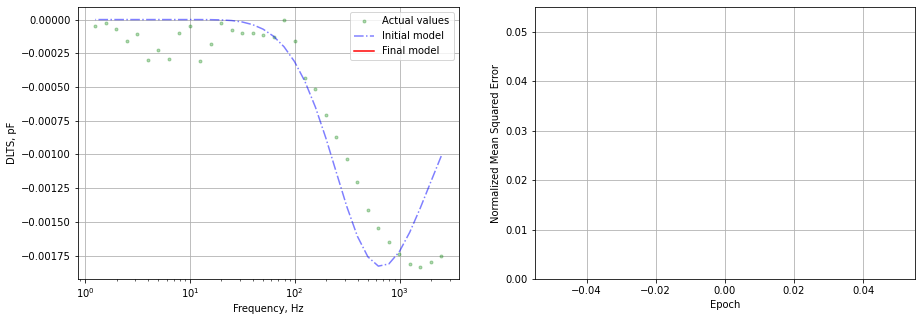

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -2.9979 log10(s)
Time constant = 1.0048e-03 s
Amplitude = -2.9435e-03 pF
P = 1.0000
MSE = 3.3725e-07
RMSE = 5.8074e-04

Final values
Filling pulse = 2.0000e-05
Time constant power = nan log10(s)
Time constant = nan s
Amplitude = nan pF
P = nan
MSE = nan
RMSE = nan


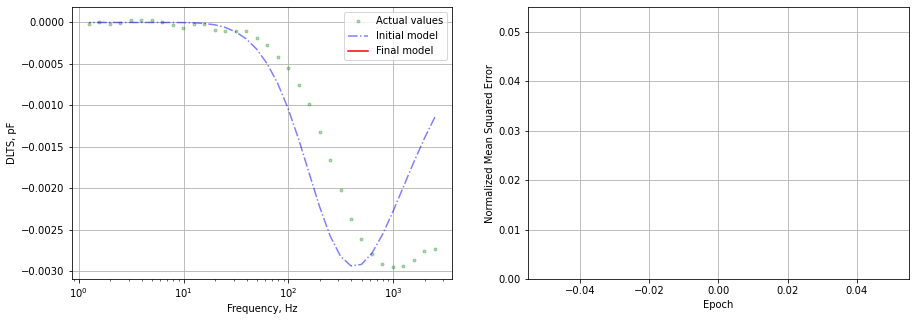

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -1.8979 log10(s)
Time constant = 1.2649e-02 s
Amplitude = -3.2920e-04 pF
P = 1.0000
MSE = 1.3445e-08
RMSE = 1.1595e-04

Final values
Filling pulse = 2.0000e-05
Time constant power = -2.4178 log10(s)
Time constant = 3.8215e-03 s
Amplitude = -2.8348e-04 pF
P = 0.6647
MSE = 6.0981e-09
RMSE = 7.8090e-05


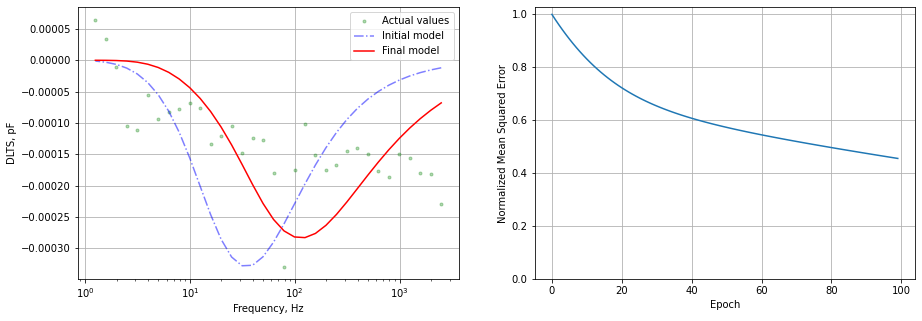

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -1.8979 log10(s)
Time constant = 1.2649e-02 s
Amplitude = -8.2980e-04 pF
P = 1.0000
MSE = 2.7918e-08
RMSE = 1.6709e-04

Final values
Filling pulse = 2.0000e-05
Time constant power = -2.1008 log10(s)
Time constant = 7.9279e-03 s
Amplitude = -7.9962e-04 pF
P = 0.5817
MSE = 6.6777e-09
RMSE = 8.1717e-05


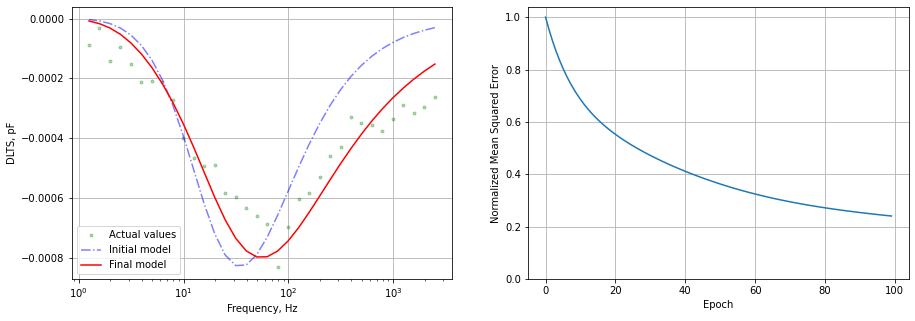

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -3.3979 log10(s)
Time constant = 4.0000e-04 s
Amplitude = -2.1420e-04 pF
P = 1.0000
MSE = 6.7045e-09
RMSE = 8.1881e-05

Final values
Filling pulse = 2.0000e-05
Time constant power = nan log10(s)
Time constant = nan s
Amplitude = nan pF
P = nan
MSE = nan
RMSE = nan


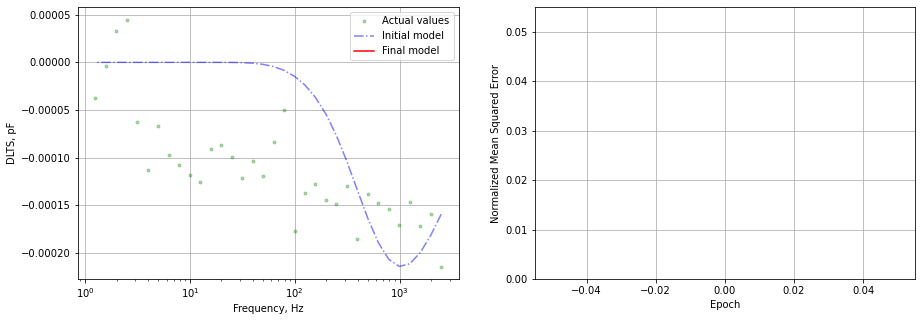

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -1.2979 log10(s)
Time constant = 5.0357e-02 s
Amplitude = -9.8620e-03 pF
P = 1.0000
MSE = 5.2411e-06
RMSE = 2.2894e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -1.6373 log10(s)
Time constant = 2.3050e-02 s
Amplitude = -9.9866e-03 pF
P = 0.8124
MSE = 1.1474e-08
RMSE = 1.0712e-04


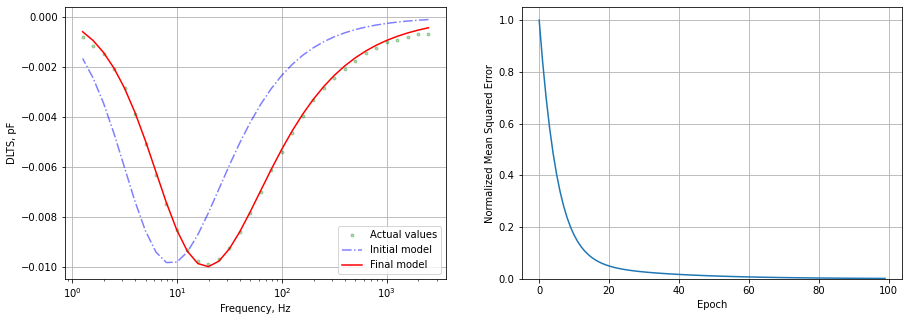

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -1.2979 log10(s)
Time constant = 5.0357e-02 s
Amplitude = -9.8640e-03 pF
P = 1.0000
MSE = 5.0511e-06
RMSE = 2.2475e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -1.6311 log10(s)
Time constant = 2.3383e-02 s
Amplitude = -9.9799e-03 pF
P = 0.8208
MSE = 1.1583e-08
RMSE = 1.0763e-04


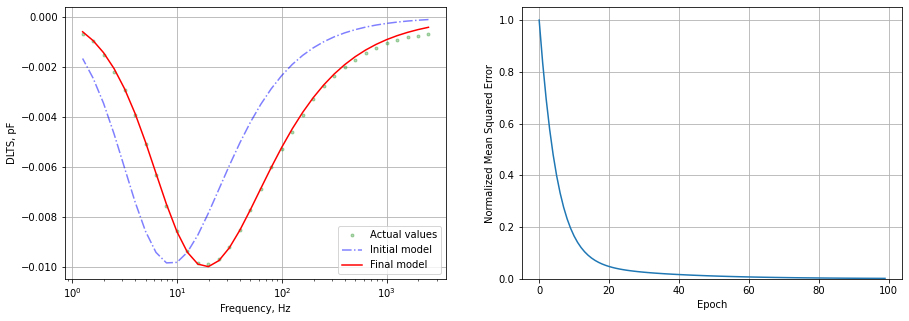

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -1.2979 log10(s)
Time constant = 5.0357e-02 s
Amplitude = -9.8480e-03 pF
P = 1.0000
MSE = 4.9906e-06
RMSE = 2.2340e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -1.6297 log10(s)
Time constant = 2.3456e-02 s
Amplitude = -9.9608e-03 pF
P = 0.8227
MSE = 1.5185e-08
RMSE = 1.2323e-04


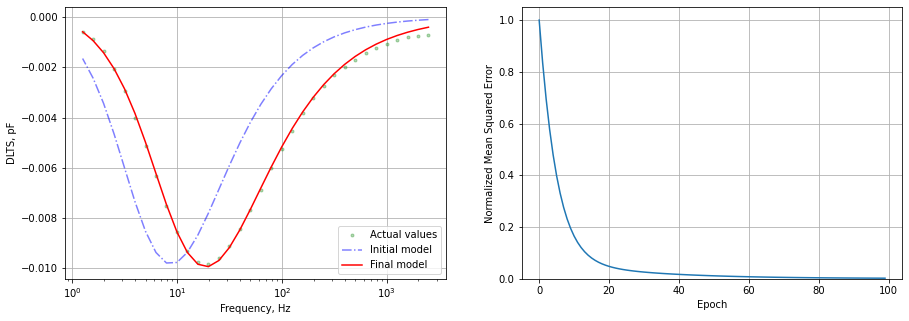

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -1.6979 log10(s)
Time constant = 2.0047e-02 s
Amplitude = -2.4240e-03 pF
P = 1.0000
MSE = 4.4538e-07
RMSE = 6.6737e-04

Final values
Filling pulse = 2.0000e-05
Time constant power = -2.0265 log10(s)
Time constant = 9.4070e-03 s
Amplitude = -2.4914e-03 pF
P = 0.4915
MSE = 2.7622e-09
RMSE = 5.2557e-05


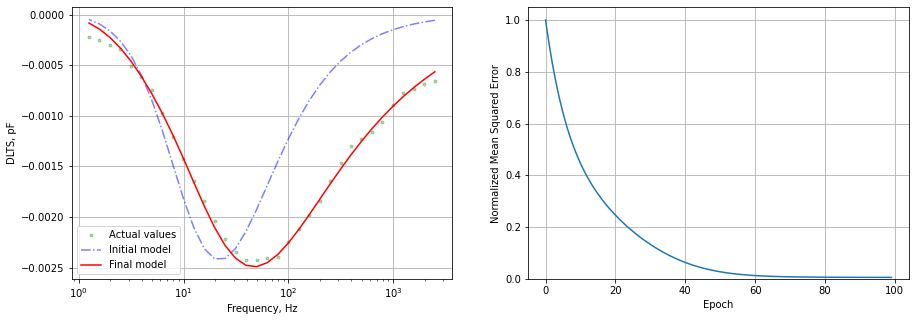

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -1.3979 log10(s)
Time constant = 4.0000e-02 s
Amplitude = -6.1120e-03 pF
P = 1.0000
MSE = 2.6848e-06
RMSE = 1.6385e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -1.7819 log10(s)
Time constant = 1.6525e-02 s
Amplitude = -6.2268e-03 pF
P = 0.6732
MSE = 7.2723e-09
RMSE = 8.5278e-05


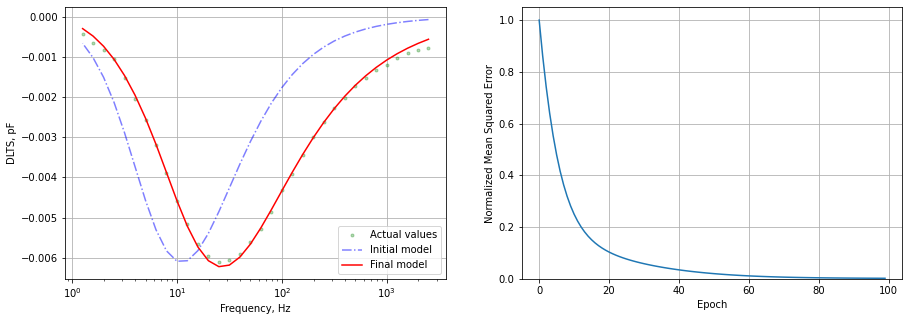

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -1.3979 log10(s)
Time constant = 4.0000e-02 s
Amplitude = -7.9790e-03 pF
P = 1.0000
MSE = 3.1868e-06
RMSE = 1.7852e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -1.7127 log10(s)
Time constant = 1.9376e-02 s
Amplitude = -8.1185e-03 pF
P = 0.7343
MSE = 9.3257e-09
RMSE = 9.6570e-05


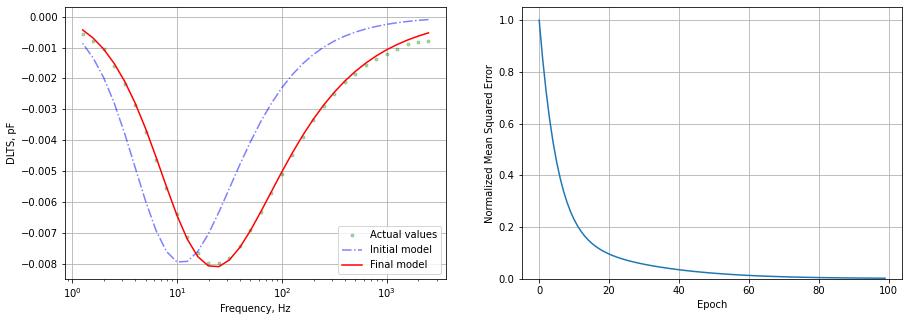

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -1.2979 log10(s)
Time constant = 5.0357e-02 s
Amplitude = -8.8980e-03 pF
P = 1.0000
MSE = 5.3925e-06
RMSE = 2.3222e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -1.6824 log10(s)
Time constant = 2.0777e-02 s
Amplitude = -9.0291e-03 pF
P = 0.7713
MSE = 9.1847e-09
RMSE = 9.5837e-05


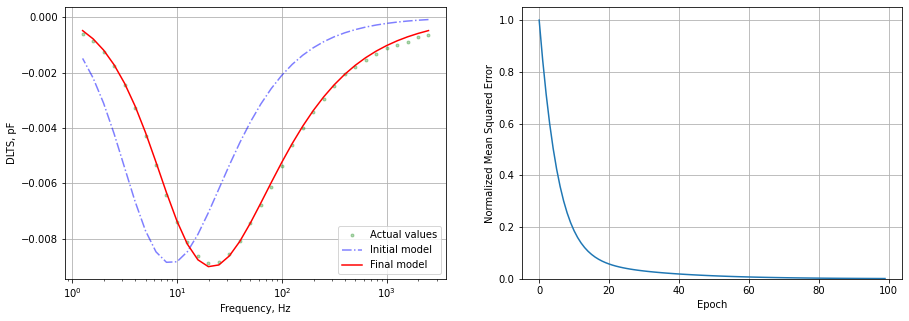

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -1.2979 log10(s)
Time constant = 5.0357e-02 s
Amplitude = -9.3800e-03 pF
P = 1.0000
MSE = 5.4568e-06
RMSE = 2.3360e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -1.6635 log10(s)
Time constant = 2.1700e-02 s
Amplitude = -9.5123e-03 pF
P = 0.7861
MSE = 9.4368e-09
RMSE = 9.7143e-05


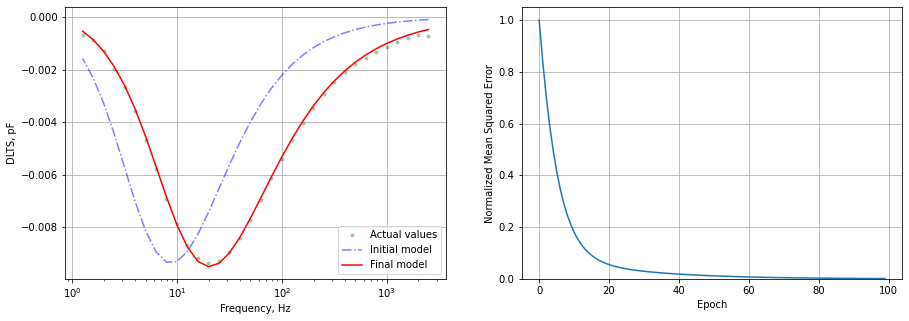

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -1.2979 log10(s)
Time constant = 5.0357e-02 s
Amplitude = -9.6440e-03 pF
P = 1.0000
MSE = 5.4651e-06
RMSE = 2.3378e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -1.6533 log10(s)
Time constant = 2.2216e-02 s
Amplitude = -9.7739e-03 pF
P = 0.8040
MSE = 9.3385e-09
RMSE = 9.6636e-05


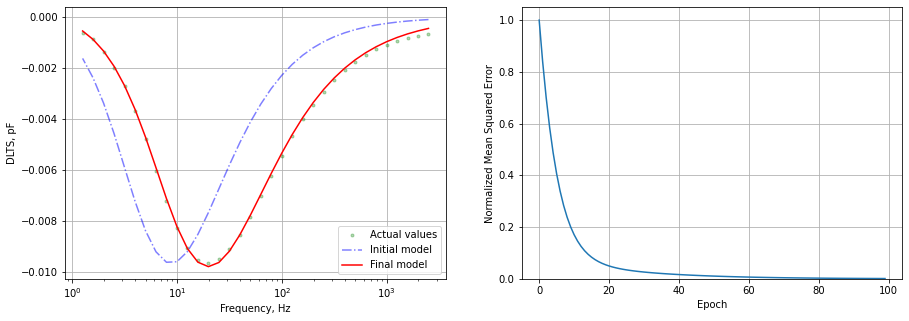

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -1.2979 log10(s)
Time constant = 5.0357e-02 s
Amplitude = -9.8200e-03 pF
P = 1.0000
MSE = 5.4138e-06
RMSE = 2.3268e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -1.6462 log10(s)
Time constant = 2.2583e-02 s
Amplitude = -9.9325e-03 pF
P = 0.8117
MSE = 1.1795e-08
RMSE = 1.0861e-04


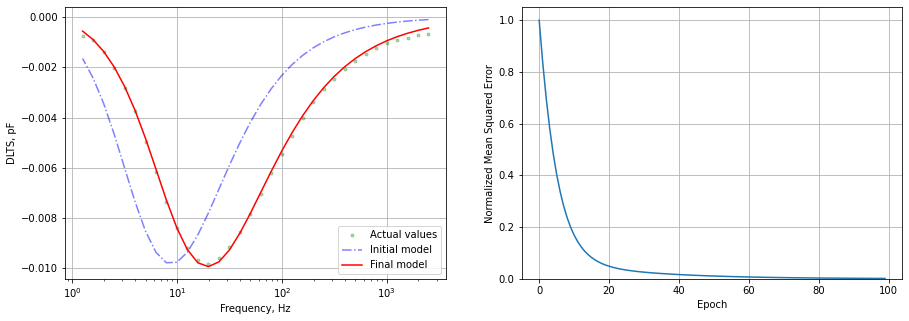

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -1.2979 log10(s)
Time constant = 5.0357e-02 s
Amplitude = -9.8800e-03 pF
P = 1.0000
MSE = 5.3376e-06
RMSE = 2.3103e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -1.6407 log10(s)
Time constant = 2.2871e-02 s
Amplitude = -9.9953e-03 pF
P = 0.8124
MSE = 1.2919e-08
RMSE = 1.1366e-04


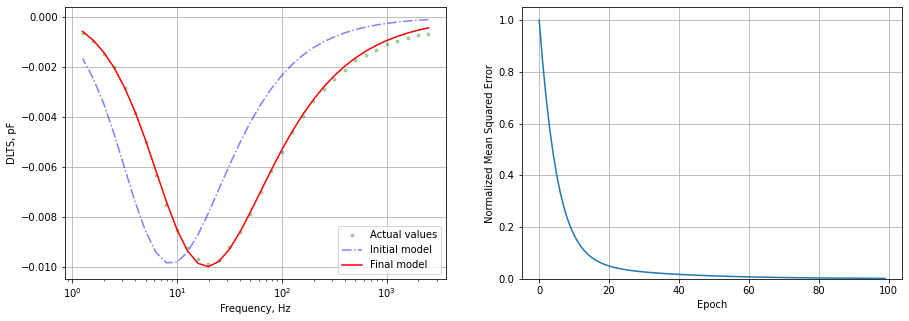

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -1.2979 log10(s)
Time constant = 5.0357e-02 s
Amplitude = -8.5670e-03 pF
P = 1.0000
MSE = 4.3102e-06
RMSE = 2.0761e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -1.6521 log10(s)
Time constant = 2.2278e-02 s
Amplitude = -8.6870e-03 pF
P = 0.7898
MSE = 1.1465e-08
RMSE = 1.0707e-04


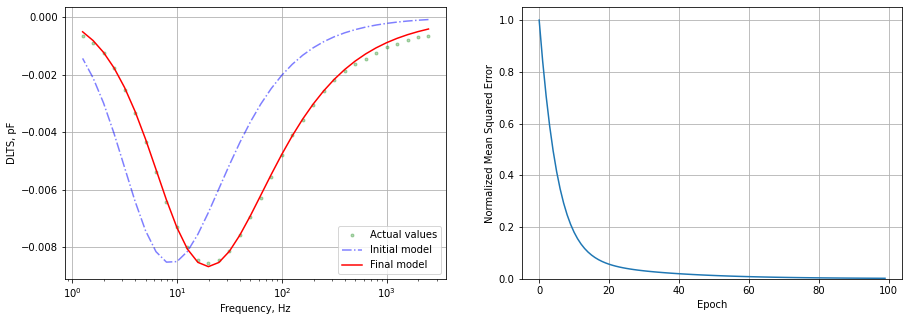

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -1.2979 log10(s)
Time constant = 5.0357e-02 s
Amplitude = -8.7410e-03 pF
P = 1.0000
MSE = 4.3282e-06
RMSE = 2.0804e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -1.6460 log10(s)
Time constant = 2.2593e-02 s
Amplitude = -8.8544e-03 pF
P = 0.8006
MSE = 1.1870e-08
RMSE = 1.0895e-04


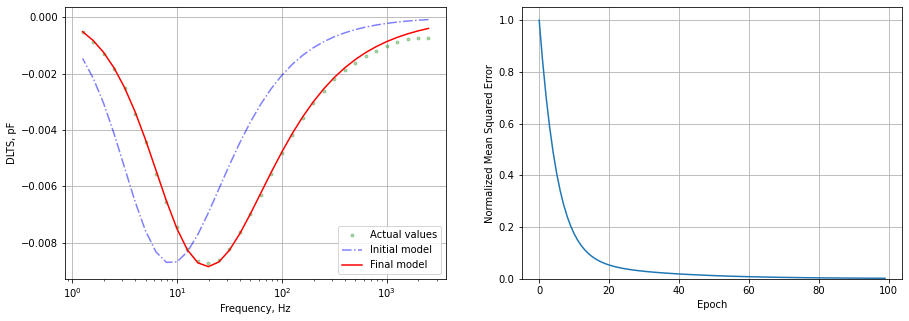

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -1.2979 log10(s)
Time constant = 5.0357e-02 s
Amplitude = -8.7900e-03 pF
P = 1.0000
MSE = 4.2004e-06
RMSE = 2.0495e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -1.6396 log10(s)
Time constant = 2.2931e-02 s
Amplitude = -8.8906e-03 pF
P = 0.8154
MSE = 1.2546e-08
RMSE = 1.1201e-04


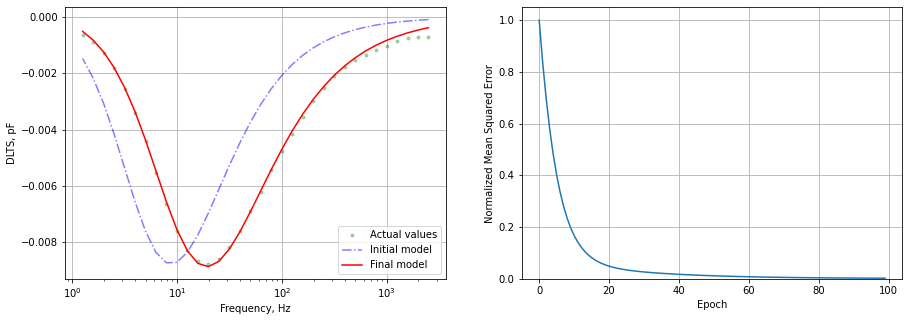

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -1.8979 log10(s)
Time constant = 1.2649e-02 s
Amplitude = -1.2642e-03 pF
P = 1.0000
MSE = 1.1725e-07
RMSE = 3.4242e-04

Final values
Filling pulse = 2.0000e-05
Time constant power = -2.1306 log10(s)
Time constant = 7.4034e-03 s
Amplitude = -1.2886e-03 pF
P = 0.4025
MSE = 4.1945e-09
RMSE = 6.4765e-05


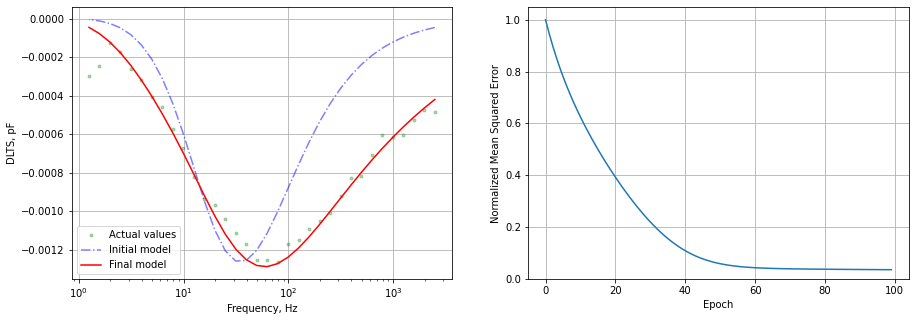

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -1.4979 log10(s)
Time constant = 3.1773e-02 s
Amplitude = -3.9190e-03 pF
P = 1.0000
MSE = 9.5832e-07
RMSE = 9.7894e-04

Final values
Filling pulse = 2.0000e-05
Time constant power = -1.8295 log10(s)
Time constant = 1.4809e-02 s
Amplitude = -4.0097e-03 pF
P = 0.6146
MSE = 5.9983e-09
RMSE = 7.7449e-05


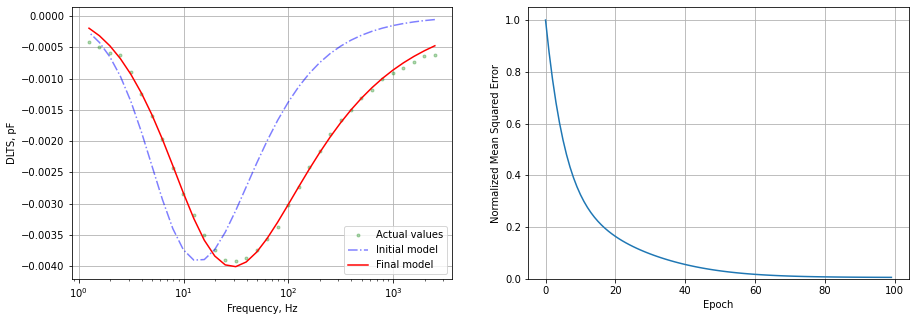

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -1.3979 log10(s)
Time constant = 4.0000e-02 s
Amplitude = -5.7970e-03 pF
P = 1.0000
MSE = 1.8887e-06
RMSE = 1.3743e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -1.7294 log10(s)
Time constant = 1.8646e-02 s
Amplitude = -5.9029e-03 pF
P = 0.6971
MSE = 7.2423e-09
RMSE = 8.5102e-05


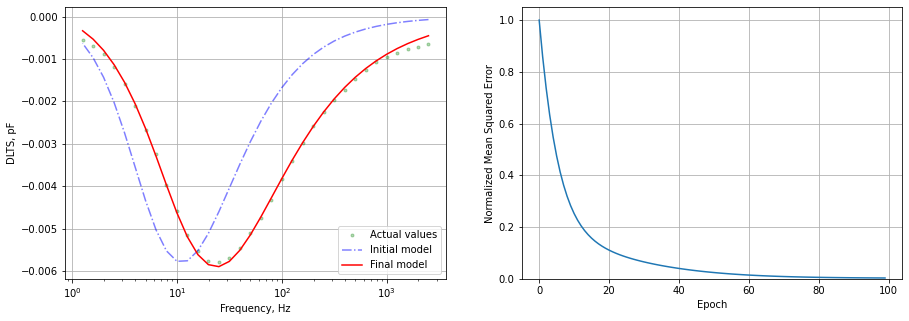

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -1.3979 log10(s)
Time constant = 4.0000e-02 s
Amplitude = -6.9470e-03 pF
P = 1.0000
MSE = 2.2367e-06
RMSE = 1.4956e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -1.6987 log10(s)
Time constant = 2.0013e-02 s
Amplitude = -7.0638e-03 pF
P = 0.7367
MSE = 9.2776e-09
RMSE = 9.6320e-05


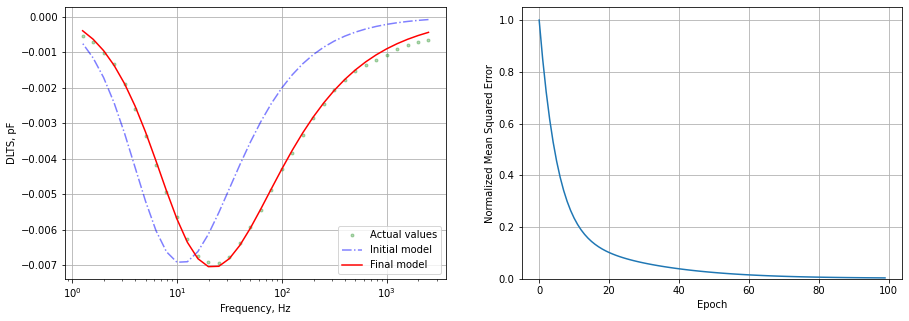

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -1.2979 log10(s)
Time constant = 5.0357e-02 s
Amplitude = -7.6190e-03 pF
P = 1.0000
MSE = 3.9030e-06
RMSE = 1.9756e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -1.6772 log10(s)
Time constant = 2.1027e-02 s
Amplitude = -7.7410e-03 pF
P = 0.7578
MSE = 7.1875e-09
RMSE = 8.4779e-05


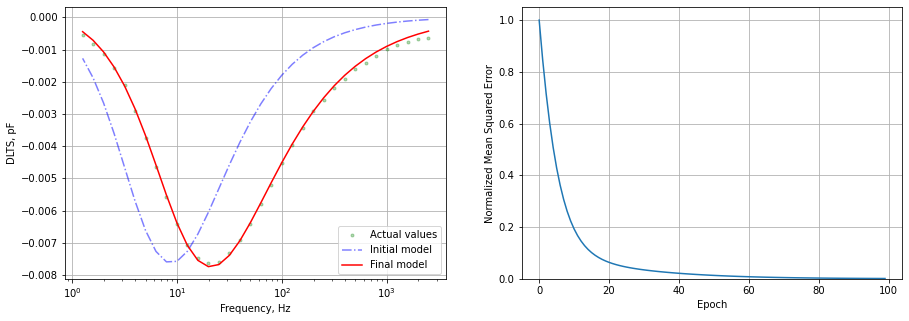

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -1.2979 log10(s)
Time constant = 5.0357e-02 s
Amplitude = -8.0610e-03 pF
P = 1.0000
MSE = 4.0964e-06
RMSE = 2.0240e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -1.6657 log10(s)
Time constant = 2.1593e-02 s
Amplitude = -8.1743e-03 pF
P = 0.7750
MSE = 1.0705e-08
RMSE = 1.0347e-04


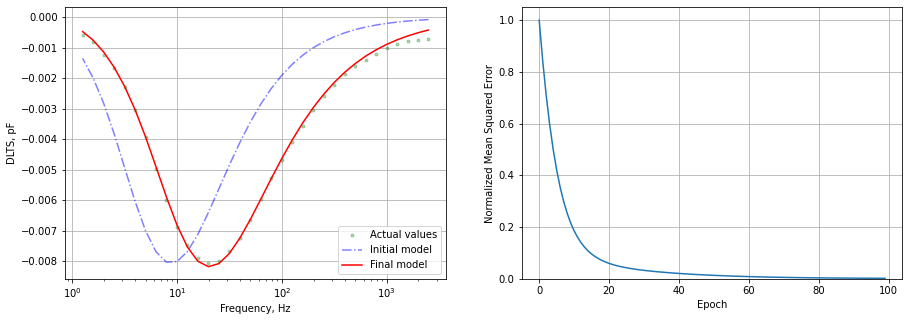

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -1.2979 log10(s)
Time constant = 5.0357e-02 s
Amplitude = -8.3640e-03 pF
P = 1.0000
MSE = 4.1723e-06
RMSE = 2.0426e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -1.6548 log10(s)
Time constant = 2.2143e-02 s
Amplitude = -8.4818e-03 pF
P = 0.7823
MSE = 1.1801e-08
RMSE = 1.0863e-04


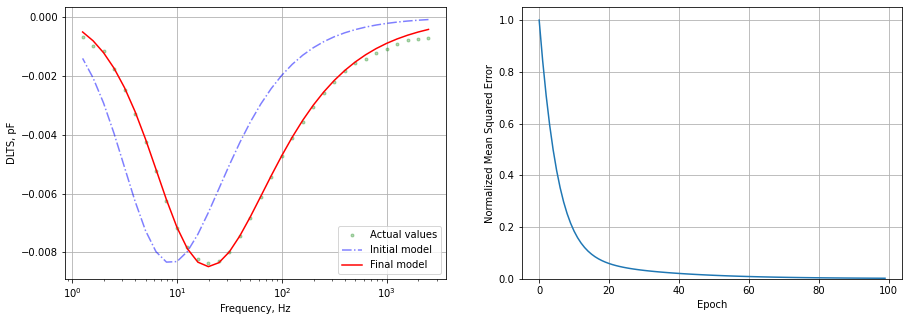

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -1.2979 log10(s)
Time constant = 5.0357e-02 s
Amplitude = -7.2470e-03 pF
P = 1.0000
MSE = 3.2977e-06
RMSE = 1.8159e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -1.6650 log10(s)
Time constant = 2.1627e-02 s
Amplitude = -7.3494e-03 pF
P = 0.7698
MSE = 7.7212e-09
RMSE = 8.7871e-05


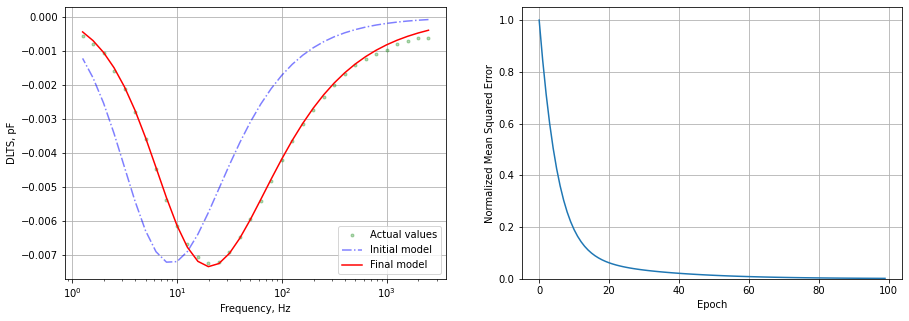

Initial values:
Filling pulse = 1.0000e-04
Time constant power = -1.2979 log10(s)
Time constant = 5.0357e-02 s
Amplitude = -7.5610e-03 pF
P = 1.0000
MSE = 3.4807e-06
RMSE = 1.8657e-03

Final values
Filling pulse = 1.0000e-04
Time constant power = -1.6612 log10(s)
Time constant = 2.1819e-02 s
Amplitude = -7.6548e-03 pF
P = 0.7663
MSE = 2.3227e-08
RMSE = 1.5240e-04


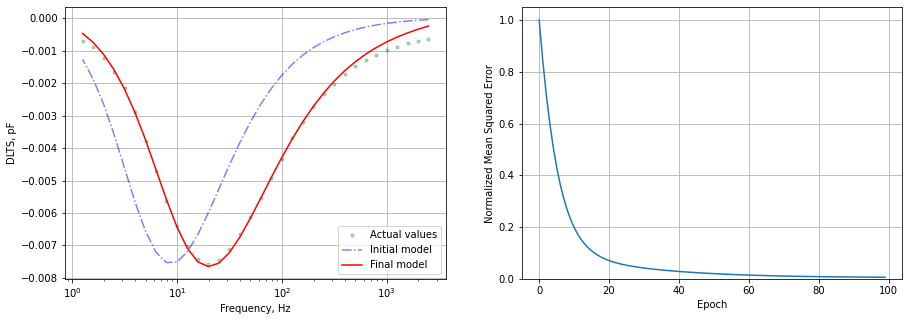

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -1.2979 log10(s)
Time constant = 5.0357e-02 s
Amplitude = -7.7190e-03 pF
P = 1.0000
MSE = 3.5025e-06
RMSE = 1.8715e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -1.6517 log10(s)
Time constant = 2.2300e-02 s
Amplitude = -7.8250e-03 pF
P = 0.7762
MSE = 1.1057e-08
RMSE = 1.0515e-04


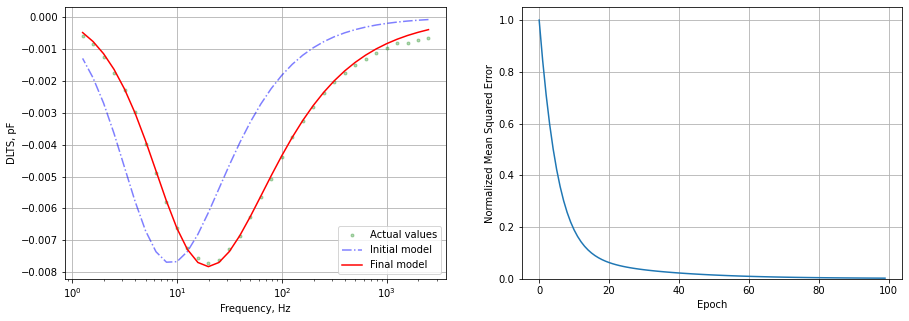

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -1.8979 log10(s)
Time constant = 1.2649e-02 s
Amplitude = -7.7620e-04 pF
P = 1.0000
MSE = 6.3728e-08
RMSE = 2.5244e-04

Final values
Filling pulse = 2.0000e-05
Time constant power = -2.1673 log10(s)
Time constant = 6.8037e-03 s
Amplitude = -7.8412e-04 pF
P = 0.3091
MSE = 2.7443e-09
RMSE = 5.2386e-05


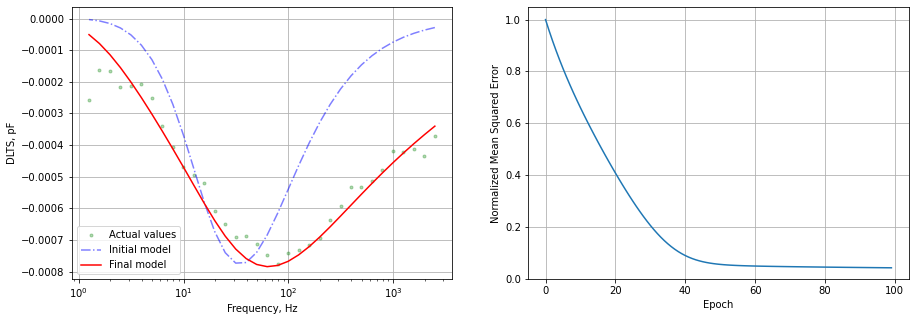

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -1.5979 log10(s)
Time constant = 2.5238e-02 s
Amplitude = -2.6460e-03 pF
P = 1.0000
MSE = 3.4214e-07
RMSE = 5.8492e-04

Final values
Filling pulse = 2.0000e-05
Time constant power = -1.8554 log10(s)
Time constant = 1.3950e-02 s
Amplitude = -2.7109e-03 pF
P = 0.5851
MSE = 4.1667e-09
RMSE = 6.4550e-05


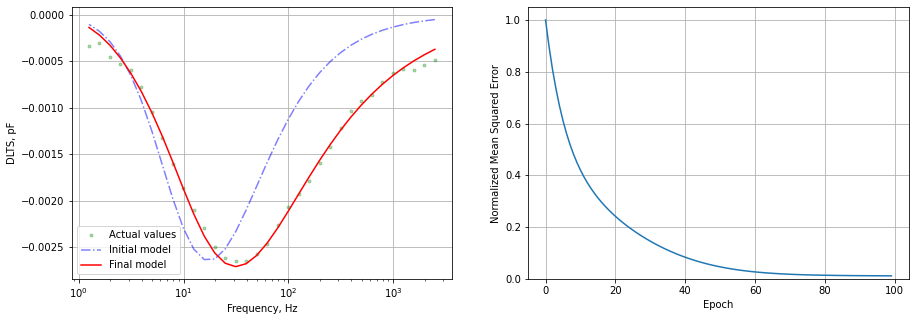

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -1.3979 log10(s)
Time constant = 4.0000e-02 s
Amplitude = -4.4790e-03 pF
P = 1.0000
MSE = 1.2993e-06
RMSE = 1.1399e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -1.7593 log10(s)
Time constant = 1.7406e-02 s
Amplitude = -4.5536e-03 pF
P = 0.6752
MSE = 6.2124e-09
RMSE = 7.8819e-05


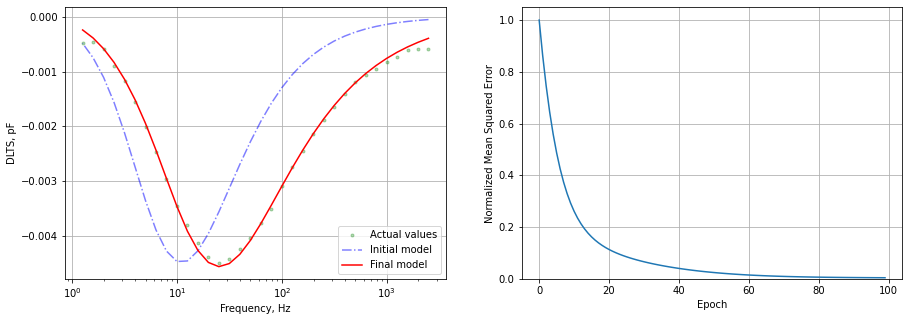

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -1.3979 log10(s)
Time constant = 4.0000e-02 s
Amplitude = -5.5600e-03 pF
P = 1.0000
MSE = 1.5500e-06
RMSE = 1.2450e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -1.7078 log10(s)
Time constant = 1.9599e-02 s
Amplitude = -5.6574e-03 pF
P = 0.7070
MSE = 8.6631e-09
RMSE = 9.3076e-05


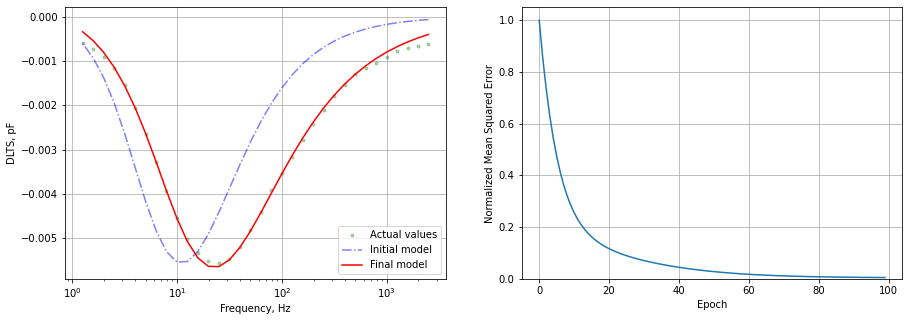

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -1.2979 log10(s)
Time constant = 5.0357e-02 s
Amplitude = -6.2770e-03 pF
P = 1.0000
MSE = 2.8178e-06
RMSE = 1.6786e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -1.6887 log10(s)
Time constant = 2.0478e-02 s
Amplitude = -6.3821e-03 pF
P = 0.7361
MSE = 8.3149e-09
RMSE = 9.1186e-05


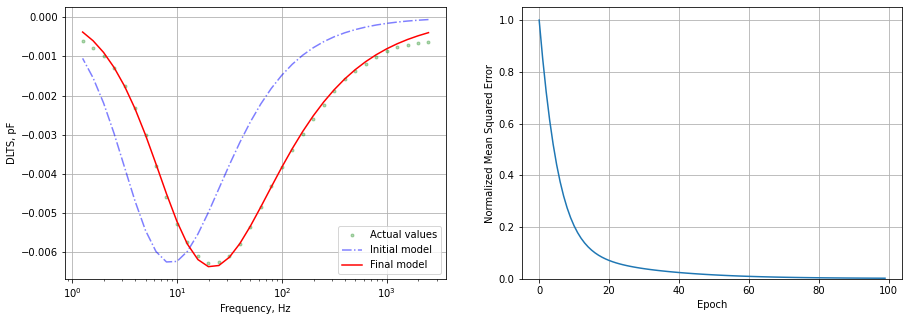

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -1.2979 log10(s)
Time constant = 5.0357e-02 s
Amplitude = -6.7970e-03 pF
P = 1.0000
MSE = 3.0534e-06
RMSE = 1.7474e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -1.6735 log10(s)
Time constant = 2.1210e-02 s
Amplitude = -6.9044e-03 pF
P = 0.7519
MSE = 6.7897e-09
RMSE = 8.2399e-05


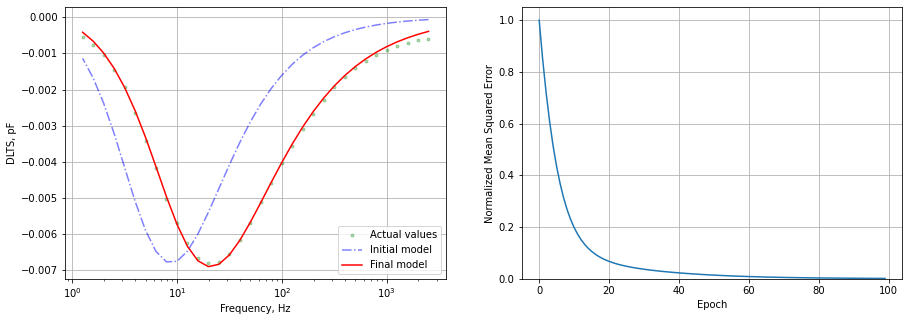

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -1.2979 log10(s)
Time constant = 5.0357e-02 s
Amplitude = -5.9330e-03 pF
P = 1.0000
MSE = 2.4827e-06
RMSE = 1.5756e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -1.6888 log10(s)
Time constant = 2.0476e-02 s
Amplitude = -6.0169e-03 pF
P = 0.7444
MSE = 6.6450e-09
RMSE = 8.1517e-05


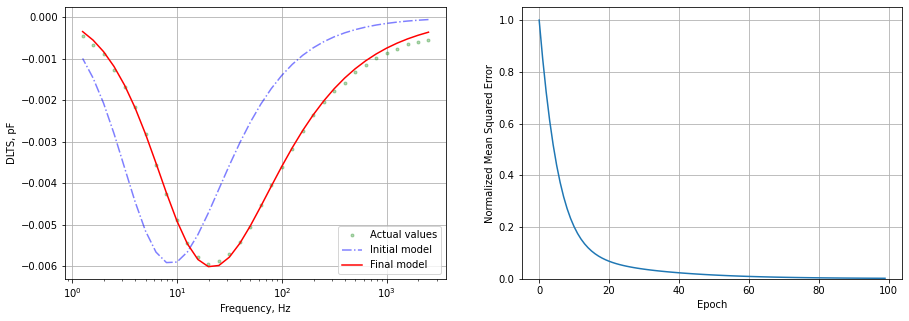

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -1.2979 log10(s)
Time constant = 5.0357e-02 s
Amplitude = -6.3610e-03 pF
P = 1.0000
MSE = 2.7099e-06
RMSE = 1.6462e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -1.6761 log10(s)
Time constant = 2.1081e-02 s
Amplitude = -6.4596e-03 pF
P = 0.7525
MSE = 8.1479e-09
RMSE = 9.0266e-05


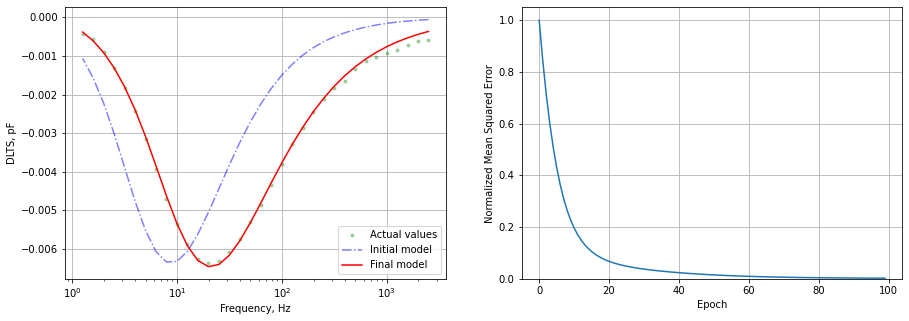

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -1.2979 log10(s)
Time constant = 5.0357e-02 s
Amplitude = -6.6950e-03 pF
P = 1.0000
MSE = 2.7966e-06
RMSE = 1.6723e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -1.6639 log10(s)
Time constant = 2.1681e-02 s
Amplitude = -6.7845e-03 pF
P = 0.7647
MSE = 7.2614e-09
RMSE = 8.5214e-05


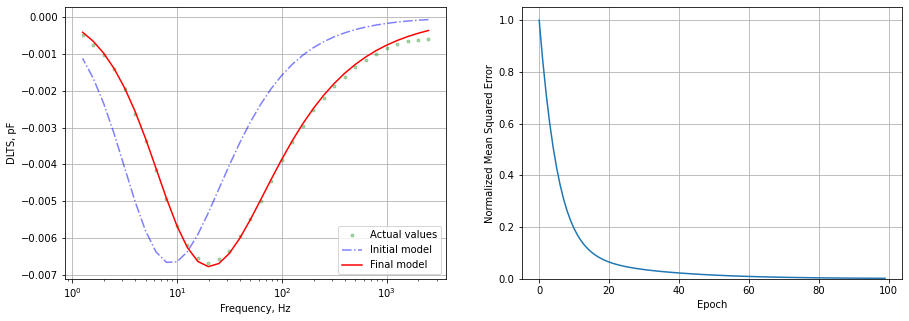

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -1.7979 log10(s)
Time constant = 1.5924e-02 s
Amplitude = -5.1260e-04 pF
P = 1.0000
MSE = 5.1162e-08
RMSE = 2.2619e-04

Final values
Filling pulse = 2.0000e-05
Time constant power = -2.3033 log10(s)
Time constant = 4.9741e-03 s
Amplitude = -5.2124e-04 pF
P = 0.2013
MSE = 2.4774e-09
RMSE = 4.9774e-05


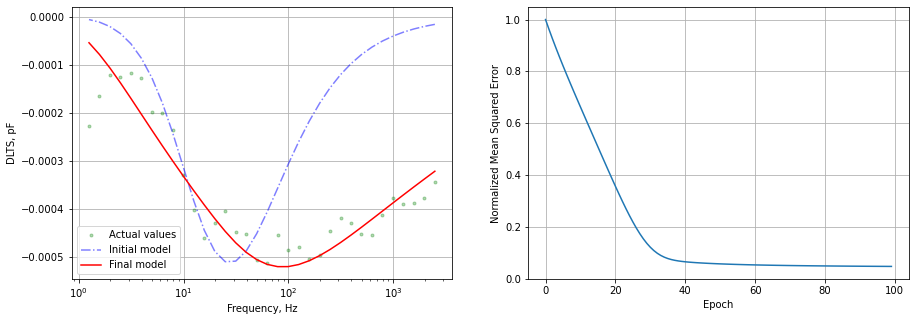

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -1.4979 log10(s)
Time constant = 3.1773e-02 s
Amplitude = -1.9625e-03 pF
P = 1.0000
MSE = 3.2367e-07
RMSE = 5.6892e-04

Final values
Filling pulse = 2.0000e-05
Time constant power = -1.8874 log10(s)
Time constant = 1.2959e-02 s
Amplitude = -2.0151e-03 pF
P = 0.5576
MSE = 1.9836e-09
RMSE = 4.4538e-05


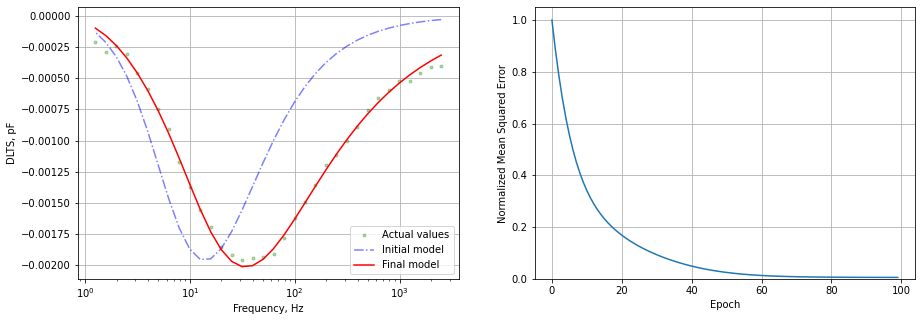

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -1.3979 log10(s)
Time constant = 4.0000e-02 s
Amplitude = -3.4325e-03 pF
P = 1.0000
MSE = 8.4976e-07
RMSE = 9.2182e-04

Final values
Filling pulse = 2.0000e-05
Time constant power = -1.7736 log10(s)
Time constant = 1.6841e-02 s
Amplitude = -3.5050e-03 pF
P = 0.6410
MSE = 3.7401e-09
RMSE = 6.1156e-05


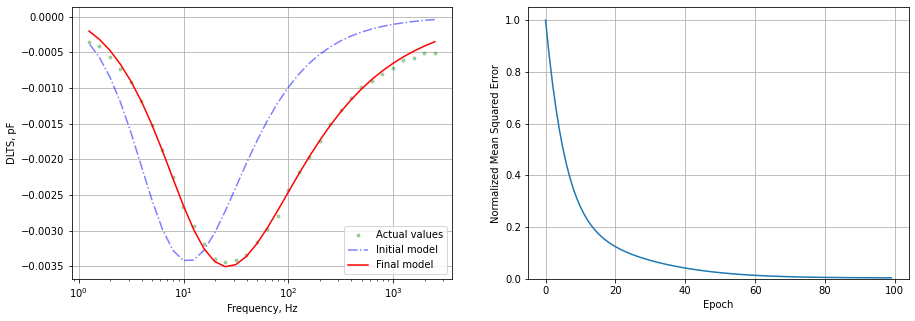

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -1.3979 log10(s)
Time constant = 4.0000e-02 s
Amplitude = -4.5620e-03 pF
P = 1.0000
MSE = 1.1814e-06
RMSE = 1.0869e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -1.7279 log10(s)
Time constant = 1.8710e-02 s
Amplitude = -4.6529e-03 pF
P = 0.6857
MSE = 6.0576e-09
RMSE = 7.7830e-05


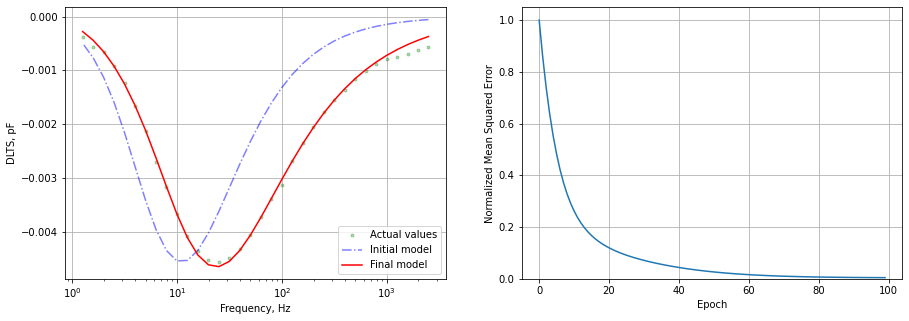

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -1.3979 log10(s)
Time constant = 4.0000e-02 s
Amplitude = -5.3460e-03 pF
P = 1.0000
MSE = 1.3891e-06
RMSE = 1.1786e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -1.7065 log10(s)
Time constant = 1.9658e-02 s
Amplitude = -5.4392e-03 pF
P = 0.7320
MSE = 5.8471e-09
RMSE = 7.6466e-05


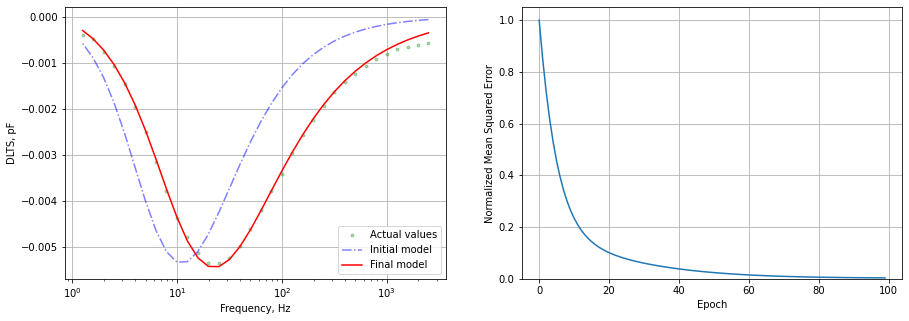

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -1.3979 log10(s)
Time constant = 4.0000e-02 s
Amplitude = -6.3740e-03 pF
P = 1.0000
MSE = 1.9854e-06
RMSE = 1.4090e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -1.7066 log10(s)
Time constant = 1.9650e-02 s
Amplitude = -6.4912e-03 pF
P = 0.7323
MSE = 8.0485e-09
RMSE = 8.9713e-05


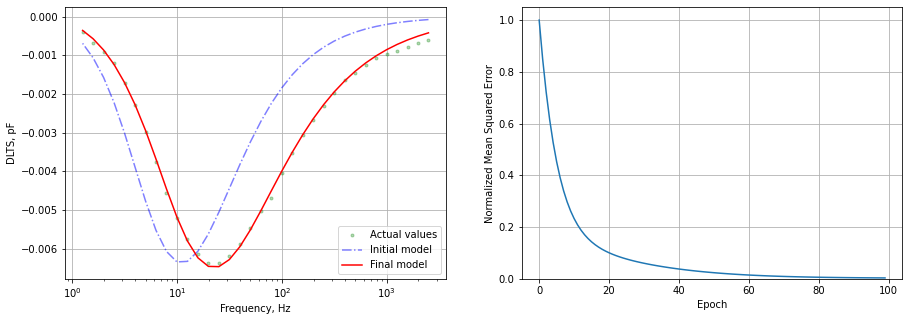

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -1.2979 log10(s)
Time constant = 5.0357e-02 s
Amplitude = -7.1940e-03 pF
P = 1.0000
MSE = 3.5977e-06
RMSE = 1.8968e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -1.6857 log10(s)
Time constant = 2.0623e-02 s
Amplitude = -7.2982e-03 pF
P = 0.7572
MSE = 1.0421e-08
RMSE = 1.0208e-04


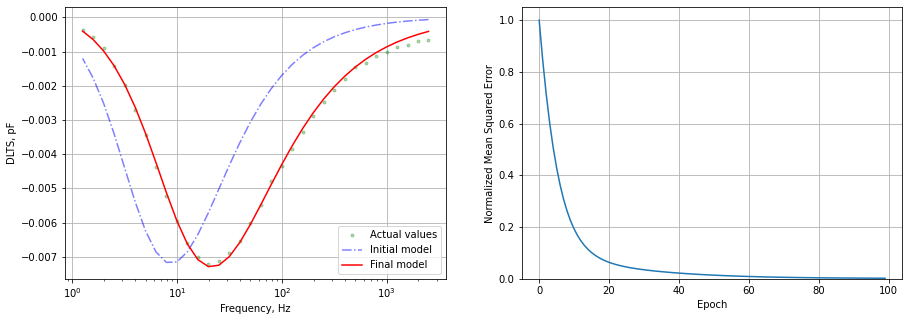

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -1.2979 log10(s)
Time constant = 5.0357e-02 s
Amplitude = -7.8310e-03 pF
P = 1.0000
MSE = 4.0125e-06
RMSE = 2.0031e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -1.6721 log10(s)
Time constant = 2.1274e-02 s
Amplitude = -7.9480e-03 pF
P = 0.7601
MSE = 1.0850e-08
RMSE = 1.0416e-04


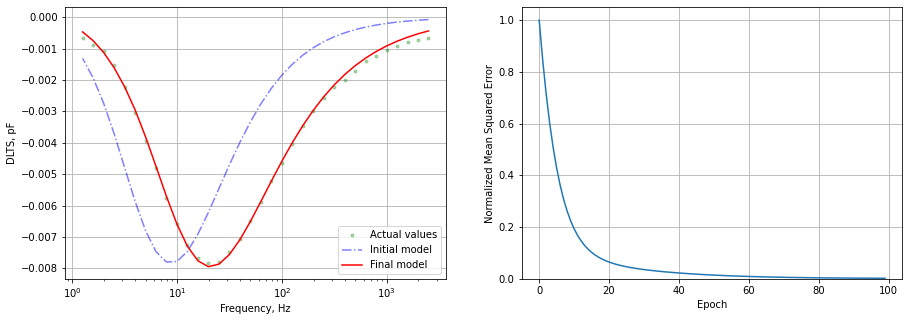

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -1.8979 log10(s)
Time constant = 1.2649e-02 s
Amplitude = -5.1500e-04 pF
P = 1.0000
MSE = 3.8647e-08
RMSE = 1.9659e-04

Final values
Filling pulse = 2.0000e-05
Time constant power = -2.5288 log10(s)
Time constant = 2.9594e-03 s
Amplitude = -5.0094e-04 pF
P = 0.3225
MSE = 2.4583e-09
RMSE = 4.9581e-05


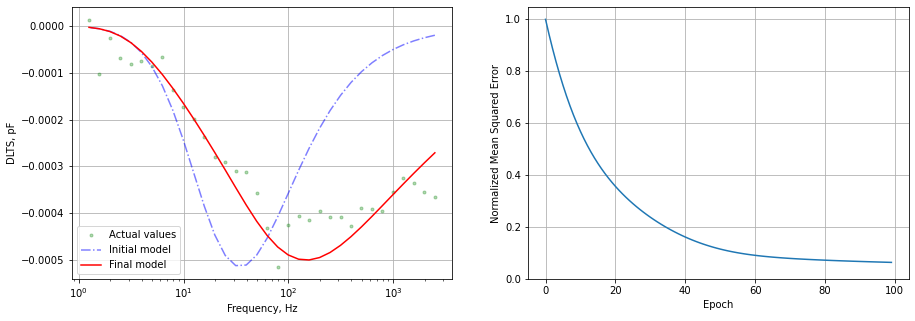

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -1.5979 log10(s)
Time constant = 2.5238e-02 s
Amplitude = -1.9055e-03 pF
P = 1.0000
MSE = 2.7855e-07
RMSE = 5.2778e-04

Final values
Filling pulse = 2.0000e-05
Time constant power = -1.9528 log10(s)
Time constant = 1.1147e-02 s
Amplitude = -1.9546e-03 pF
P = 0.5244
MSE = 1.6895e-09
RMSE = 4.1104e-05


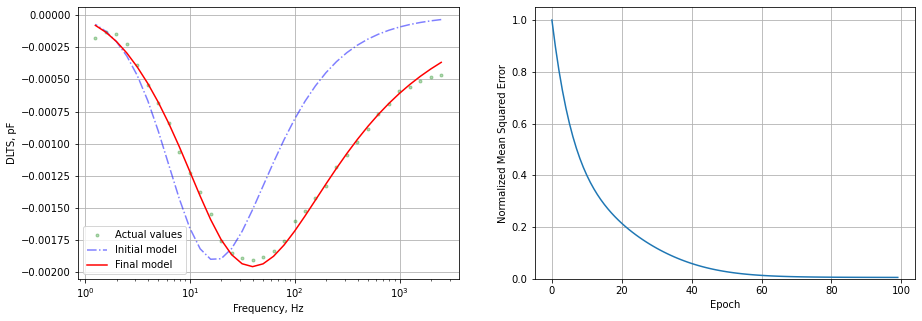

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -1.3979 log10(s)
Time constant = 4.0000e-02 s
Amplitude = -3.7450e-03 pF
P = 1.0000
MSE = 1.1269e-06
RMSE = 1.0616e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -1.7961 log10(s)
Time constant = 1.5993e-02 s
Amplitude = -3.8368e-03 pF
P = 0.6305
MSE = 3.9879e-09
RMSE = 6.3150e-05


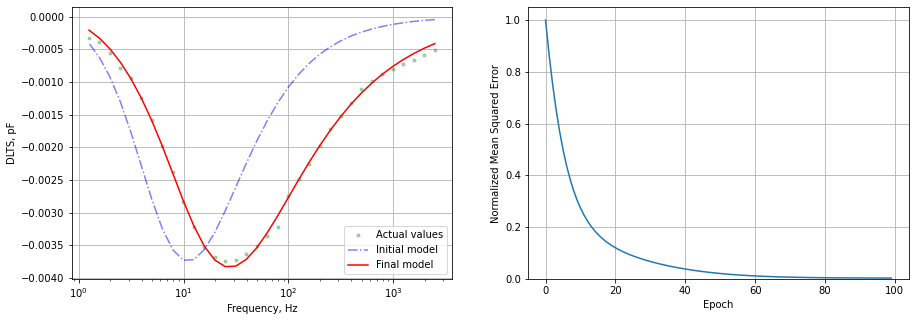

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -1.3979 log10(s)
Time constant = 4.0000e-02 s
Amplitude = -5.2570e-03 pF
P = 1.0000
MSE = 1.5756e-06
RMSE = 1.2552e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -1.7347 log10(s)
Time constant = 1.8419e-02 s
Amplitude = -5.3472e-03 pF
P = 0.7019
MSE = 5.5010e-09
RMSE = 7.4168e-05


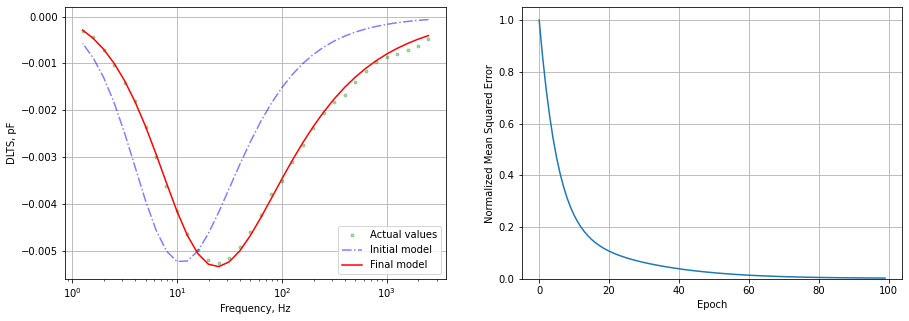

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -1.3979 log10(s)
Time constant = 4.0000e-02 s
Amplitude = -4.3980e-03 pF
P = 1.0000
MSE = 1.2226e-06
RMSE = 1.1057e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -1.7520 log10(s)
Time constant = 1.7700e-02 s
Amplitude = -4.4869e-03 pF
P = 0.6840
MSE = 3.7049e-09
RMSE = 6.0868e-05


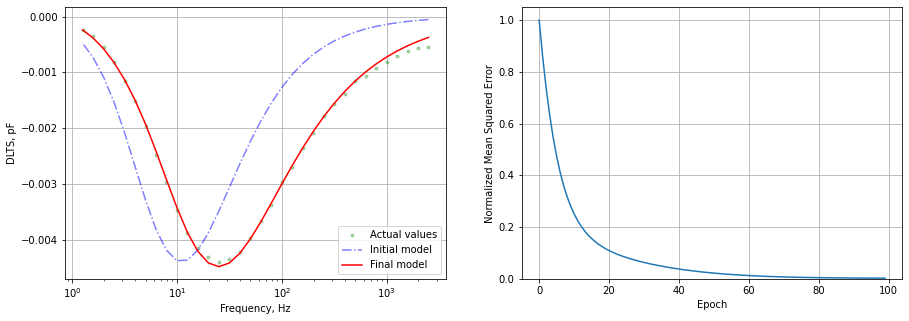

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -1.3979 log10(s)
Time constant = 4.0000e-02 s
Amplitude = -5.4560e-03 pF
P = 1.0000
MSE = 1.6128e-06
RMSE = 1.2699e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -1.7210 log10(s)
Time constant = 1.9009e-02 s
Amplitude = -5.5728e-03 pF
P = 0.7108
MSE = 6.7580e-09
RMSE = 8.2207e-05


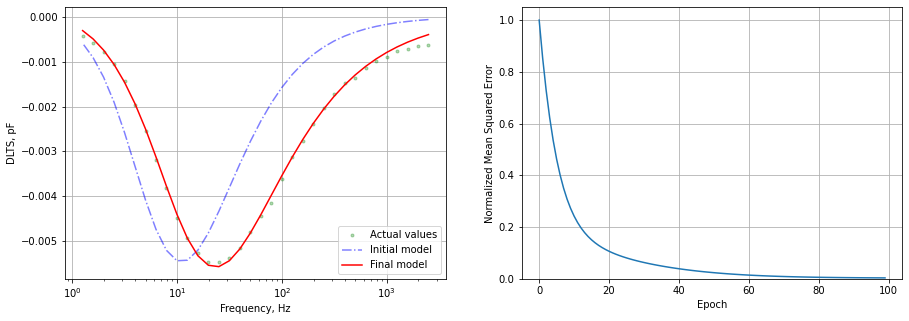

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -1.2979 log10(s)
Time constant = 5.0357e-02 s
Amplitude = -6.3070e-03 pF
P = 1.0000
MSE = 2.9731e-06
RMSE = 1.7243e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -1.6994 log10(s)
Time constant = 1.9980e-02 s
Amplitude = -6.4094e-03 pF
P = 0.7384
MSE = 8.2936e-09
RMSE = 9.1069e-05


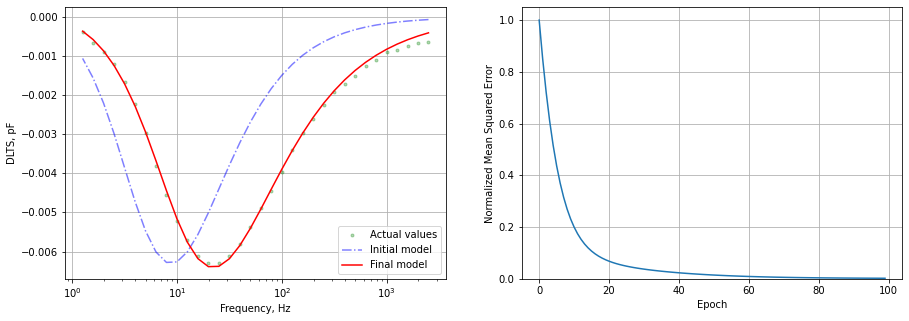

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -1.8979 log10(s)
Time constant = 1.2649e-02 s
Amplitude = -4.1360e-04 pF
P = 1.0000
MSE = 2.8401e-08
RMSE = 1.6853e-04

Final values
Filling pulse = 2.0000e-05
Time constant power = -2.6175 log10(s)
Time constant = 2.4129e-03 s
Amplitude = -3.9888e-04 pF
P = 0.3428
MSE = 2.4385e-09
RMSE = 4.9381e-05


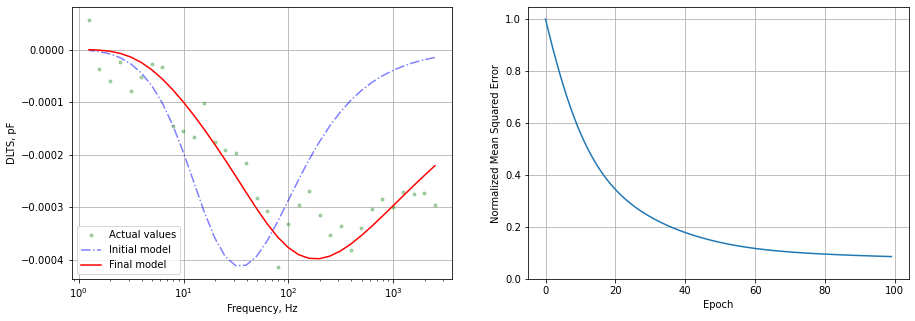

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -1.6979 log10(s)
Time constant = 2.0047e-02 s
Amplitude = -1.4475e-03 pF
P = 1.0000
MSE = 1.2384e-07
RMSE = 3.5190e-04

Final values
Filling pulse = 2.0000e-05
Time constant power = -1.9855 log10(s)
Time constant = 1.0339e-02 s
Amplitude = -1.4805e-03 pF
P = 0.5423
MSE = 4.0869e-09
RMSE = 6.3929e-05


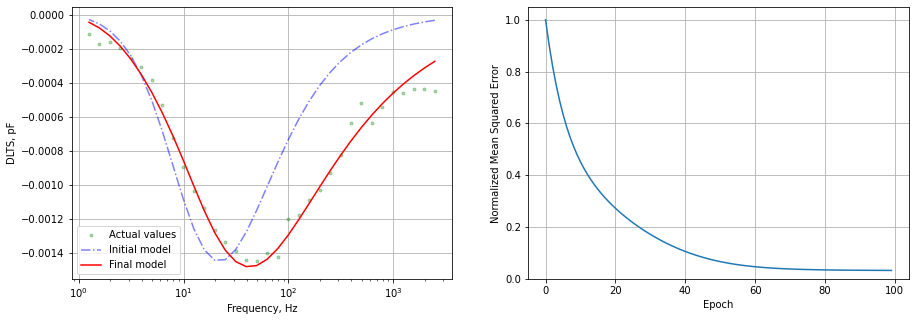

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -1.3979 log10(s)
Time constant = 4.0000e-02 s
Amplitude = -3.0110e-03 pF
P = 1.0000
MSE = 7.9062e-07
RMSE = 8.8917e-04

Final values
Filling pulse = 2.0000e-05
Time constant power = -1.8207 log10(s)
Time constant = 1.5110e-02 s
Amplitude = -3.0802e-03 pF
P = 0.6273
MSE = 3.4280e-09
RMSE = 5.8549e-05


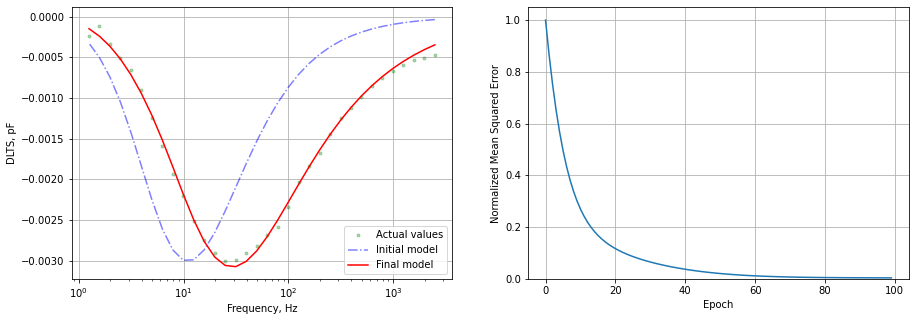

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -1.4979 log10(s)
Time constant = 3.1773e-02 s
Amplitude = -2.4730e-03 pF
P = 1.0000
MSE = 3.9530e-07
RMSE = 6.2873e-04

Final values
Filling pulse = 2.0000e-05
Time constant power = -1.8451 log10(s)
Time constant = 1.4286e-02 s
Amplitude = -2.5226e-03 pF
P = 0.6236
MSE = 5.4816e-09
RMSE = 7.4038e-05


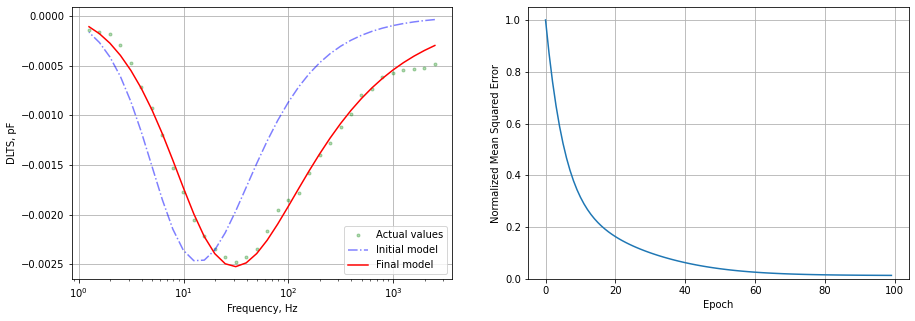

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -1.3979 log10(s)
Time constant = 4.0000e-02 s
Amplitude = -3.7365e-03 pF
P = 1.0000
MSE = 9.7722e-07
RMSE = 9.8855e-04

Final values
Filling pulse = 2.0000e-05
Time constant power = -1.7767 log10(s)
Time constant = 1.6721e-02 s
Amplitude = -3.8066e-03 pF
P = 0.6855
MSE = 4.6756e-09
RMSE = 6.8378e-05


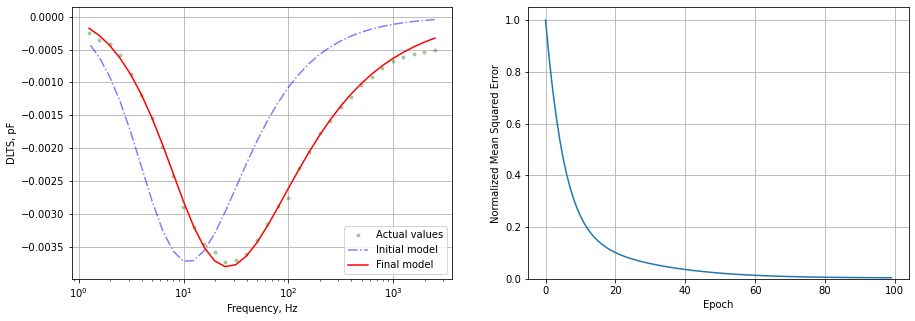

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -1.3979 log10(s)
Time constant = 4.0000e-02 s
Amplitude = -4.8030e-03 pF
P = 1.0000
MSE = 1.2896e-06
RMSE = 1.1356e-03

Final values
Filling pulse = 2.0000e-05
Time constant power = -1.7298 log10(s)
Time constant = 1.8628e-02 s
Amplitude = -4.8907e-03 pF
P = 0.7051
MSE = 5.7520e-09
RMSE = 7.5842e-05


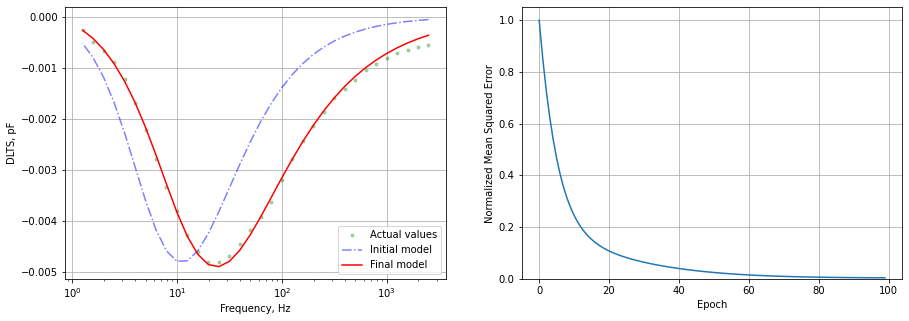

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -1.8979 log10(s)
Time constant = 1.2649e-02 s
Amplitude = -3.7860e-04 pF
P = 1.0000
MSE = 1.7974e-08
RMSE = 1.3407e-04

Final values
Filling pulse = 2.0000e-05
Time constant power = -2.4614 log10(s)
Time constant = 3.4564e-03 s
Amplitude = -3.5521e-04 pF
P = 0.4604
MSE = 3.8238e-09
RMSE = 6.1837e-05


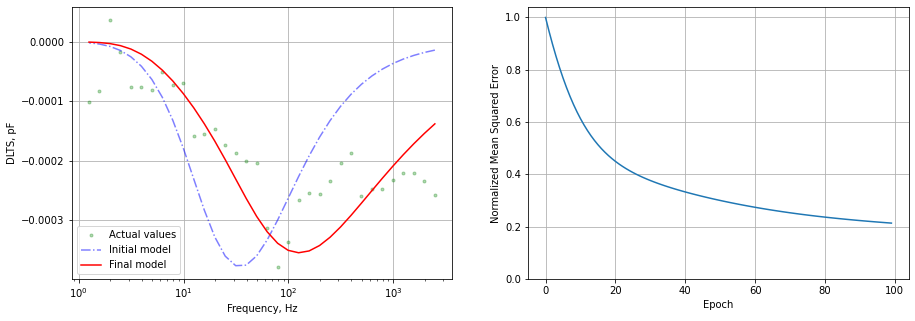

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -1.8979 log10(s)
Time constant = 1.2649e-02 s
Amplitude = -1.1905e-03 pF
P = 1.0000
MSE = 6.2351e-08
RMSE = 2.4970e-04

Final values
Filling pulse = 2.0000e-05
Time constant power = -2.0460 log10(s)
Time constant = 8.9947e-03 s
Amplitude = -1.2136e-03 pF
P = 0.4873
MSE = 2.2833e-09
RMSE = 4.7784e-05


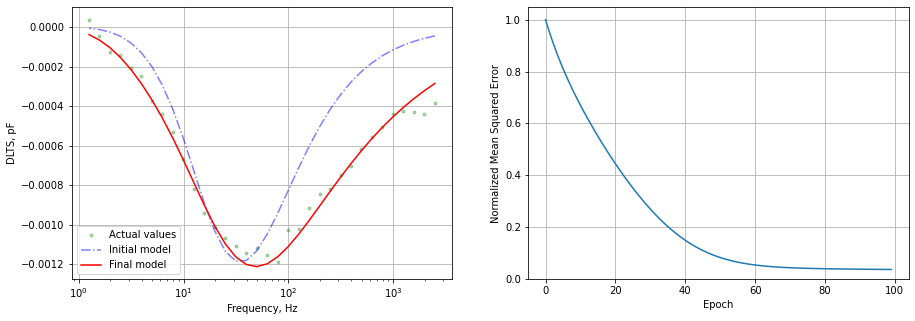

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -1.9979 log10(s)
Time constant = 1.0048e-02 s
Amplitude = -1.0368e-03 pF
P = 1.0000
MSE = 3.7686e-08
RMSE = 1.9413e-04

Final values
Filling pulse = 2.0000e-05
Time constant power = -2.0778 log10(s)
Time constant = 8.3601e-03 s
Amplitude = -1.0178e-03 pF
P = 0.5153
MSE = 7.3453e-09
RMSE = 8.5705e-05


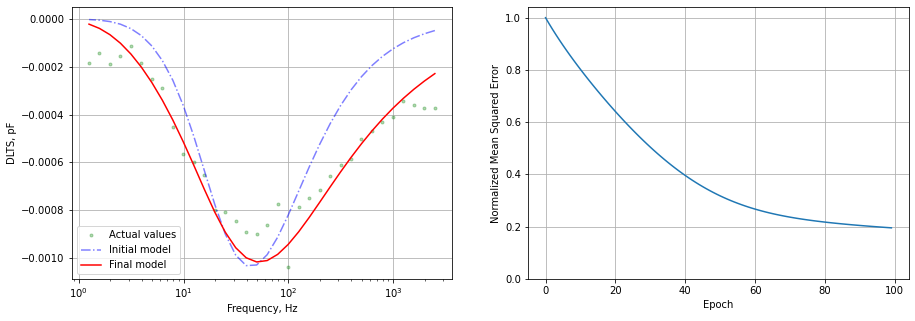

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -1.4979 log10(s)
Time constant = 3.1773e-02 s
Amplitude = -2.1035e-03 pF
P = 1.0000
MSE = 3.0471e-07
RMSE = 5.5200e-04

Final values
Filling pulse = 2.0000e-05
Time constant power = -1.8624 log10(s)
Time constant = 1.3727e-02 s
Amplitude = -2.1349e-03 pF
P = 0.6089
MSE = 4.1006e-09
RMSE = 6.4036e-05


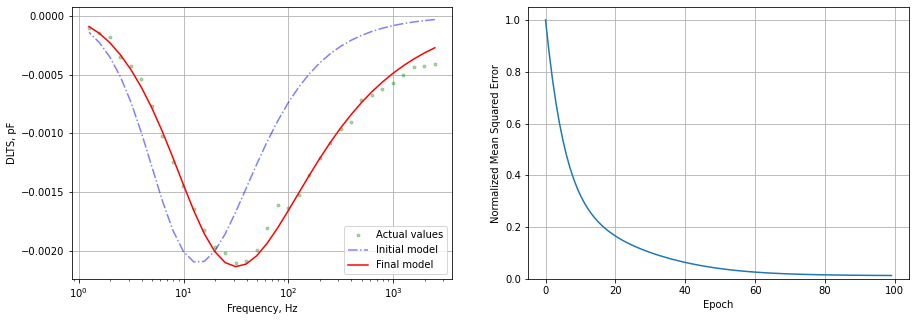

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -1.3979 log10(s)
Time constant = 4.0000e-02 s
Amplitude = -3.2295e-03 pF
P = 1.0000
MSE = 7.8401e-07
RMSE = 8.8545e-04

Final values
Filling pulse = 2.0000e-05
Time constant power = -1.7876 log10(s)
Time constant = 1.6307e-02 s
Amplitude = -3.3032e-03 pF
P = 0.6702
MSE = 4.1430e-09
RMSE = 6.4366e-05


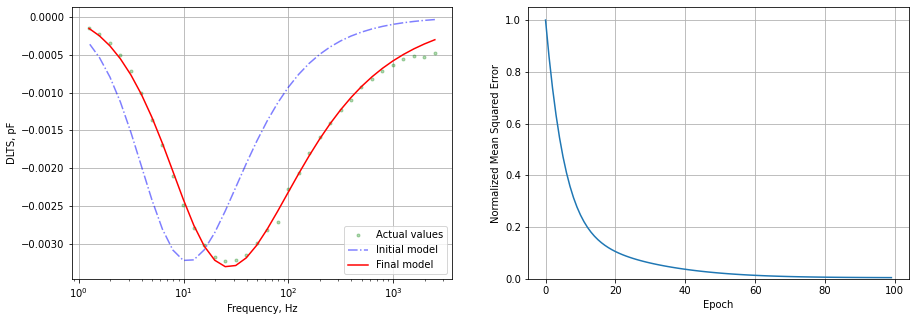

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -3.0979 log10(s)
Time constant = 7.9810e-04 s
Amplitude = -2.6080e-04 pF
P = 1.0000
MSE = 7.1693e-09
RMSE = 8.4672e-05

Final values
Filling pulse = 2.0000e-05
Time constant power = -2.9377 log10(s)
Time constant = 1.1544e-03 s
Amplitude = -2.5235e-04 pF
P = 0.1802
MSE = 2.3294e-09
RMSE = 4.8264e-05


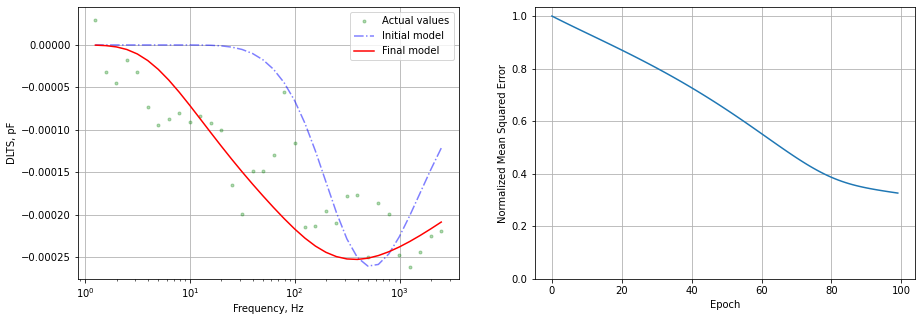

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -1.8979 log10(s)
Time constant = 1.2649e-02 s
Amplitude = -2.5150e-04 pF
P = 1.0000
MSE = 1.2666e-08
RMSE = 1.1254e-04

Final values
Filling pulse = 2.0000e-05
Time constant power = -2.5743 log10(s)
Time constant = 2.6651e-03 s
Amplitude = -2.2116e-04 pF
P = 0.2436
MSE = 4.7972e-09
RMSE = 6.9262e-05


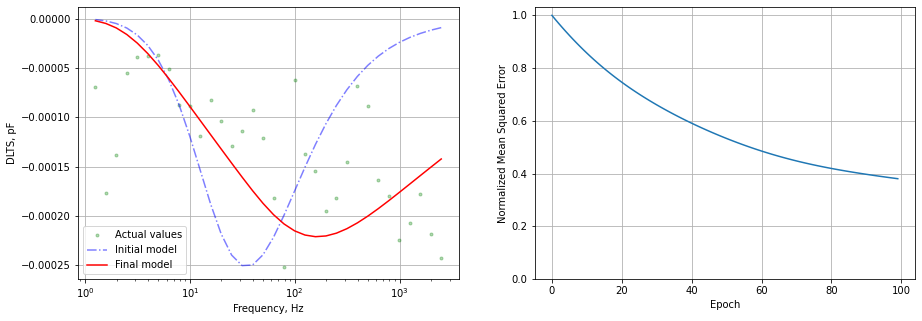

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -1.8979 log10(s)
Time constant = 1.2649e-02 s
Amplitude = -9.2360e-04 pF
P = 1.0000
MSE = 3.9810e-08
RMSE = 1.9952e-04

Final values
Filling pulse = 2.0000e-05
Time constant power = -2.1236 log10(s)
Time constant = 7.5234e-03 s
Amplitude = -9.0474e-04 pF
P = 0.5261
MSE = 5.8371e-09
RMSE = 7.6401e-05


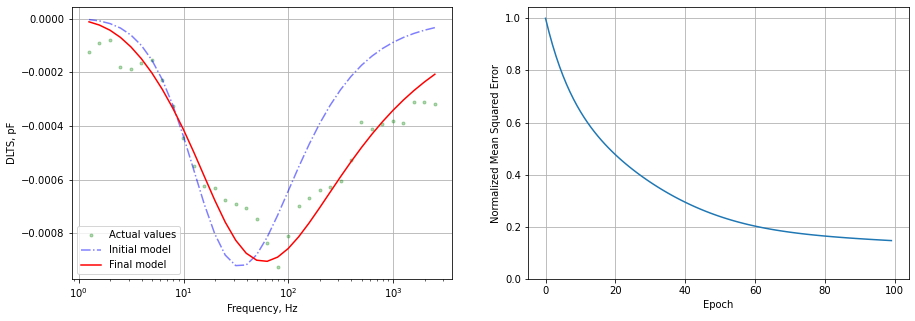

Initial values:
Filling pulse = 2.0000e-05
Time constant power = -1.5979 log10(s)
Time constant = 2.5238e-02 s
Amplitude = -1.7485e-03 pF
P = 1.0000
MSE = 1.7435e-07
RMSE = 4.1755e-04

Final values
Filling pulse = 2.0000e-05
Time constant power = -1.8972 log10(s)
Time constant = 1.2670e-02 s
Amplitude = -1.7860e-03 pF
P = 0.5757
MSE = 2.1883e-09
RMSE = 4.6779e-05


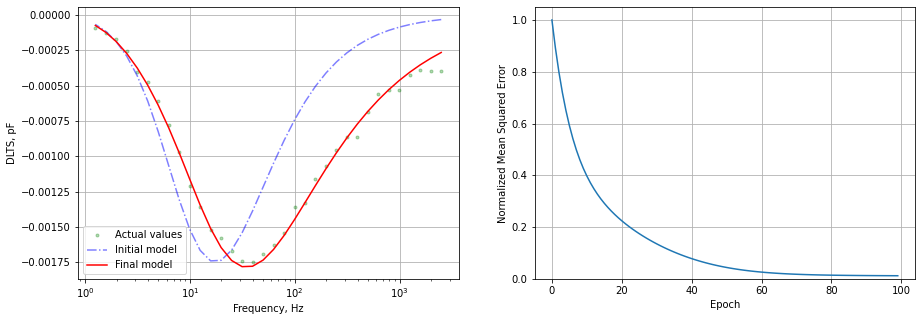

In [9]:
LEARNING_RATE = 0.01
BATCH_SIZE = 100
EPOCHS = 100

for df in df_list:
    
    freq_values, dlts_values, initial_model, final_model, history = fit_model(dlts=df.dlts_pf.values, 
                                                                              frequency=df.frequency_hz.values, 
                                                                              f_pulse=df.f_pulse[0], 
                                                                              learning_rate=LEARNING_RATE, 
                                                                              batch_size=BATCH_SIZE, 
                                                                              epochs=EPOCHS, 
#                                                                               return_history=True
                                                                             )
    
    fig, ax = print_results(frequency = freq_values,
                            actual_dlts = dlts_values,
                            initial_model = initial_model,
                            final_model = final_model,
                            history = history
                           )

#     print(f'p = {final_model.p_coef.numpy():.4f}')

    # plt.savefig('plots/monoexponential/p_SGD.svg')
    plt.show()